In [184]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import sys, os
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/project_specific/windwave/')
# sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from tqdm import tqdm
import matplotlib as mpl
"""Use customized plotting theme"""
import matplotlib as mpl
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')

Notice:
In all the processing code, y refers to the direction normal to the wall but in the publication version it's denoted z. 

In [2]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
def load_object(filename):
    with open(filename, 'rb') as input:  # Overwrites any existing file.
        obj = pickle.load(input)
    return obj

In [3]:
# jupyter notebook --NotebookApp.max_buffer_size=your_value

In [4]:
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/project_specific/windwave/')
from helper import RealWave

class Case():
    """
        Class for each case. Initialization takes in the metadata like Bo, Re, ak etc.
        self.availt: The longest running time
        self.path: Path of the case file
    """
    def __init__(self, ustar, Retau, Bo, g, ak, LEVEL, emax, alterMU=1., L0=2*np.pi, k=4., h=1., OUTLEVEL=8,
                 working_dir='/home/jiarong/research/projects/turbulence/', prefix='curved_fixREtau_', 
                 PRINTWAVE=False, NOMATCH=True, PRECURSOR=False):
        '''
        alterMU: the altered MU ratio. Default 1. Turn on NOMATCH as well.
        self.N: output grid number
        '''
        # Register the metadata and spell the path
        if PRECURSOR:
            self.ustar = ustar; self.ak = ak; self.Bo = None; self.Retau = Retau; self.alterMU = None
            self.emax=emax; self.LEVEL = LEVEL; self.N = 2**OUTLEVEL
            self.L0 = L0; self.g = None; self.k = k; self.h = h
            self.rho1 = 1; self.rho2 = 1.225/1000.; self.sigma = None
            self.mu2 = self.ustar*self.rho2*(self.L0-h)/self.Retau; self.mu1 = self.mu2/(18.31e-6/10.0e-4)/alterMU
            self.path = working_dir + prefix + 'REtau%g_ak%g_LEVEL%g_emax%g/' %(self.Retau,self.ak,self.LEVEL,self.emax) 
        else:   
            self.ustar = ustar; self.ak = ak; self.Bo = Bo; self.Retau = Retau; self.alterMU = alterMU
            self.emax=emax; self.LEVEL = LEVEL; self.N = 2**OUTLEVEL
            self.L0 = L0; self.g = g; self.k = k; self.h = h
            self.rho1 = 1; self.rho2 = 1.225/1000.; self.sigma = self.g/(self.Bo*self.k**2)
            self.mu2 = self.ustar*self.rho2*(self.L0-h)/self.Retau; self.mu1 = self.mu2/(18.31e-6/10.0e-4)/alterMU
            if NOMATCH == True:
                self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_MU%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.alterMU,self.LEVEL,self.emax) 
            else:
                self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.LEVEL,self.emax) 
            # Run wave helper function to compute wave related info0
            # Notice that this depends on the definition of the wave in the specific set of cases
            self.wave = RealWave(g=self.g, sigma=self.sigma, rho=self.rho1, rho_air=self.rho2, mu = self.mu1, mu_air = self.mu2)
            self.wave.k2omega(self.k)       
            # Print out wave info; to double check, print the message file
            if PRINTWAVE:
                print(self.path)
                print("mu1 = %g, rho1 = %g, mu2 = %g, rho2 = %g, sigma = %g" %(self.mu1, self.rho1, self.mu2, self.rho2, self.sigma))
                print("Given k = %g (1/m), calculated omega = %g (1/s), period = %g (s), phase speed c = %g (m/s), wavelength = %g (m), Bo = %g" 
                      %(self.wave.k, self.wave.omega, 2*np.pi/self.wave.omega, self.wave.c, self.wave.wl, self.Bo))
                f = open(self.path+"message", "r")
                print(f.read())
    
    def eta_series(self, nframe, tstart, dt=1, PRUNING=True):
        pass
        '''
        This function reads in a eta time series and create a Eta object for each time.
        Input:
            nframe: Number of total frames.
            tstart: The starting time.
            dt: Time interval between each read-in.
            PRUNING: If eta is output by multiple processes and have multiple headers
            (might become obsolete).
        Output:
            self.energy_t: energy (std(eta)**2) time series (scalar)
            self.interface_t: time series of Interface object       
        '''       
#         self.t = np.zeros(nframe)
#         self.energy_t = []
#         self.interface_t = [] 
#         for i in tqdm (range (0,nframe)):
#             self.t[i] = tstart+i*dt
#             interface = Interface(self.L0, self.N, self.path, self.t[i], PRUNING=PRUNING)
#             self.interface_t.append(interface)
#             self.energy_t.append(np.std(interface.eta_tile)**2)      
#         self.energy_t = np.array(self.energy_t)
    
    def mean_profile(self, time):
        NSLICE = 256
        NGRID = self.N
        self.yarray = np.linspace(0,self.L0,self.N,endpoint=False)+self.L0/2**self.N/2
        self.ux_ensemble = []
        for t in time:
            ux_3D = [] # axis0 in z, axis1 in x, axis2 in y  (in the code)
            for i in range (0,NSLICE-1):
                filename = self.path + 'field/ux_t%g_slice%g' % (t,i)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                ux = snapshot[:,0:NGRID].astype(np.float)
                ux_3D.append(ux)
            ux_3D = np.array(ux_3D)
            ux_aver = np.zeros(NGRID)
            # Slice in x,z(y) plane and average
            for i in range(0,NGRID):
                ux_aver[i] = np.average(ux_3D[:,:,i])
            self.ux_ensemble.append(ux_aver)
        self.ux_ensemble_aver = np.average(np.array(self.ux_ensemble), axis = 0)
        
    def field(time): 
        pass

In [5]:
"""Mostly just working with these two cases"""
# case1 = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_boundary_')
# case2 = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.2, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_boundary_')
case1 = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case1.tstart = 57
case2 = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.2, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case2.tstart = 57
case3 = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.2, LEVEL=10, emax=0.3, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case3.tstart = 57
case4 = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.1, LEVEL=10, emax=0.1, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case4.tstart = 307
case5 = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.1, LEVEL=10, emax=0.1, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case5.tstart = 301.5
case6 = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.1, LEVEL=10, emax=0.1, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case6.tstart = 307

# case_pre1 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.2, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre2 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.1, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre3 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre4 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.1, LEVEL=10, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre5 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0, LEVEL=10, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre6 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.1, LEVEL=11, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre7 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.2, LEVEL=10, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre8 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.2, LEVEL=11, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre9= Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.2, LEVEL=11, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')
# case_pre10= Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0, LEVEL=11, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                 prefix='curved_fixREtau_precursor_')

/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/
mu1 = 7.67063e-06, rho1 = 1, mu2 = 2.24719e-06, rho2 = 0.001225, sigma = 0.0003125
Given k = 4 (1/m), calculated omega = 2.00499 (1/s), period = 3.13377 (s), phase speed c = 0.501248 (m/s), wavelength = 1.5708 (m), Bo = 200
g = 1, c = 0.501248, Ustar = 0.25, MURATIO = 0.01831, mu_w = 7.67063e-06, rho_w = 1, mu_a = 2.24719e-06, rho_a = 0.001225, sigma = 0.0003125, Bo = 200, RE = 102646, Re_tau = 720
RELEASETIME = 57, uemax = 0.075 
tiger-h19c2n6.28240Exhausted 1048576 MQ irecv request descriptors, which usually indicates a user program error or insufficient request descriptors (PSM2_MQ_RECVREQS_MAX=1048576)
srun: Job step aborted: Waiting up to 47 seconds for job step to finish.
slurmstepd: error: *** STEP 7188585.0 ON tiger-h19c2n6 CANCELLED AT 2021-09-21T01:12:00 DUE TO TIME LIMIT ***
[warn] Epoll ADD(4) on fd 42 failed.  Old events were 0; read change was 0 (none); write change 

In [6]:
from scipy.interpolate import griddata
import gc
from scipy.special import gamma
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt

class Interface2D():
    """Class for every interface related 2D output. Unstructured grid input.
            
    Attributes:
        xarray: equal distanced x grid 
        zarray: equal distanced y grid 
        <field>data: row data of <field>
        <field>: interpolated data of <field>, including eta/p/grad/dudy/uxw...    
    """
     
    def __init__(self, L0, N, path, t, PRUNING=True, pre='field/eta_loc_t'):
        """Example of docstring on the __init__ method.

        The __init__ method may be documented in either the class level
        docstring, or as a docstring on the __init__ method itself.

        Either form is acceptable, but the two should not be mixed. Choose one
        convention to document the __init__ method and be consistent with it.

        Note:
            Do not include the `self` parameter in the ``Args`` section.

        Args:
            L0, N: The desired output grid number
            working_dir: The case's directory
            t: Time of this eta file.
            PRUNING: If eta is output by multiple processes and have multiple headers
                    (only applicable to MPI processed file).  
            pre: the prefix of the desirable data file.
        """
        self.L0 = L0; self.N = N; self.t = t
        self.xarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 # Centered grid for interpolation
        self.zarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 # Centered grid for interpolation
        filename = path + pre + '%g' %self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        # Field entries
        # x,pos,epsilon,p,p_p1,p_p2,dudy1,dudy2,dvdx1,dvdx2,dudx1,dudx2,dvdy1,dvdy2,uxa,uya,uxw,uyw
        # Updated: x, pos, epilon,p,dudy,dvdx,dudx,dvdy,uxa,uya,uxw,uyw
        if PRUNING:
            snapshot = snapshot[snapshot.x != 'x']
            snapshot = snapshot.astype('float')
            snapshot = snapshot[snapshot.pos < 1 + 0.4/4] # Exclude data over slope 0.4
            snapshot = snapshot[abs(snapshot.p-snapshot.p.mean()) < 10**(-2)] # Extra pruning for wild p
            snapshot = snapshot[np.isinf(snapshot.epsilon) == 0] # Gradient showing inf
            
        snapshot = snapshot.sort_values(by = ['x'])      
        
        self.xdata = np.array(snapshot.x, dtype=float)
        self.zdata = np.array(snapshot.z, dtype=float)
        self.etadata = np.array(snapshot.pos, dtype=float)
        self.pdata = np.array(snapshot.p, dtype=float)
        self.graddata = np.array(snapshot.epsilon, dtype=float)
        self.dudydata = np.array(snapshot.dudy, dtype=float)
        self.dvdxdata = np.array(snapshot.dvdx, dtype=float)
        self.dudxdata = np.array(snapshot.dudx, dtype=float)
        self.dvdydata = np.array(snapshot.dvdy, dtype=float)
#         self.uxwdata = np.array(snapshot.uxw, dtype=float)
#         self.uywdata = np.array(snapshot.uyw, dtype=float)
#         self.delta = np.array(snapshot.delta, dtype=float)

        del (snapshot); gc.collect()  # Only necessary for 2D for memory issue              
        
        # Interpolate over x and z, 'nearest' is used to ensure that none of the interpolated point is 'nan'
        self.xtile, self.ztile = np.meshgrid(self.xarray,self.zarray)
        self.eta = griddata((self.xdata.ravel(), self.zdata.ravel()), self.etadata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.p = griddata((self.xdata.ravel(), self.zdata.ravel()), self.pdata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dudy = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dudydata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dvdx = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dvdxdata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dudx = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dudxdata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dvdy = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dvdydata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.grad = griddata((self.xdata.ravel(), self.zdata.ravel()), self.graddata.ravel(), (self.xtile, self.ztile), method='nearest')
#         self.uxw = griddata(self.xdata.ravel(), self.zdata.ravel(), self.uxwdata.ravel(), self.xarray, self.zarray, method='nearest')
#         self.uyw = griddata(self.xdata.ravel(), self.zdata.ravel(), self.uywdata.ravel(), self.xarray, self.zarray, method='nearest')
        del(self.etadata); del(self.pdata); del(self.dudydata); del(self.dvdxdata); del(self.dudxdata)
        del(self.dvdydata); del(self.graddata)
        
        # Get the phase index
        # axis 0 is y, axis 1 is x
        # TODO: MAKE THIS 2D COMPATIBLE
        eta_1D = np.average(self.eta, axis=0)
        eta_1D_filtered = eta_1D-np.average(eta_1D)
        # CAUTION: It seems like doing filtering will make the ohase inaccurate
#         eta_1D_filtered = self.__butter_lowpass_filter(eta_1D-np.average(eta_1D))
        analytic_signal = hilbert(eta_1D_filtered)
        self.phase = np.angle(analytic_signal)
        self.idx = abs(self.phase).argmin() # 0 corresponds to crest, -pi/pi corresponds to trough
#         from scipy.signal import argrelextrema
#         maxm1 = argrelextrema(self.phase, np.greater)
#         self.idx = maxm1[0][3]
    
    def __butter_lowpass_filter(self, data, CUT=4):
        """A helper function that performs lowpass filtering."""
        T = 1           # Sample Period
        fs = self.N        # Sample rate, Hz (should be the xarray size)
        cutoff = CUT    # desired cutoff frequency of the filter, Hz
        nyq = 0.5 * fs  # Nyquist Frequency
        order = 4       # sin wave can be approximately represented as quadratic
        n = int(T * fs) # total number of samples
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def uwater(self, c, ustar, omega, Re):
        """ Water velocity decomposition.
            Dependency: gamma from scipy.special, hilbert from scipy.signal
            
            Args:
                c: wave speed (analyical from case.wave.c)
                ustar: u*/c (from case.ustar)
                omega: omega (from case.wave.omega)
                Re: Re (from case.Re)
                
            Attributes:
                uxw_smooth: smoothed direct output of uxw
                uyw_smooth: smoothed direct output of uyw
                eta_smooth
                phase
                ux_orbit: orbital velocity from eta_smooth, u component (simplest estimation)
                uy_orbit: orbital velocity from eta_smooth, v component
                ud: uxw_smooth - ux_orbit, approximate drift velocity (phase dependent)
                ud_analy: analytical time dependent drift, constant along x
                uxw_analy: ud_analy + ux_orbit
        """
        
        # Smooth out simulation output water velocity
        self.uxw_smooth = self.__butter_lowpass_filter(self.uxw, CUT=8)
        self.uyw_smooth = self.__butter_lowpass_filter(self.uyw, CUT=8)

        # The analytical water velocity
        self.eta_smooth = self.__butter_lowpass_filter(self.eta, CUT=8)
        analytic_signal = hilbert(self.eta_smooth)
        self.phase = np.unwrap(np.angle(analytic_signal))
        self.ux_orbit = self.eta_smooth*c*2*np.pi
        self.uy_orbit = self.eta_smooth*c*2*np.pi/np.cos(self.phase)*np.cos(self.phase-np.pi/2)        
        self.ud = self.uxw_smooth - self.ux_orbit
        self.ud_analy = self.t**0.5*gamma(1)/gamma(3/2)/850 * (ustar*c)**2 * (2*np.pi/omega/(1/Re))**0.5 # Drift according to theoretical solution
        self.uxw_analy = self.ud_analy + self.ux_orbit
        
    def stress(self, tau0, mu_a):
        """ Integrate 2D pressure p times surface gradient to get the form drag; strain dudy, dvdx to get the shear stress.
            No quasi 1D approximation is needed.
            Smoothing is optional.
        
            Args:
                tau0: the set total stress, for normalization.
                mu_a: the air dynamic viscosity, for calculating shear stress.
                
            Attributes:
                tau0: rho u_*^2 from given
                p, p_smooth: the original p subtracted by average and smoothed p              
                tau_nux, tau_nuy:
                tau_nux_smooth, tau_nuy_smooth:
        """
        # Pressure
        self.tau0 = tau0
        self.p = self.p-np.average(self.p) # Subtract mean
        # self.p_smooth = self.__butter_lowpass_filter(self.p, CUT=8) # The cut frequency is pretty high to capture rapid change
        self.formdrag = np.average(self.p*self.grad)
        
        # Shear stress
        # Take also dvdx into account
        # tau_nux1 = self.__butter_lowpass_filter(self.dudy_tile, CUT=4)*mu_a
        self.tau_nux1 = self.dudy*mu_a; self.tau_nux2 = self.dvdx*mu_a
        self.tau_nux = (self.dudy+self.dvdx)*mu_a 
#         self.tau_nux_smooth = self.__butter_lowpass_filter(self.tau_nux, CUT=8)
        self.tau_nuy = 2*self.dvdy*mu_a
#         self.tau_nuy_smooth = self.__butter_lowpass_filter(self.tau_nuy, CUT=8)
        self.shear = np.average(self.tau_nux)
    
    def spectrum(self,peak=4):
        """2D Fourier transform to get the peak frequency energy. Can later be extended to include other spectrum analysis.
        
            Args:
                peak: int. Index of the peak frequency in the spectrum array.
                
            Attributes:
                Ep: peak frequency energy.
        """
        spectrum = np.fft.fft2(self.eta-np.average(self.eta))*(1/self.N)**2 # TODO: How to normalize here?!
        F = np.absolute(spectrum)
        self.Ep = np.average(F,axis=0)[peak] # Only record the peak frequency spetrum amplitude
        
#     def vis(self):
#         """Visualize velocity and stress. Can only be run after uwater and stress are both run."""
#         plt.figure(figsize=[4,6])
        
#         # Plot water velocity in axis1
#         ax1 = plt.subplot(311)       
#         ax1.plot(self.xdata, self.uxwdata, c='C0', alpha = 0.5) # Water velocity uxw unfiltered 
#         ax1.plot(self.xdata, self.uywdata, c='C1', alpha = 0.5) # Water velocity uyw unfiltered
#         ax1.plot(self.xarray, self.uxw_smooth, c='C0', label = '$u_s$') # Water velocity uxw smoothed 
#         ax1.plot(self.xarray, self.uyw_smooth, c='C1', label = '$v_s$') # Water velocity uyw smoothed         
#         ax1.plot(self.xarray, self.ux_orbit, '--', c='C2', label='$u_{orbit}$', alpha = 0.5) # Orbital velocity u analytical
#         ax1.plot(self.xarray, self.uy_orbit, '--', c='C1', label='$v_{orbit}$', alpha = 0.5) # Orbital velocity v analytical
#         ax1.plot(self.xarray, self.ud, '--', c='C3', label = '$u_s - u_{orbit}$', alpha = 0.5)
#         ax1.plot(self.xarray, self.eta_smooth, c='gray', alpha = 0.5)
#         ax1.set_xlabel(r'$x/\lambda$')
#         ax1.set_ylabel(r'$u_s,v_s$')
#         ax1.set_xlim([-0.5,0.5])
#         ax1.set_ylim([-0.05,0.1])
# #         ax1.legend(bbox_to_anchor=(1.02, 0.5), loc = 'center left')   
#         ax1.legend(loc='upper right')   
        
#         # Plot pressure in axis2
#         ax2 = plt.subplot(312)
#         ax2.plot(self.xarray, self.p/self.tau0,  c='C4', alpha=0.5) # Pressure
#         ax2.plot(self.xarray, self.p_smooth/self.tau0, c='C4', label = r'$p$') # Pressure smoothed
#         # Average tau_p
#         ax2.plot(self.xarray, self.p_smooth*self.grad/self.tau0, c='C0', label = r'$p\frac{\partial \eta}{\partial x}$')
#         ax2.plot(self.xarray, np.average(self.p_smooth*self.grad)/self.tau0*np.ones(self.N), '--', c='C0')
#         ax2.plot(self.xarray, self.eta_smooth*50, c='gray', alpha = 0.5)
#         ax2.set_xlim([-0.5,0.5])
#         ax2.set_ylim([-10,10])
#         ax2.set_xlabel(r'$x/\lambda$'); ax2.set_ylabel(r'$p/\rho_a u_*^2$')  
#         ax2.legend(loc='upper right')
        
#         # Plot shear stress in axis 3
#         ax3 = plt.subplot(313)
#         ax3.plot(self.xarray, self.tau_nux/self.tau0, alpha = 0.5) 
#         ax3.plot(self.xarray, self.tau_nux_smooth/self.tau0, c='C0',
#                  label = r'$\tau_{\nu x} = \mu_a (\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x})$') 
#         # Sanity check
#         # ax3.plot(self.xarray, self.tau_nux1/tau0, '--', c='C0') 
#         # Average tau_nu
#         ax3.plot(self.xarray, np.average(self.tau_nux)/self.tau0*np.ones(self.N), '--', c='C0')         
#         ax3.plot(self.xarray, self.tau_nuy/self.tau0, alpha = 0.5) griddata() got multiple values for argument 'method'
#         ax3.plot(self.xarray, self.tau_nuy_smooth/self.tau0, c='C1',
#                  label = r'$\tau_{\nu y} = 2 \mu_a \frac{\partial v}{\partial y}$') 
#         ax3.plot(self.xarray, self.eta_smooth*10, c='gray', alpha = 0.5)
#         ax3.set_xlim([-0.5,0.5])
#         ax3.set_ylim([-0.5,2])
#         ax3.set_xlabel(r'$x/\lambda$'); ax3.set_ylabel(r'$\tau_\nu/\rho_a u_*^2$')
#         ax3.legend(loc='upper right')
#         return (ax1,ax2,ax3)
        
#     def integrate(self):
#         """Compute the phase average input terms.
        
#             Attributes:
#                 S_taunu: total input from shear stress (from smoothed)
#                 S_taunu_err: total input from shear stress unsmoothed, for error bar
#                 S_taunu_w: approximate sub part of S_taunu from wave, computed using ux_orbit uy_orbit
#                 S_taunu_d: appreximate sub part of S_taunu from drift 
#         """
#         self.S_taunu = np.sum(self.tau_nux_smooth*self.uxw_smooth+self.tau_nuy_smooth*self.uyw_smooth)*self.L0/self.N
#         self.S_taunu_err = np.sum(self.tau_nux*self.uxw+self.tau_nuy*self.uyw)*self.L0/self.N #For error bar
#         self.S_taunu_w = np.sum(self.tau_nux_smooth*self.ux_orbit+self.tau_nuy_smooth*self.uy_orbit)*self.L0/self.N 
#         self.S_taunu_d = np.sum(self.tau_nux_smooth*self.ud)*self.L0/self.N
#         self.S_p = np.sum(-self.p_smooth*self.uyw_smooth)*self.L0/self.N #NOTE: this is only the first order approximation!
#         self.S_p_err = np.sum(-self.p*self.uyw)*self.L0/self.N #Might need to add the metrics and uxw
                                                                         
        
#     def interval_average():
#         # How to do interval average of the above calculation
#         pass

In [8]:
"""Compute the Reynolds stress"""

def field (case, time, PRE=False, PLOT=False):
    """Put the field slices together and compute some turbulent statistics.
    Pickle the fileds if it's the first time read-in.
    
    Args:
    case: the case instance providing metadata
    time: the times where we want to compute the field statistics
    
    Returns:
    Write the following fields as case attributes.
    
    TODO: add coordinate transformation.
    
    """
    NGRID = 512; NSLICE = 256; L0 = 2*np.pi
    working_dir = case.path
    case.tstat = time # time that the statistics are computed
    case.eta =[]; case.eta_shift = [] # 1D eta (shift or not)
    case.ux = []; case.uy = []; case.f = [] # 2D ux uy # 2D ux uy
    case.re_stress = []
    """Instead of recording shifted fields, record shifting index
    Then do field_shift = np.roll(field, -idx) in x direction when needed."""
    case.shift_index = []
    case.ux_shift = []; case.uy_shift = []; case.f_shift = [] # 2D ux uy shifted, leave blank
    case.re_stress_shift = [] # 2D re shifted
    case.uxmean = [] # 1D ux mean
    case.ux_center = []; case.uy_center = []; case.f_center = [] # The center non-averaged slice to show turbulence
    case.ux_yzcrest = []; case.uy_yzcrest = []; case.f_yzcrest = [] # The y-z plane slice at crest x
    case.ux_yztrough = []; case.uy_yztrough = []; case.f_yztrough = [] # The y-z plane slice at trough x
    
    for t in tqdm(time):
        # Read in eta (utilize the Interface class)
#         filename = working_dir + 'eta/eta_t%g' % 59
#         snapshot = pd.read_table(filename, delimiter = ',')
#         eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
#         xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2 
#         zarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
#         x_tile, z_tile = np.meshgrid(xarray,zarray)
#         eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
#                                  (x_tile, z_tile), method='nearest')
#         eta_1D = np.average(eta_tile, axis=0)
        """For precursor cases just read the fixed shape"""
        """For moving wave cases just read the fixed shape"""
        if (PRE == True): 
            interface = Interface2D(L0 = 2*np.pi, N = 512, path = case.path, 
                                    pre='eta/eta_pre', t = None, PRUNING=True)
            eta_1D = np.average(interface.eta, axis=0)        
        else: 
            interface = Interface2D(L0 = 2*np.pi, N = 512, path = case.path, 
                                    pre='eta/eta_loc_t', t = t, PRUNING=True)
            eta_1D = np.average(interface.eta, axis=0)
        # Filter the data (subtract the mean)
        eta_1D_filtered = butter_lowpass_filter(eta_1D-np.average(eta_1D))
        analytic_signal = hilbert(eta_1D_filtered)
        phase = np.angle(analytic_signal)
        # Shift the velocity field along x axis so that phase starts at 0
        idx = (np.abs(phase - 0)).argmin()
#         eta_1D_shift = np.roll(eta_1D, -idx)
        ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        uy_3D = {'name':'uy', 'value':[]}
        f_3D = {'name':'f', 'value':[]}

        # Read in the fields either from pickle or from slice data
        for field in (ux_3D,uy_3D,f_3D):         
            """NOTICE: to accomodate different pickle versions"""
            picklename = working_dir + 'field/' + 'pickle_tiger/' + field['name']+'_t%g' % t +'.pkl'
#             picklename = working_dir + 'field/' + 'pickle_desktop/' + field['name']+'_t%g' % t +'.pkl'
            exists = os.path.exists(picklename)
            # If the pickle is there read in the pickles
            if exists:
                field['value'] = load_object(picklename)
                print('pickle restored!')
            # If no pickle read in from the slice files and pickle dump
            if not exists:
                for sn in range (0, NSLICE-1):
                    filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
                    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                    snapshot.reshape([NGRID,NGRID+1])
                    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
                field['value'] = np.array(field['value'])
                save_object(field['value'], picklename)
                
        # Compute Reynolds stress (not shifted)
        ux_mean = np.tile(np.average(ux_3D['value'], axis=(0,1)), (ux_3D['value'].shape[1], 1)) 
        uy_mean = np.tile(np.average(uy_3D['value'], axis=(0,1)), (uy_3D['value'].shape[1], 1))
        re_stress_3D = (ux_3D['value']-ux_mean)*(uy_3D['value']-uy_mean)*(1-f_3D['value'])
        # Compute wave coherent stress (TODO!)
        
        # Append z direction averaged 2D profile
        case.eta.append(eta_1D)
        case.ux.append(np.average(ux_3D['value'], axis=0))
        case.uy.append(np.average(uy_3D['value'], axis=0))
        case.f.append(np.average(f_3D['value'], axis=0))
        # A few fields for visualization
        # First is the center field
        SAMPLE = int(ux_3D['value'].shape[0]/2)
        print(SAMPLE) # center in z
        case.ux_center.append(ux_3D['value'][SAMPLE].copy())
        case.uy_center.append(uy_3D['value'][SAMPLE].copy())
        case.f_center.append(f_3D['value'][SAMPLE].copy())        
        # Second is at crest and trough (require shifted field)
        # These are only for plotting
        if PLOT == True:
            ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
            uy_3D_shift = {'name':'uy_shift', 'value':[]}
            f_3D_shift = {'name':'f_shift', 'value':[]}
            for (field,field_shift) in zip((ux_3D,uy_3D,f_3D),(ux_3D_shift,uy_3D_shift,f_3D_shift)):
                field_shift['value'] = np.roll(field['value'], -idx, axis=1)
            case.ux_yzcrest.append(ux_3D_shift['value'][:,256,:].copy()) # z, x, y
            case.uy_yzcrest.append(uy_3D_shift['value'][:,256,:].copy())
            case.f_yzcrest.append(f_3D_shift['value'][:,256,:].copy())
            case.ux_yztrough.append(ux_3D_shift['value'][:,192,:].copy()) # z, x, y
            case.uy_yztrough.append(uy_3D_shift['value'][:,192,:].copy())
            case.f_yztrough.append(f_3D_shift['value'][:,192,:].copy())
        case.shift_index.append(idx)
        case.re_stress.append(np.average(re_stress_3D, axis=0))        
        # Additional 1D profile
        case.uxmean.append(np.average(ux_3D['value'], axis=(0,1)))
        case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
        del(ux_3D, uy_3D, f_3D, ux_mean, uy_mean, re_stress_3D)
        gc.collect()
        
def butter_lowpass_filter(data, CUT=4, N=512):
    """A helper function that performs lowpass filtering."""
    T = 1           # Sample Period
    fs = N        # Sample rate, Hz (should be the xarray size)
    cutoff = CUT    # desired cutoff frequency of the filter, Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 4       # sin wave can be approximately represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
        
# Pick a case, and time range
# time1 = np.arange(50,59,1.)
# time2 = np.arange(59.5,61,0.5)
# time = np.concatenate((time1,time2), axis=None)

In [ ]:
"""g=1, ak=0.2"""
time = np.arange(58,85,1)
field (case1, time)
gc.collect()
"""g=4, ak=0.2"""
time = np.arange(58,85,1)
field (case2, time)
gc.collect()
"""g=16, ak=0.2"""
time = np.arange(58,73,1)
field (case3, time)
gc.collect()

In [266]:
"""g=1, ak=0.1"""
# time = np.arange(308,321,1)
# field (case4, time)
# gc.collect()
# """g=4, ak=0.1"""
# time = np.arange(302,323,1)
# field (case5, time)
# gc.collect()
"""g=16, ak=0.1"""
time = np.arange(308,312,1)
field (case6, time)
gc.collect()






  0%|          | 0/4 [00:00<?, ?it/s]/home/jiarongw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: read_table is deprecated, use read_csv instead.


127







 25%|██▌       | 1/4 [03:13<09:39, 193.02s/it]/home/jiarongw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: read_table is deprecated, use read_csv instead.


127







 50%|█████     | 2/4 [06:24<06:24, 192.45s/it]/home/jiarongw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: read_table is deprecated, use read_csv instead.


127







 75%|███████▌  | 3/4 [09:38<03:12, 192.96s/it]/home/jiarongw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: read_table is deprecated, use read_csv instead.


127







100%|██████████| 4/4 [13:14<00:00, 199.80s/it]

0

In [ ]:
"""ak=0 pre"""
"""LEVEL=10, emax=0.3"""
# time = np.arange(0,22)/2+60
# field (case_pre3, time, PRE=True)
# gc.collect()
"""LEVEL=10, emax=0.1"""
# time = np.arange(78,88,0.5)
# print(time)
# field (case_pre5, time, PRE=True)
# gc.collect()
"""LEVEL=11, emax=0.1"""
time = np.arange(74.5,88,0.5)
print(time)
field (case_pre10, time, PRE=True)
gc.collect()

In [ ]:
"""ak=0.2 pre"""
# time = np.arange(59,63.5,0.5)
# field (case_pre1, time, PRE=True)
# gc.collect()
"""ak=0.2 LEVEL=10 emax=0.1 pre 63.5-75"""
time = np.arange(1,21)/2+65
print(time)
field (case_pre7, time, PRE=True)
gc.collect()
"""ak=0.2 LEVEL=11 emax=0.3 pre 64-70"""
# time = np.arange(1,15)/2+63
# print(time)
# field (case_pre8, time, PRE=True)
# gc.collect()
"""ak=0.2 LEVEL=11 emax=0.1 pre 64-70"""
# time = np.arange(1,3)/2+75
# print(time)
# field (case_pre9, time, PRE=True)
# gc.collect()

In [ ]:
"""ak=0.1 pre"""
time = np.arange(1,20)/2+275
field (case_pre2, time, PRE=True)
gc.collect()

"""ak=0.1 emax=0.1 pre 279-300.5"""
time = np.arange(0,22)/2+289
field (case_pre4, time, PRE=True)
gc.collect()

"""ak=0.1 LEVEL=11 emax=0.1 pre 279-287.5 still running"""
time = np.arange(1,19)/2+279
print(time)
field (case_pre6, time, PRE=True)
gc.collect()

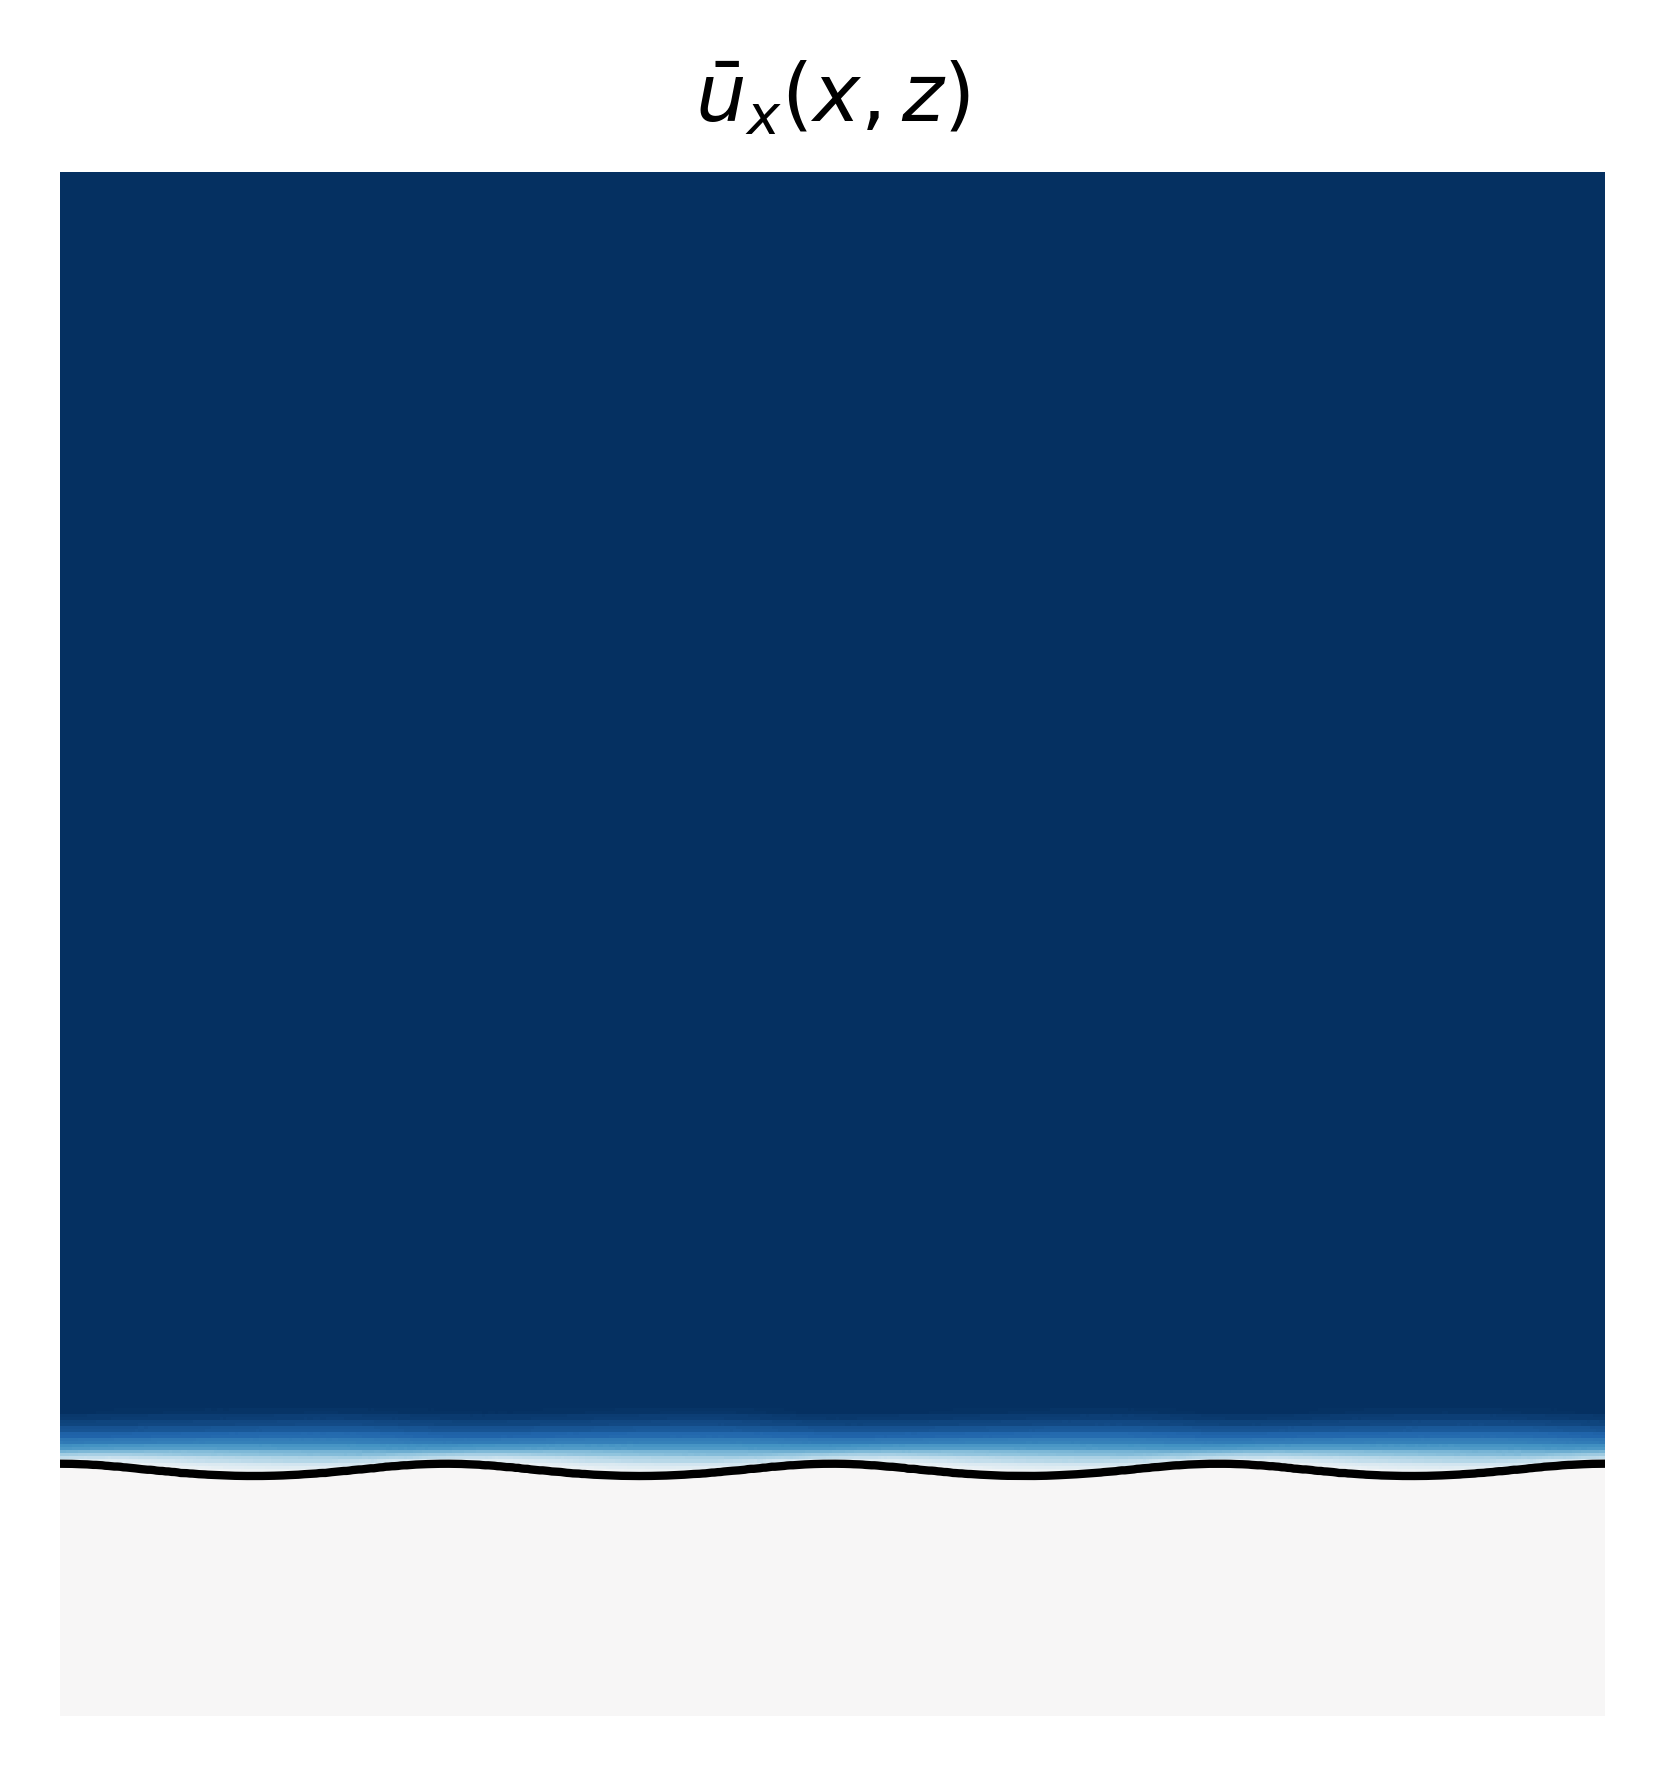

In [309]:
"""Time averaging"""
fig = plt.figure(figsize=[4,3])
case = case_1
ux_tmean = np.average(case.ux, axis=0) # Time average of the 2D
uy_tmean = np.average(case.uy, axis=0) # Time average of the 2D

# from mpl_toolkits.axes_grid1 import ImageGrid
# fig = plt.figure(figsize=(10,2))
# ax = plt.gca()
# grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
#                  nrows_ncols=(2,4),
#                  axes_pad=0.05,
#                  share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="3%",
#                  cbar_pad=0.05,
#                  )


"""u instantaneous"""
# img = plt.imshow(np.rot90(case.ux[0]/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 10, vmin = -10) 
# plt.title(r'$u_x(x,z,t)$')
"""u bar (time average)"""
img = plt.imshow(np.rot90(ux_tmean/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = 10, vmin = -10)
plt.title(r'$\bar{u}_x(x,z)$')
"""u prime"""
# img = plt.imshow(np.rot90(case.ux[0]/0.25)-np.rot90(ux_tmean/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 1, vmin = -1) 
# plt.title(r'$u_x^{\prime}(x,z,t)$')

ux_txmean = np.tile(np.average(ux_tmean, axis=0), (case.N,1)) # axis 0 is x, axis 1 is z
uy_txmean = np.tile(np.average(uy_tmean, axis=0), (case.N,1))

"""<u bar>"""
# img = plt.imshow(np.rot90(ux_txmean)/0.25, cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 10, vmin = -10) 
# plt.title(r'$\langle\bar{u}_x\rangle(z)$')

"""u tilde"""
# img = plt.imshow(np.rot90(ux_tmean - ux_txmean)/0.25, cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 1, vmin = -1) 
# plt.title(r'$\tilde{u}_x(x,z)$')

plt.axis('off')
L0 = 2*np.pi; NGRID = 512
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
plt.plot(xarray, case.eta[0], c='k', lw=1)

Text(0.5, 1.05, '$\\overline{v}/u_{*}$')

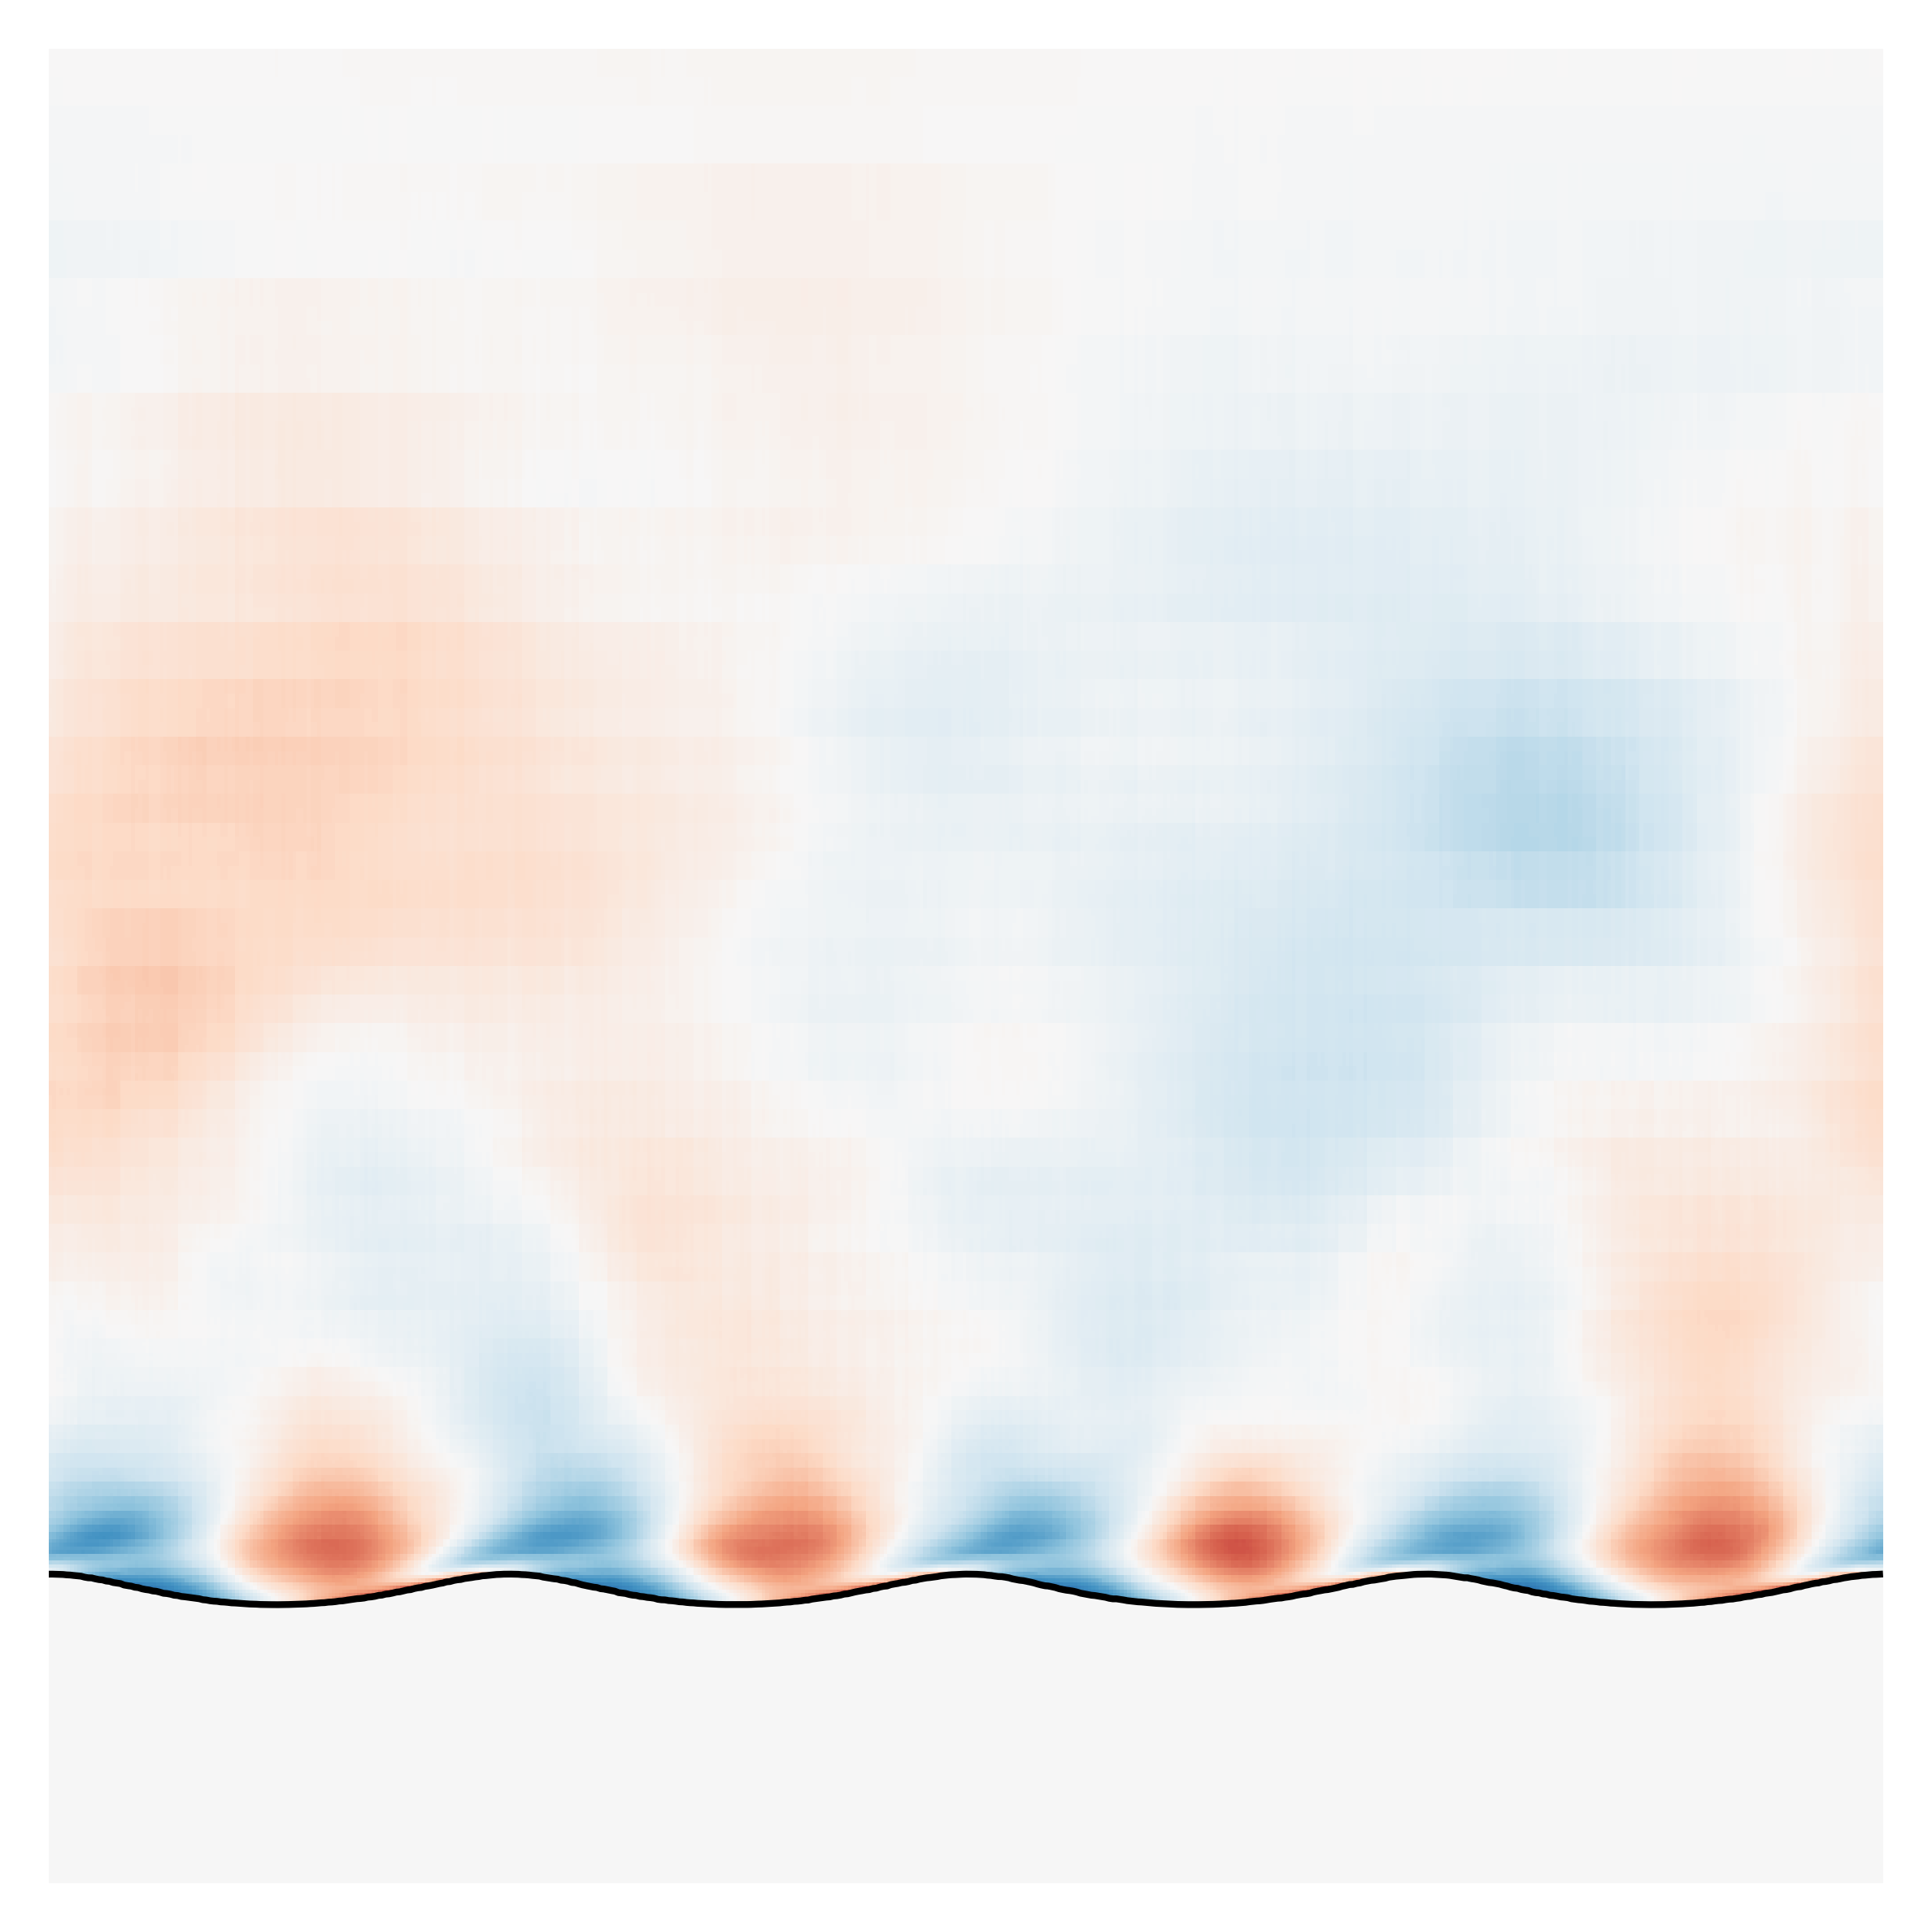

In [120]:
img = plt.imshow(np.rot90(uy_phase_aver/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = 1, vmin = -1)
plt.plot(xarray, np.roll(case.eta[ti], -case.shift_index[ti], axis=0), c='k', lw=1)
cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
plt.axis('off')
cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
             transform=cbar.ax.transAxes)

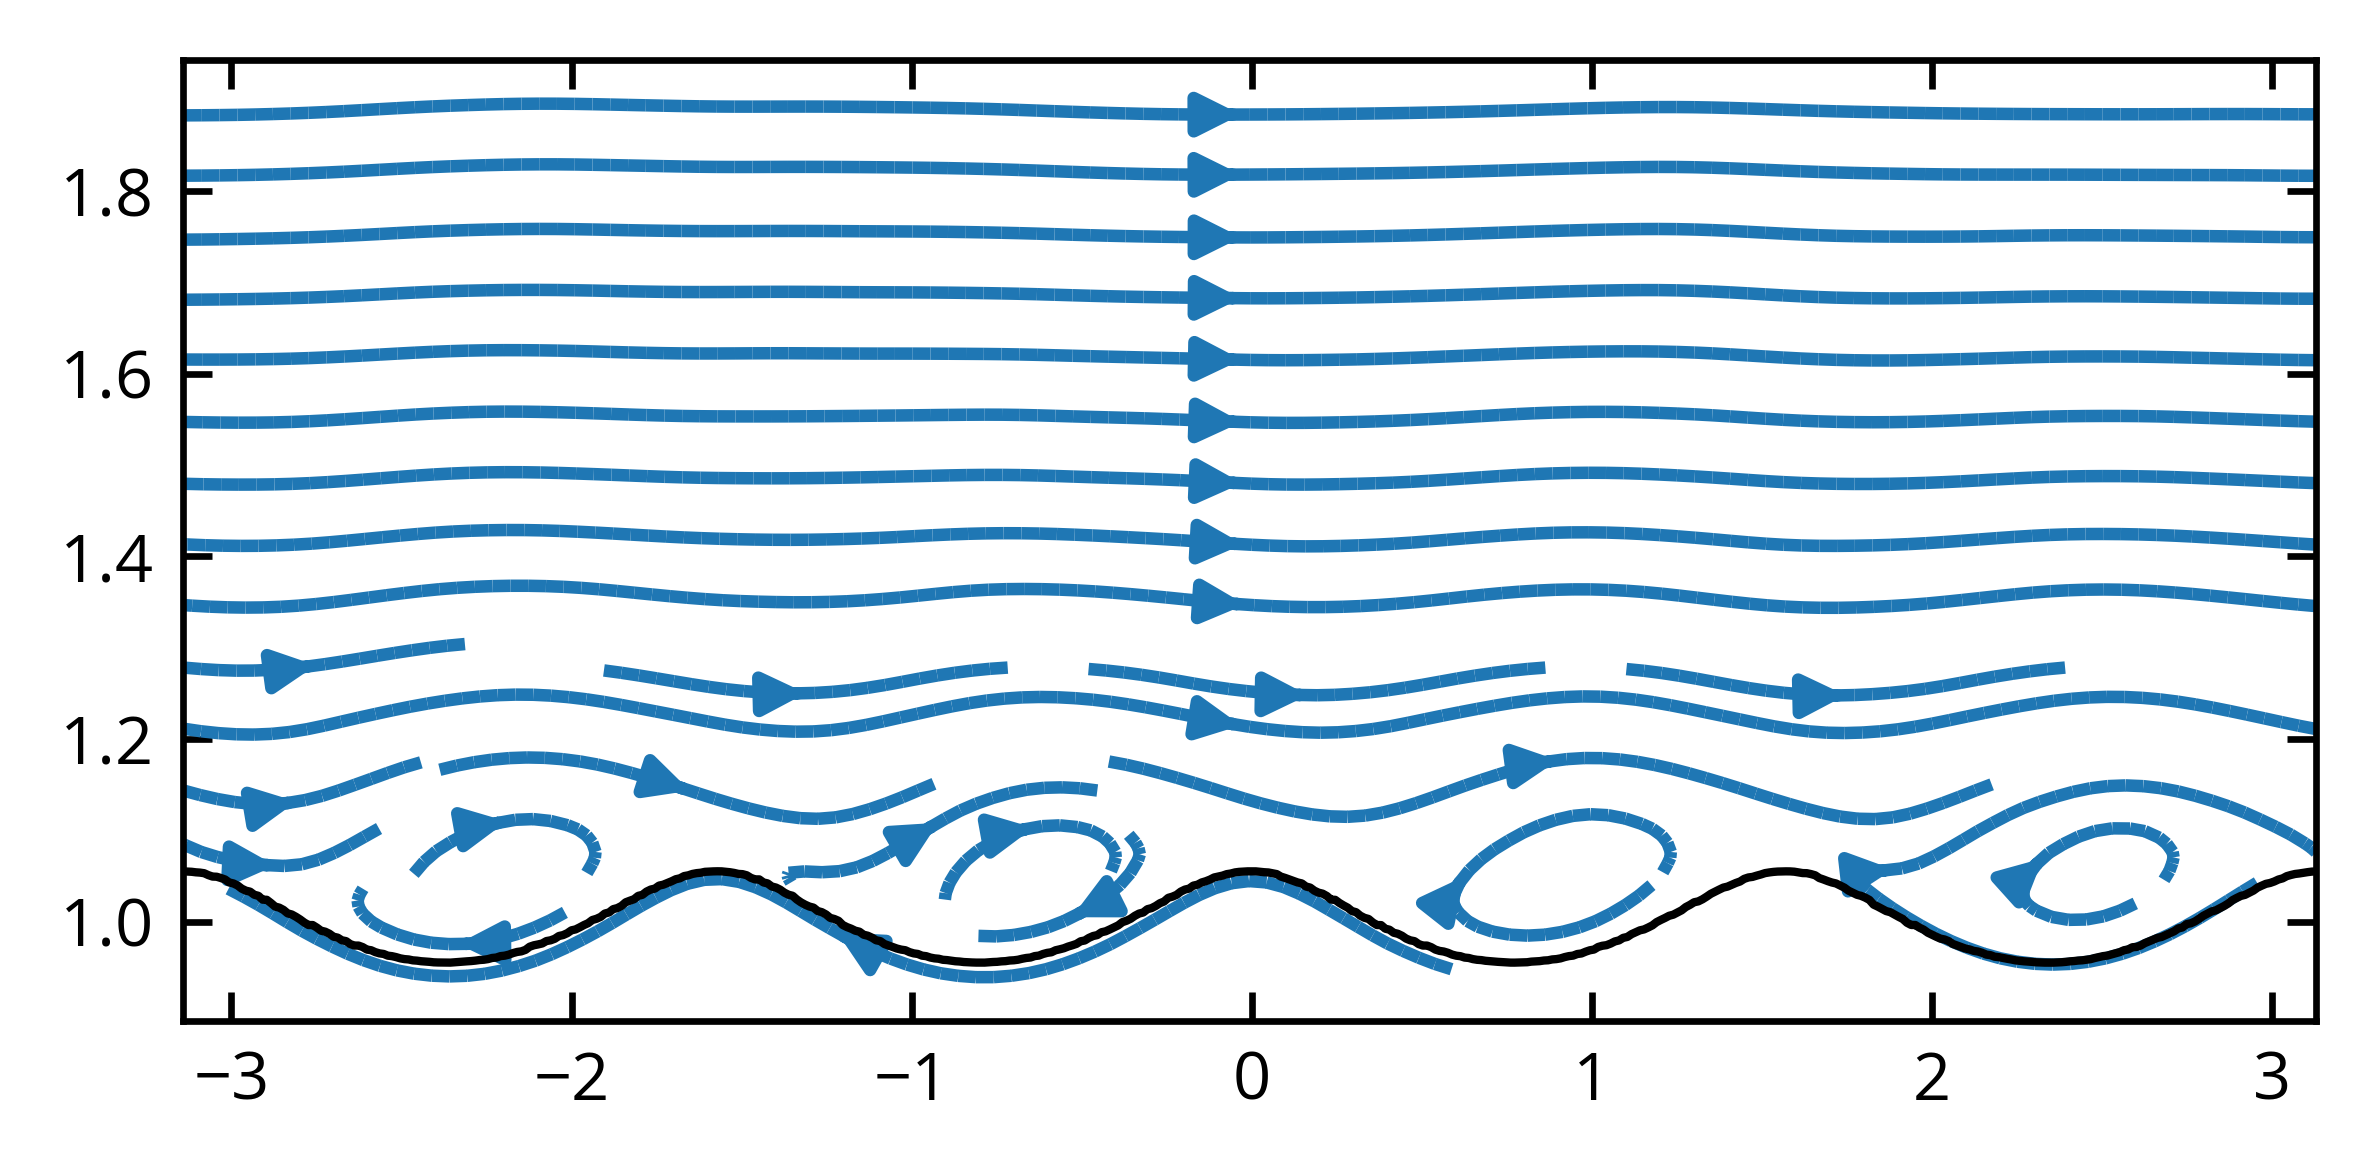

In [131]:
"""Phase averaging and streamlines"""
case = case2
ux_shift_ensem = []
uy_shift_ensem = []
for (ti,f) in enumerate(case.f[0:16]):    
    # Laboratory frame of reference
    ux_shift = np.roll(case.ux[ti], -case.shift_index[ti], axis=0)*(1-np.roll(f, -case.shift_index[ti], axis=0))
    # Wave following coordinate
    ux_shift = (np.roll(case.ux[ti], -case.shift_index[ti], axis=0)-case.wave.c)*(1-np.roll(f, -case.shift_index[ti], axis=0))
    ux_shift_ensem.append(ux_shift)
    uy_shift = np.roll(case.uy[ti], -case.shift_index[ti], axis=0)*(1-np.roll(f, -case.shift_index[ti], axis=0))
    uy_shift_ensem.append(uy_shift) 
ux_phase_aver = np.average(ux_shift_ensem, axis=0)
uy_phase_aver = np.average(uy_shift_ensem, axis=0)


NGRID = 512; NSLICE = 256; L0 = 2*np.pi
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
yarray = np.linspace(0.,L0,NGRID,endpoint=False)+L0/2**NGRID/2

# img = plt.imshow(np.rot90(ux_phase_aver/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 15, vmin = -15)
# img = plt.imshow(np.rot90(uy_phase_aver/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 1, vmin = -1)
# plt.plot(xarray, np.roll(case.eta[ti], -case.shift_index[ti], axis=0), c='k', lw=1)
# cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
# plt.axis('off')
# cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
#              transform=cbar.ax.transAxes)

"""Streamline plot
axis0 is x and axis1 is y"""
plt.figure(figsize=[4,2])
X, Y = np.meshgrid(xarray, yarray)
trunc = 160
"""MINUS sign of uy?"""
plt.streamplot(X[0:trunc,:], Y[0:trunc,:], np.rot90(ux_phase_aver,3)[0:trunc,:], np.rot90(-uy_phase_aver,3)[0:trunc,:], 
               density=[4,1])
plt.plot(xarray, np.roll(case.eta[0], -case.shift_index[0], axis=0), c='k', lw=1)

In [136]:
print('k*li = %g' %0.25)
print('k*a = %g' %0.2)

k*li = 0.25
k*a = 0.2


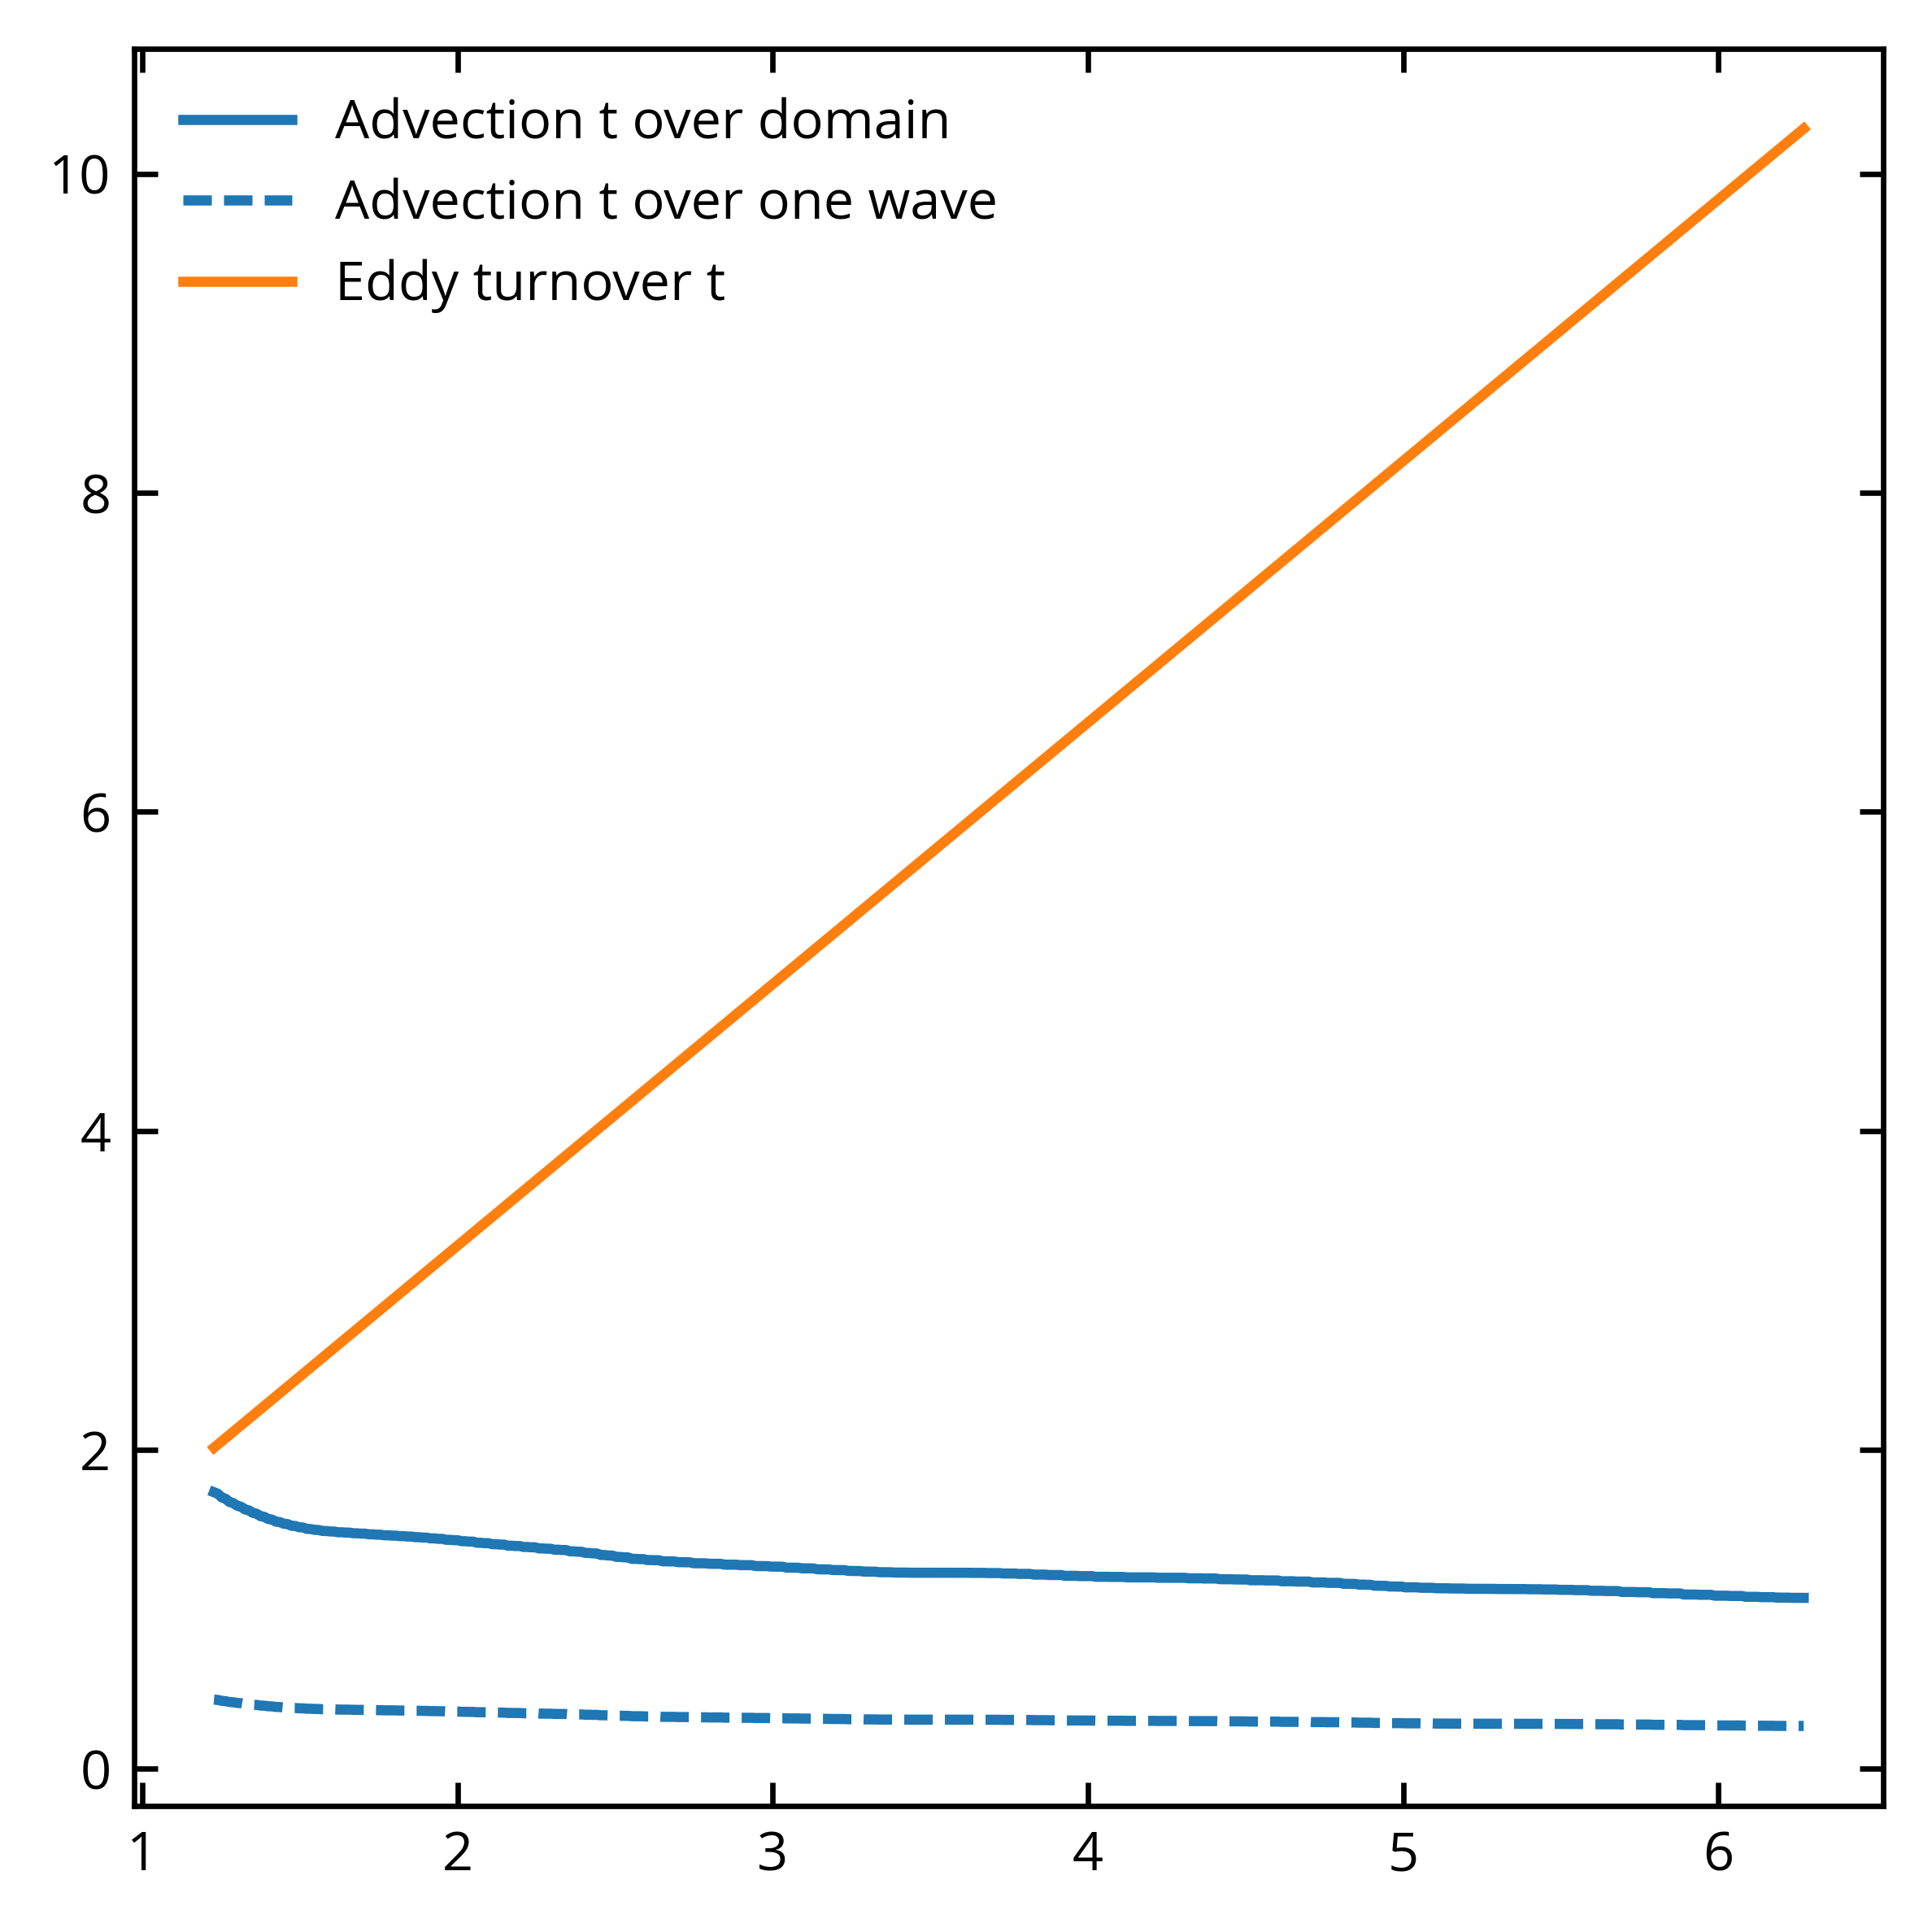

In [99]:
case = case_pre5
plt.plot(figsize=[4,2])
Ta = 2*np.pi/(case.uxmean[10][100:])
plt.plot(case.yarray[100:], Ta, label='Advection t over domain')
plt.plot(case.yarray[100:], Ta/4, '--', label='Advection t over one wave', color='C0')
Te = 0.41*case.yarray/0.25
plt.plot(case.yarray[100:], Te[100:], label='Eddy turnover t')
plt.legend()

In [ ]:
"""Spectral analysis in x direction"""

<ipython-input-108-e8fb10f6508f>:23: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cbar = grid.cbar_axes[0].colorbar(pcontour)


Text(7, 0, '$-\\overline{u^{\\prime} v^{\\prime}}/u_{*}^2$')

/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


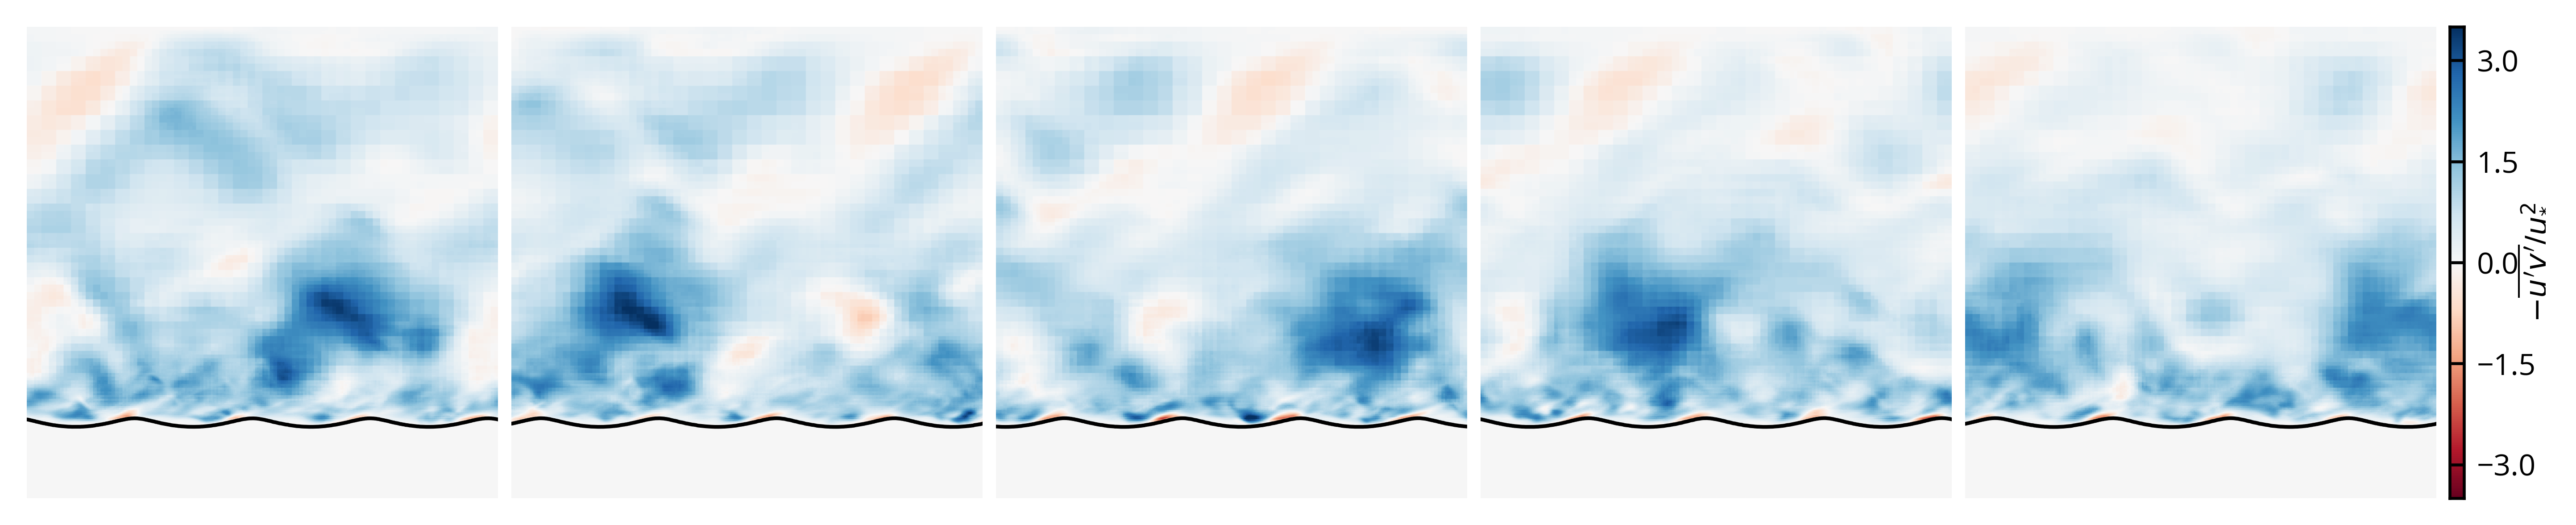

In [108]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,2))
# ax = plt.gca()
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,5),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )

case = case1
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
for i in range(0,5):
    t=20+i
    pcontour = grid[i].imshow(np.rot90(-case.re_stress[t]*(1-case.f[t])/0.25**2), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                              vmax = 3.5, vmin = -3.5)
    grid[i].plot(xarray, case.eta[t], c='k', lw=1)
    grid[i].axis('off')  
cbar = grid.cbar_axes[0].colorbar(pcontour)
cbar.ax.text(7, 0, r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^2$', rotation = 90, ha='center', va='center')      

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,2))
# ax = plt.gca()
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,5),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )

case = case2
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
for i in range(0,5):
    t=0+i
    pcontour = grid[i].imshow(np.rot90((case.ux[t]-case.wave.c)*(1-case.f[t])/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                              vmax = 15, vmin = -15)
    grid[i].plot(xarray, case.eta[t], c='k', lw=1)
    grid[i].axis('off')  
cbar = grid.cbar_axes[0].colorbar(pcontour)
cbar.ax.text(7, 0, r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^2$', rotation = 90, ha='center', va='center')      

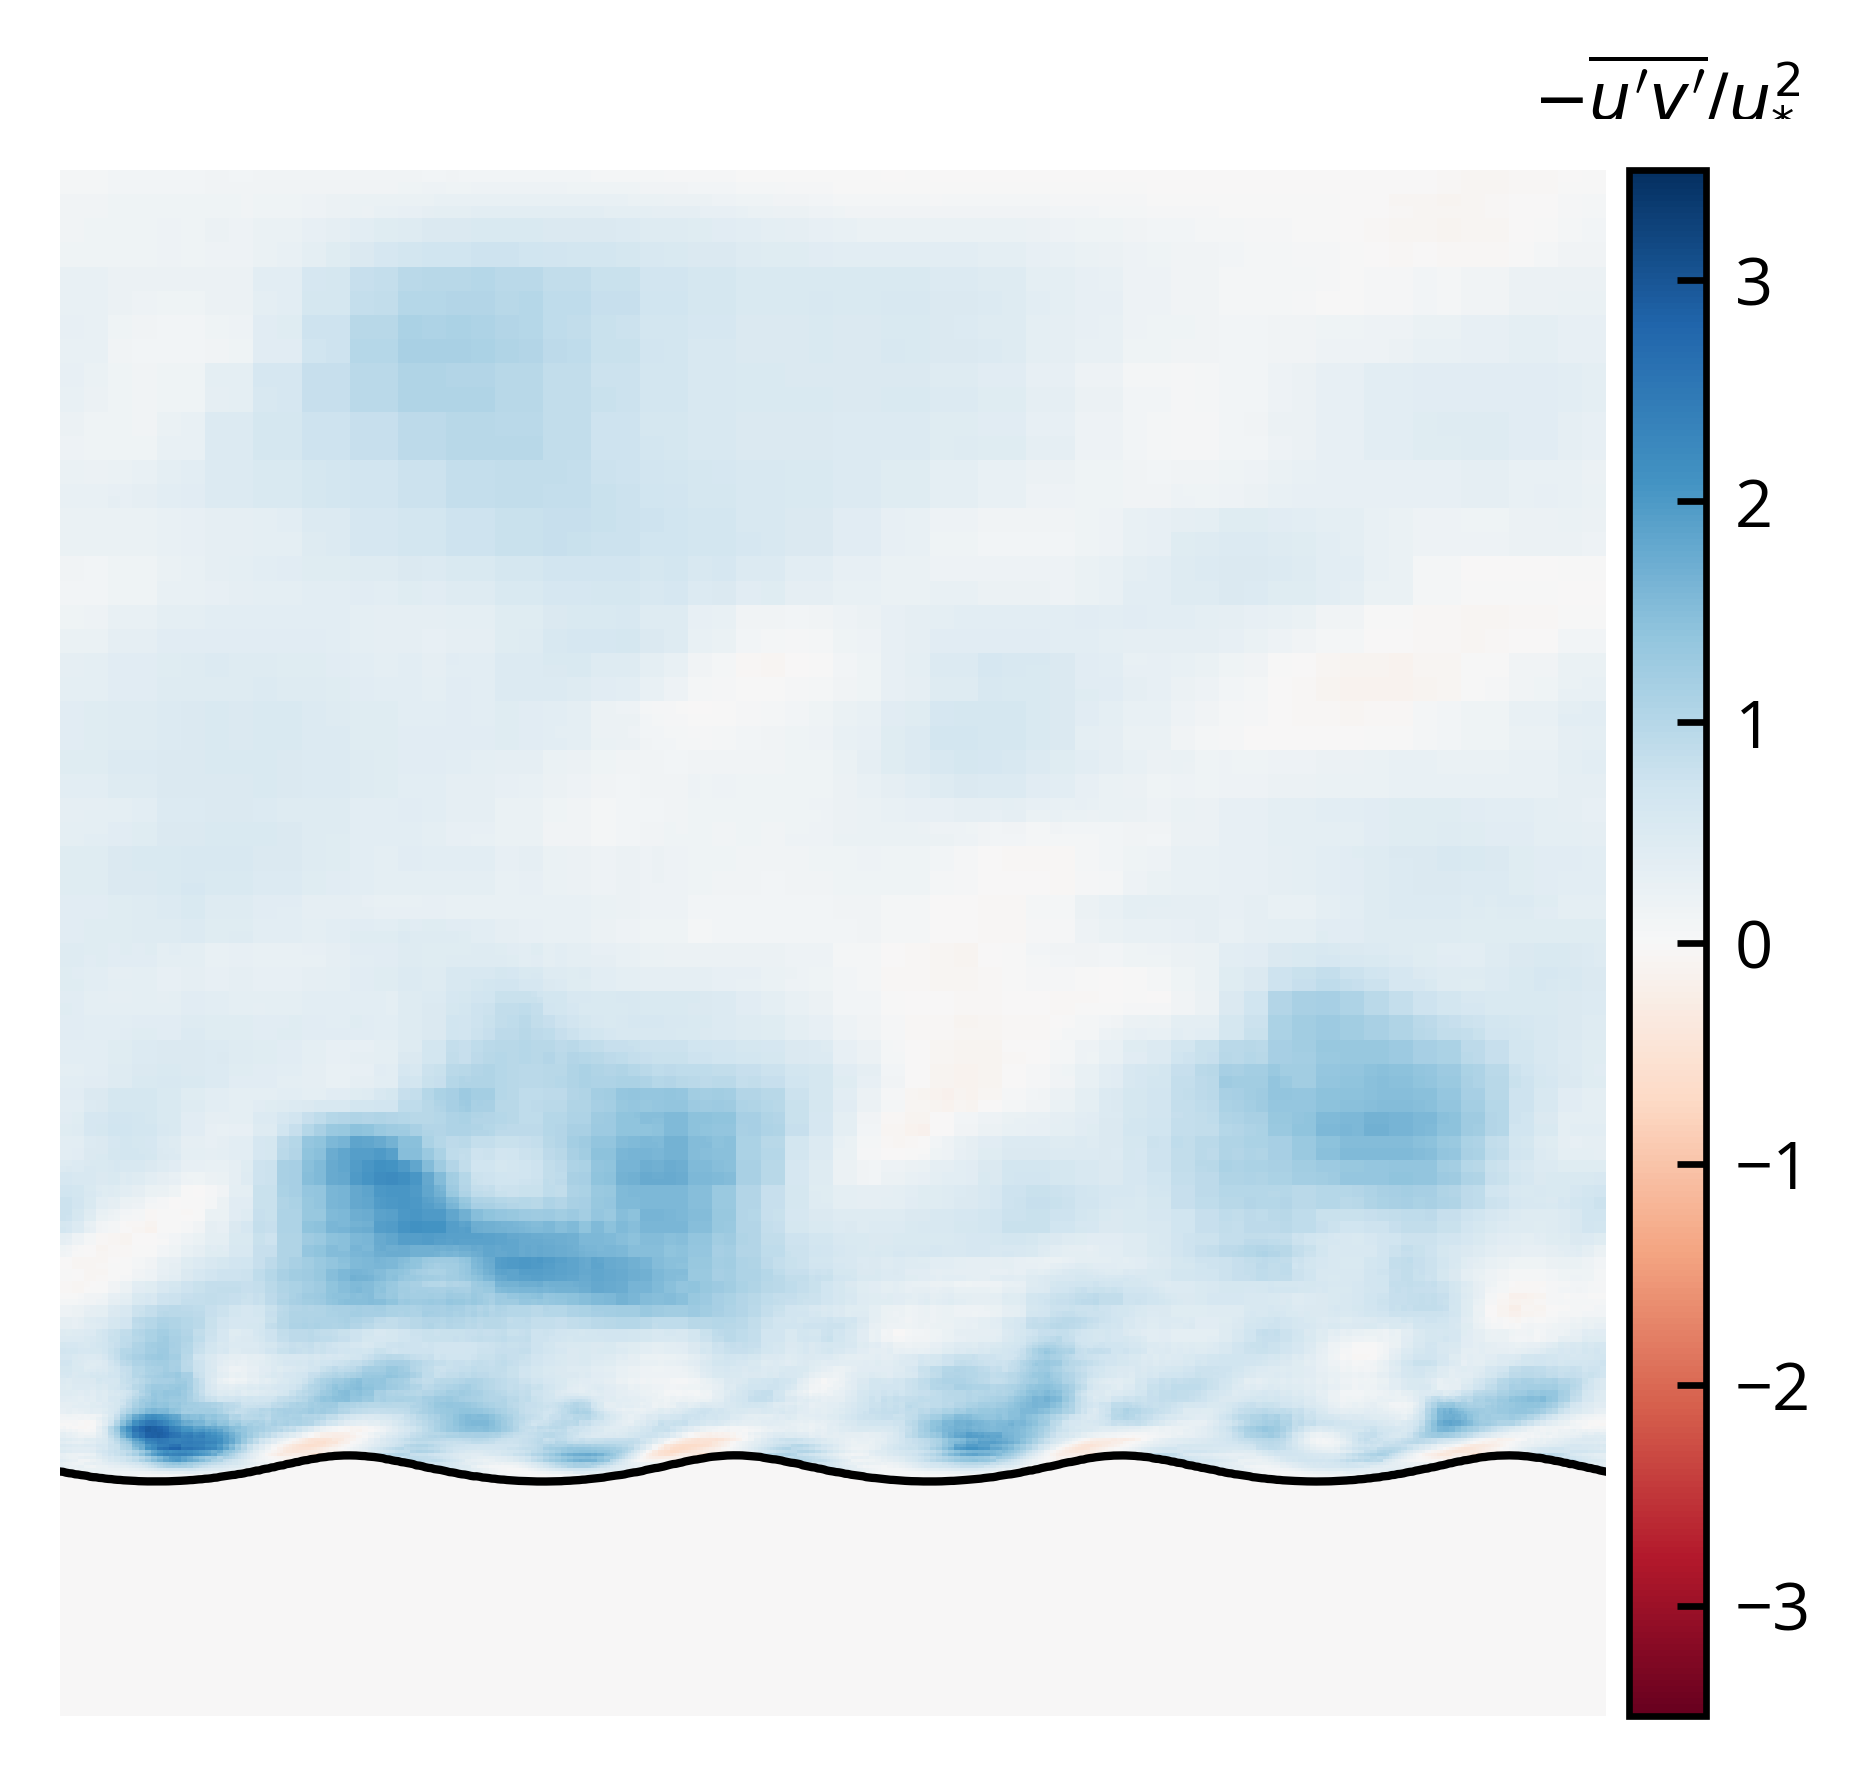

In [78]:
"""Visulization of Reynolds stress"""
fig = plt.figure(figsize=[4,3])
ax = plt.gca()
case = case2
t = 23
# case = case_pre
img = plt.imshow(np.rot90(-case.re_stress[t]*(1-case.f[t])/0.25**2), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = 3.5, vmin = -3.5)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
plt.plot(xarray, case.eta[t], c='k', lw=1)
cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
plt.axis('off')
cbar.ax.text(0.5, 1.05, r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^{2}$', ha='center', va='center', 
             transform=cbar.ax.transAxes)
fig.savefig('/home/jiarong/Downloads/ICTAM/Restress_g1.pdf')
# fig.savefig('/home/jiarong/Downloads/ICTAM/Restress_stationary.pdf')

Text(0.5, 1.05, '$\\overline{v}/u_{*}$')

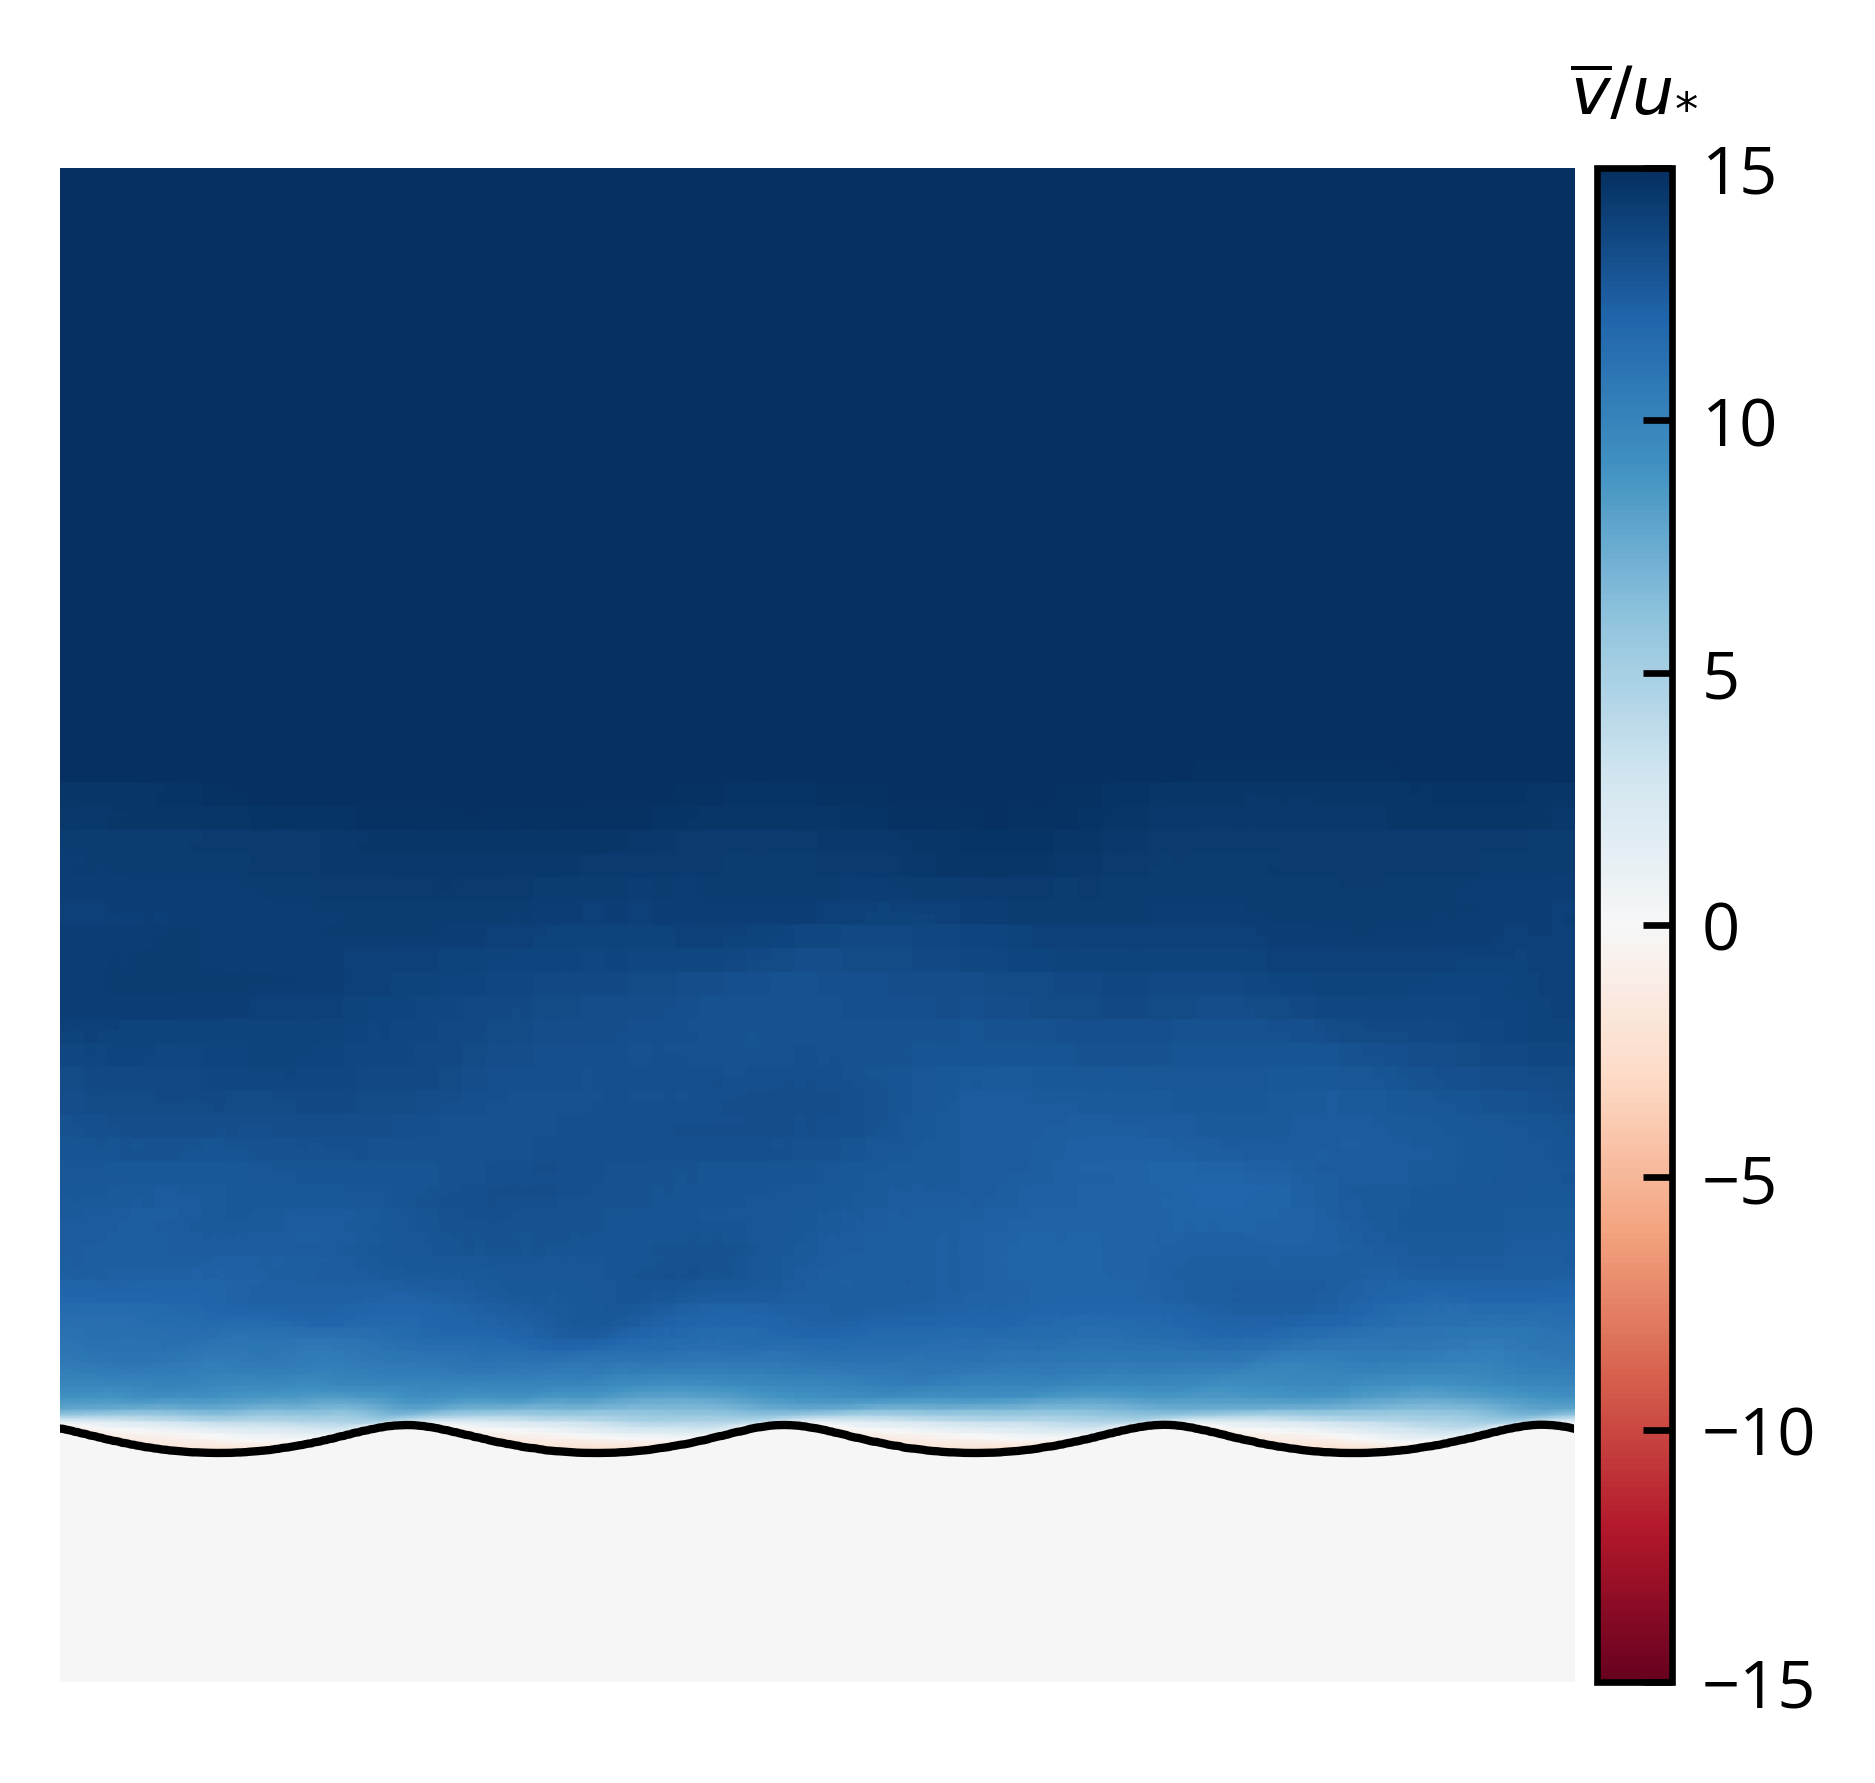

In [67]:
"""Visulization of ux"""
fig = plt.figure(figsize=[4,3])
ax = plt.gca()
t = 23 # One time snapshot
case = case1
# case = case_pre
img = plt.imshow(np.rot90((case.ux[t]-case.wave.c)*(1-case.f[t])/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = 15, vmin = -15)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
plt.plot(xarray, case.eta[t], c='k', lw=1)
cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
plt.axis('off')
cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
             transform=cbar.ax.transAxes)
# fig.savefig('/home/jiarong/Downloads/ICTAM/uy_g1.pdf')
# fig.savefig('/home/jiarong/Downloads/ICTAM/uy_stationary.pdf')

Text(0.5, 1.05, '$\\overline{v}/u_{*}$')

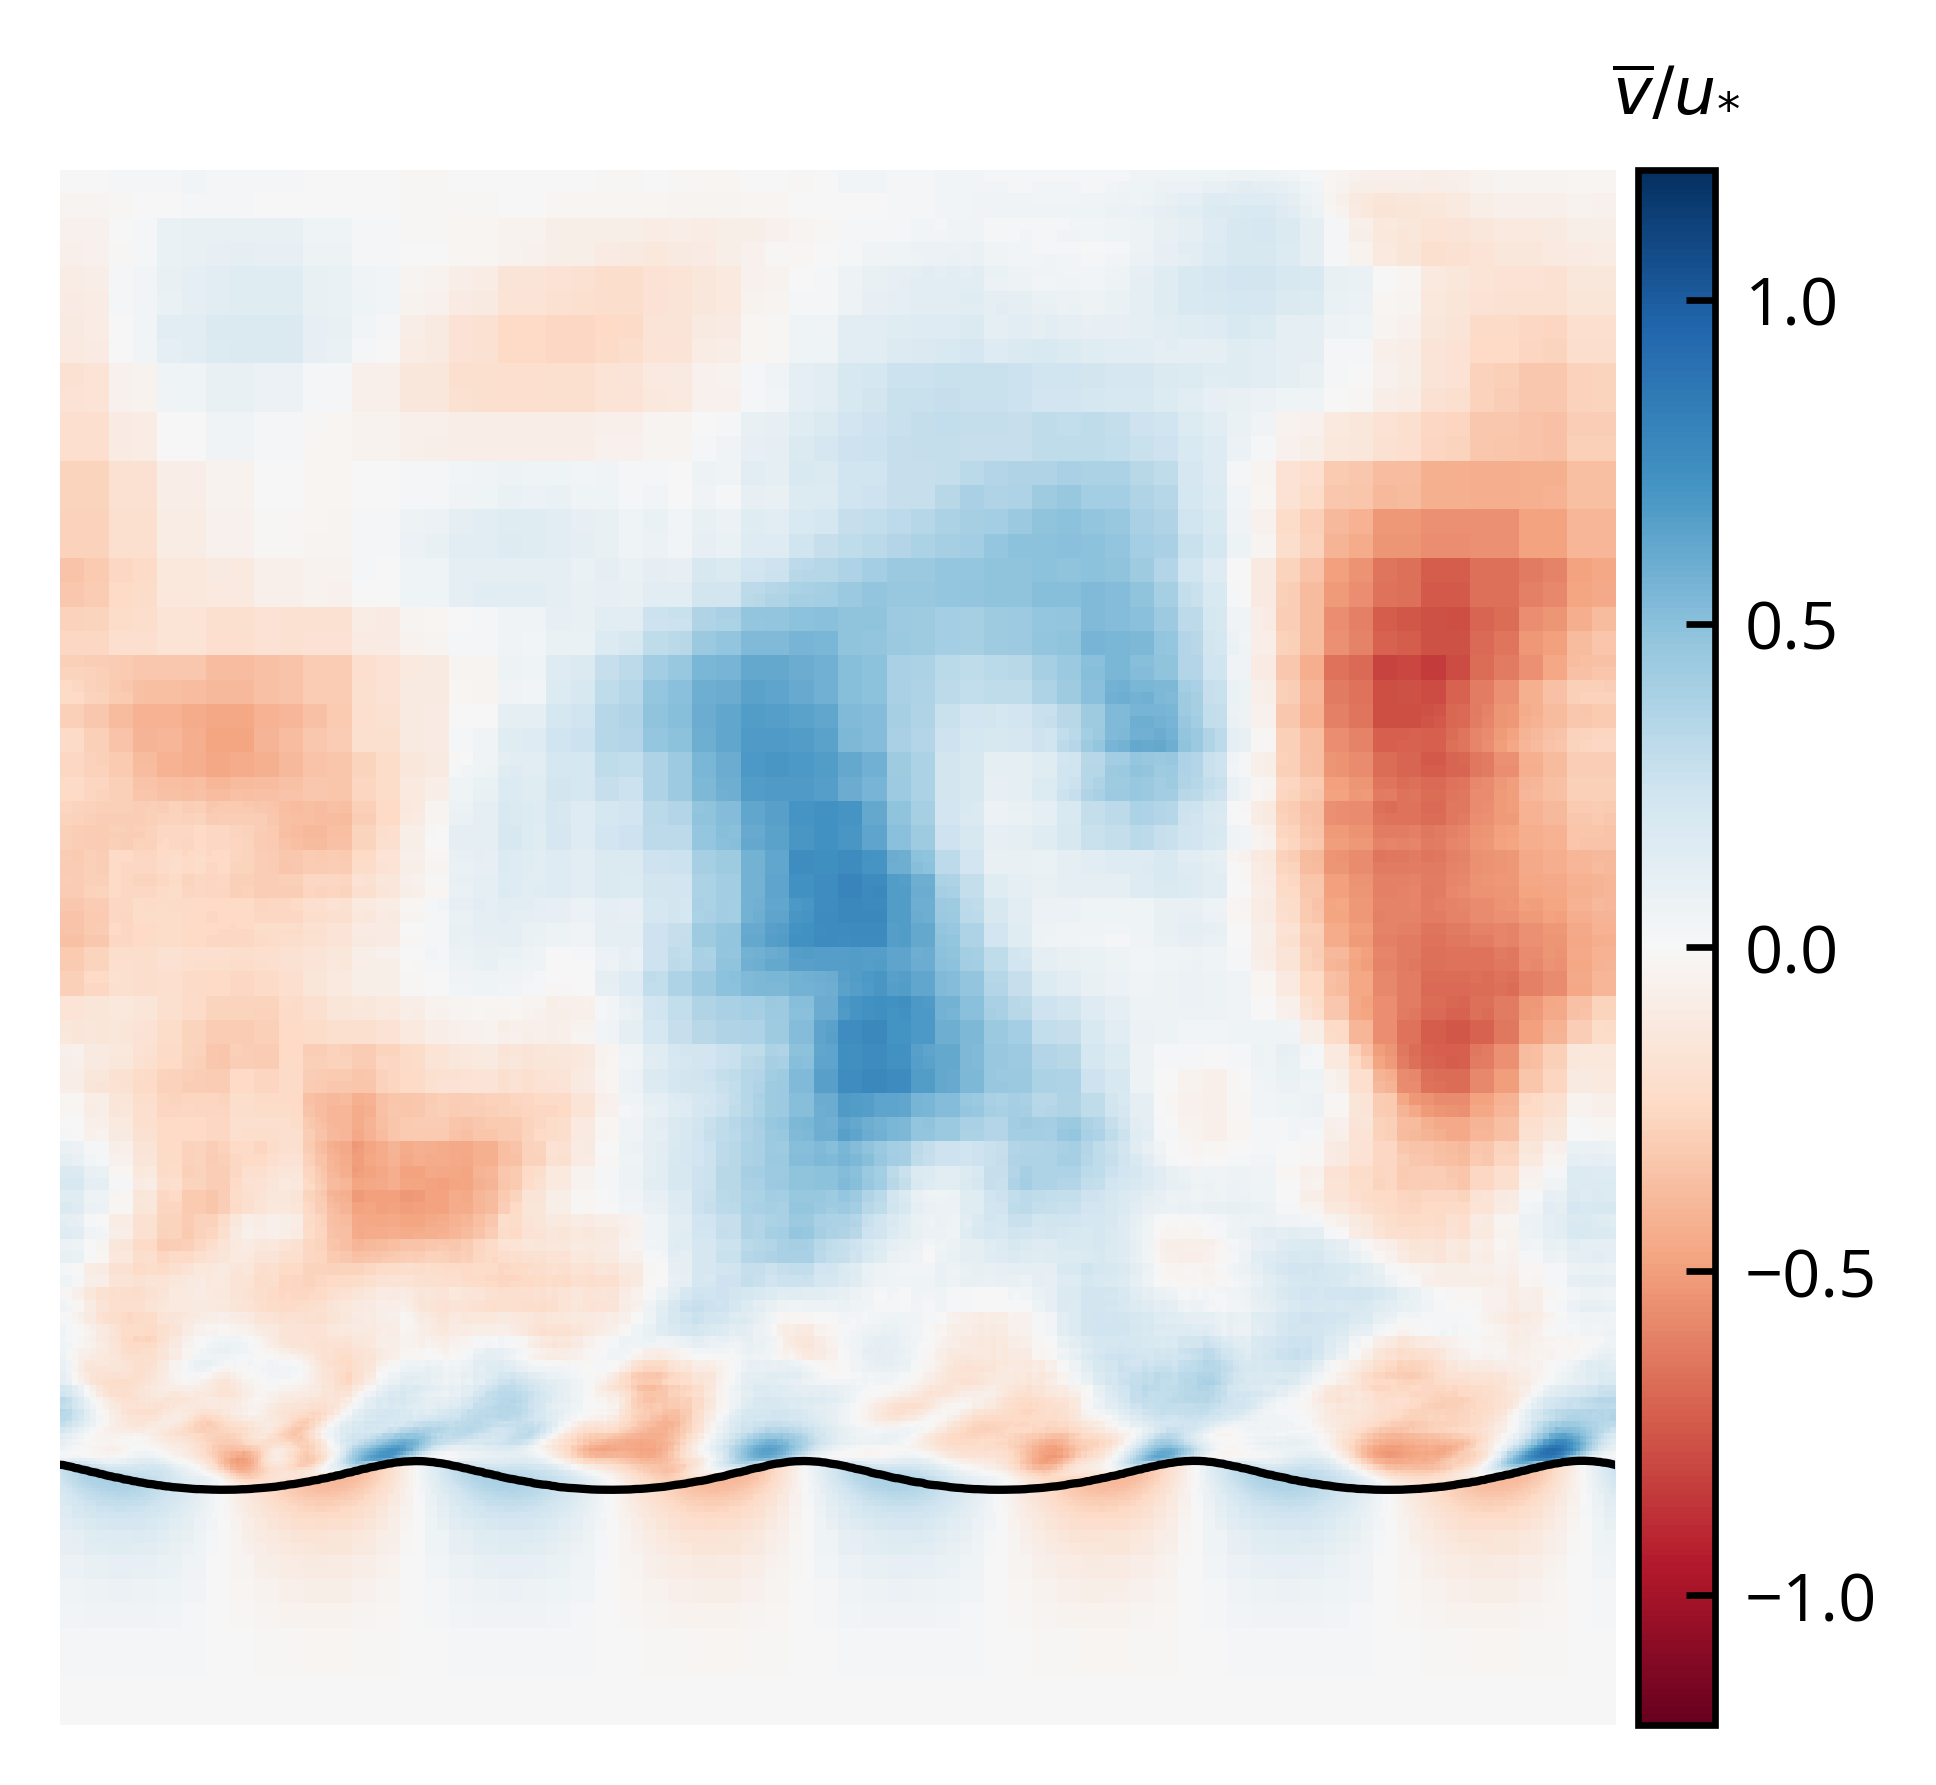

In [68]:
"""Visulization of uy"""
fig = plt.figure(figsize=[4,3])
ax = plt.gca()
t = 23 # One time snapshot
case = case1
# case = case_pre
img = plt.imshow(np.rot90(case.uy[t]/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = 1.2, vmin = -1.2)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
plt.plot(xarray, case.eta[t], c='k', lw=1)
cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
plt.axis('off')
cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
             transform=cbar.ax.transAxes)
# fig.savefig('/home/jiarong/Downloads/ICTAM/uy_g1.pdf')
# fig.savefig('/home/jiarong/Downloads/ICTAM/uy_stationary.pdf')

In [ ]:
"""Animate uy"""
from matplotlib import animation
from visualization import contour
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

# Single animation generation function
def plot_animation(animate_function, frame_number = 31, interval_time = 100):

    fig = plt.figure(figsize=[4,3])
    ax = plt.gca()
    t = 20 # One time snapshot
    case = case1
    # case = case_pre
    img = plt.imshow(np.rot90(-case.uy[t]/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                     vmax = 1.2, vmin = -1.2)
    NGRID = 512; NSLICE = 256; L0 = 2*np.pi
    xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
    plt.plot(xarray, case.eta[t], c='k', lw=1)
    cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
    plt.axis('off')
    cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
                 transform=cbar.ax.transAxes)

    # animation function.  This is called sequentially
    def animate(i):
        imgplot = animate_function(i, ax)
        return imgplot,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = True)  
    return anim

# Define the function called at every animation time to read in images
def plot_func(i, ax):
    ax.clear()
    case = case1
    # case = case_pre
    img = ax.imshow(np.rot90(-case.uy[i]/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                     vmax = 1.2, vmin = -1.2)
    NGRID = 512; NSLICE = 256; L0 = 2*np.pi
    xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
    plt.plot(xarray, case.eta[i], c='k', lw=1)
    cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
    plt.axis('off')
    cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
                 transform=cbar.ax.transAxes)
    return img

anim = plot_animation(plot_func, frame_number = 20, interval_time = 500) # Specify frame number
HTML(anim.to_html5_video())

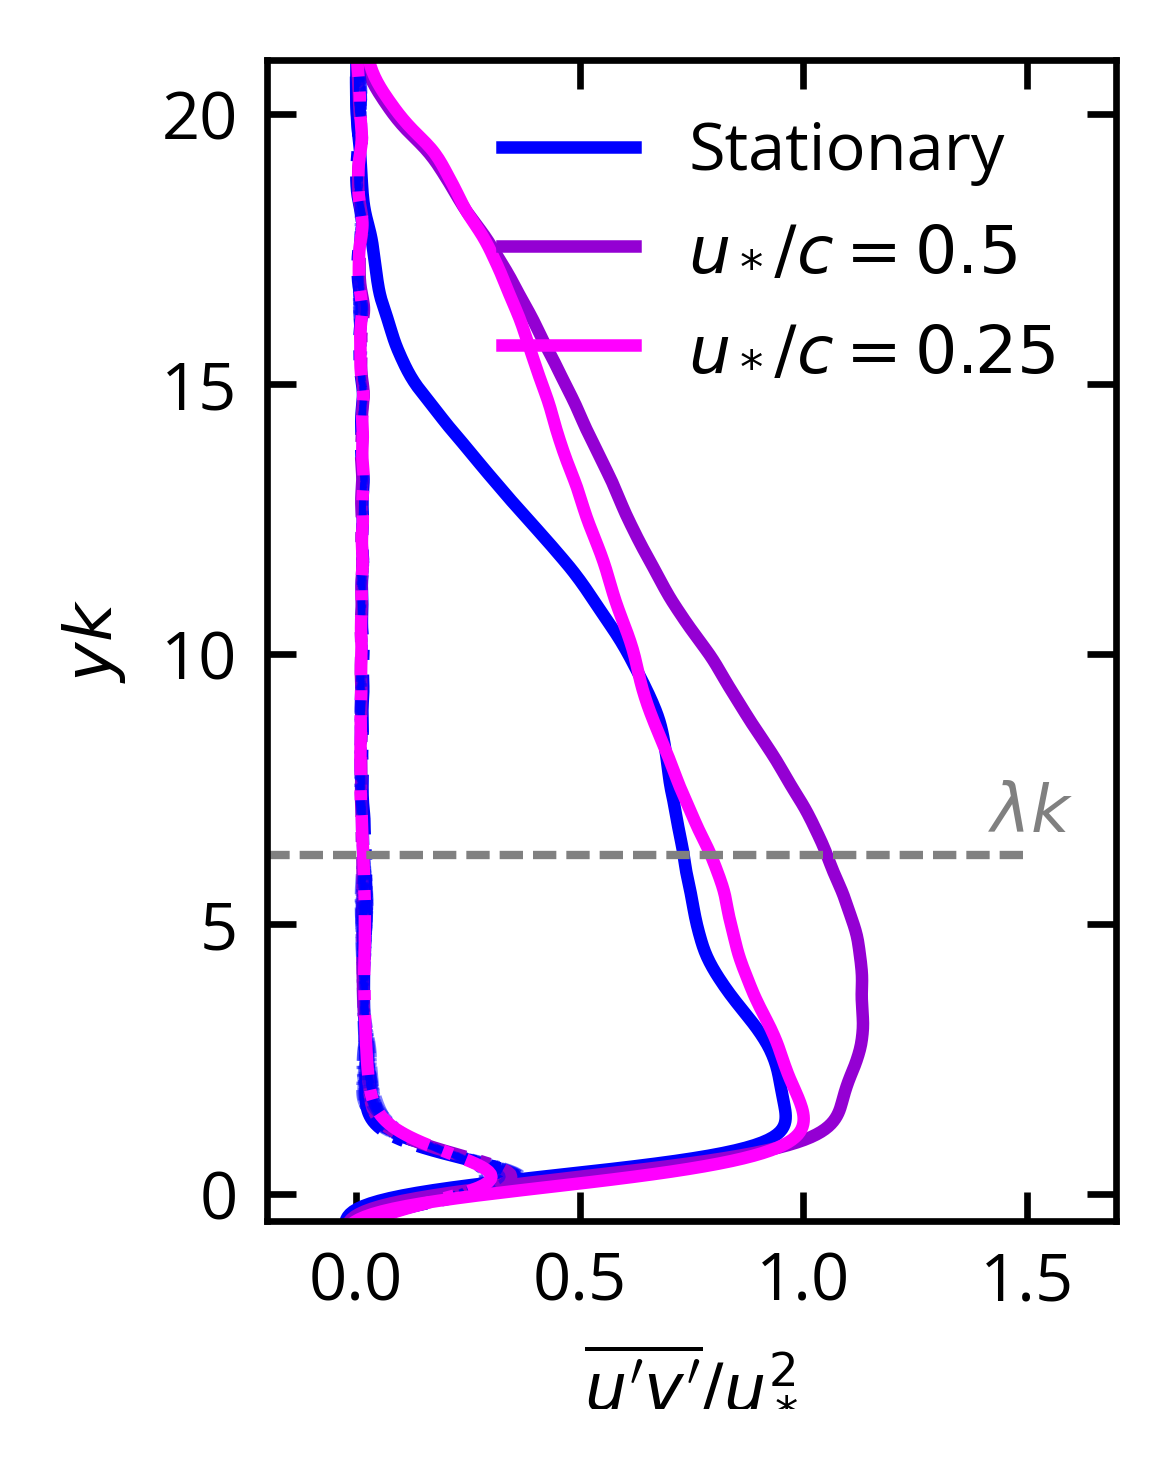

In [28]:
"""Plot 1D Reynolds stress profiles"""
fig = plt.figure(figsize=(2,2.5)); ax = plt.gca()

"""Plot the stationary wave case"""
case = case_pre
re1D = [] # Ensemble of Reynolds stress at different time
visc = [] # Ensemble of viscous shear stress at different time
nu_a = case.mu2/case.rho2
for (i,re2D) in enumerate(case.re_stress_shift):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
#     plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color='blue', alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    # Viscous stress
    ux_i = case.uxmean[i]
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
             color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)

plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, c='blue', label='Stationary')
plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', c='blue')

"""Plot the u*/c = 0.5 wave case"""
case = case1
re1D = []
visc = []
for (i,re2D) in enumerate(case.re_stress_shift[5:]):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
#     plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color=plt.cm.get_cmap('summer')(1-i/12), alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    ux_i = case.uxmean[i]
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
             color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)
    
plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, color='darkviolet', label=r'$u_*/c = 0.5$')
plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='darkviolet')

"""Plot the u*/c = 0.25 wave case"""
case = case2
re1D = []
visc = []
for (i,re2D) in enumerate(case.re_stress_shift[5:]):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
#     plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color=plt.cm.get_cmap('summer')(1-i/12), alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    ux_i = case.uxmean[i]
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
             color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)
    
# plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*k, color=plt.cm.get_cmap('summer')(0.5), label=r'$u_*/c = 0.25$')
# plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*k, '-.', color=plt.cm.get_cmap('summer')(0.5))
plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, color='magenta', label=r'$u_*/c = 0.25$')
plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='magenta')

"""Plot where the one wavelength height is."""
plt.plot(np.linspace(-0.5,1.5,100), np.ones(100)*2*np.pi, '--', c='gray',lw=1)
ax.text(0.9, 0.35, r'$\lambda k$', ha='center', va='center', color='gray', transform=ax.transAxes)
plt.xlabel('$\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel(r'$yk$')
plt.legend()
plt.ylim([-0.5,21])
plt.xlim([-0.2,1.7])
fig.savefig('/home/jiarong/Downloads/ICTAM/Restress1D_comparison.pdf')

In [53]:
(102-57)/(2*np.pi/case1.wave.omega)

14.359710089695845

(-0.2, 1.7)

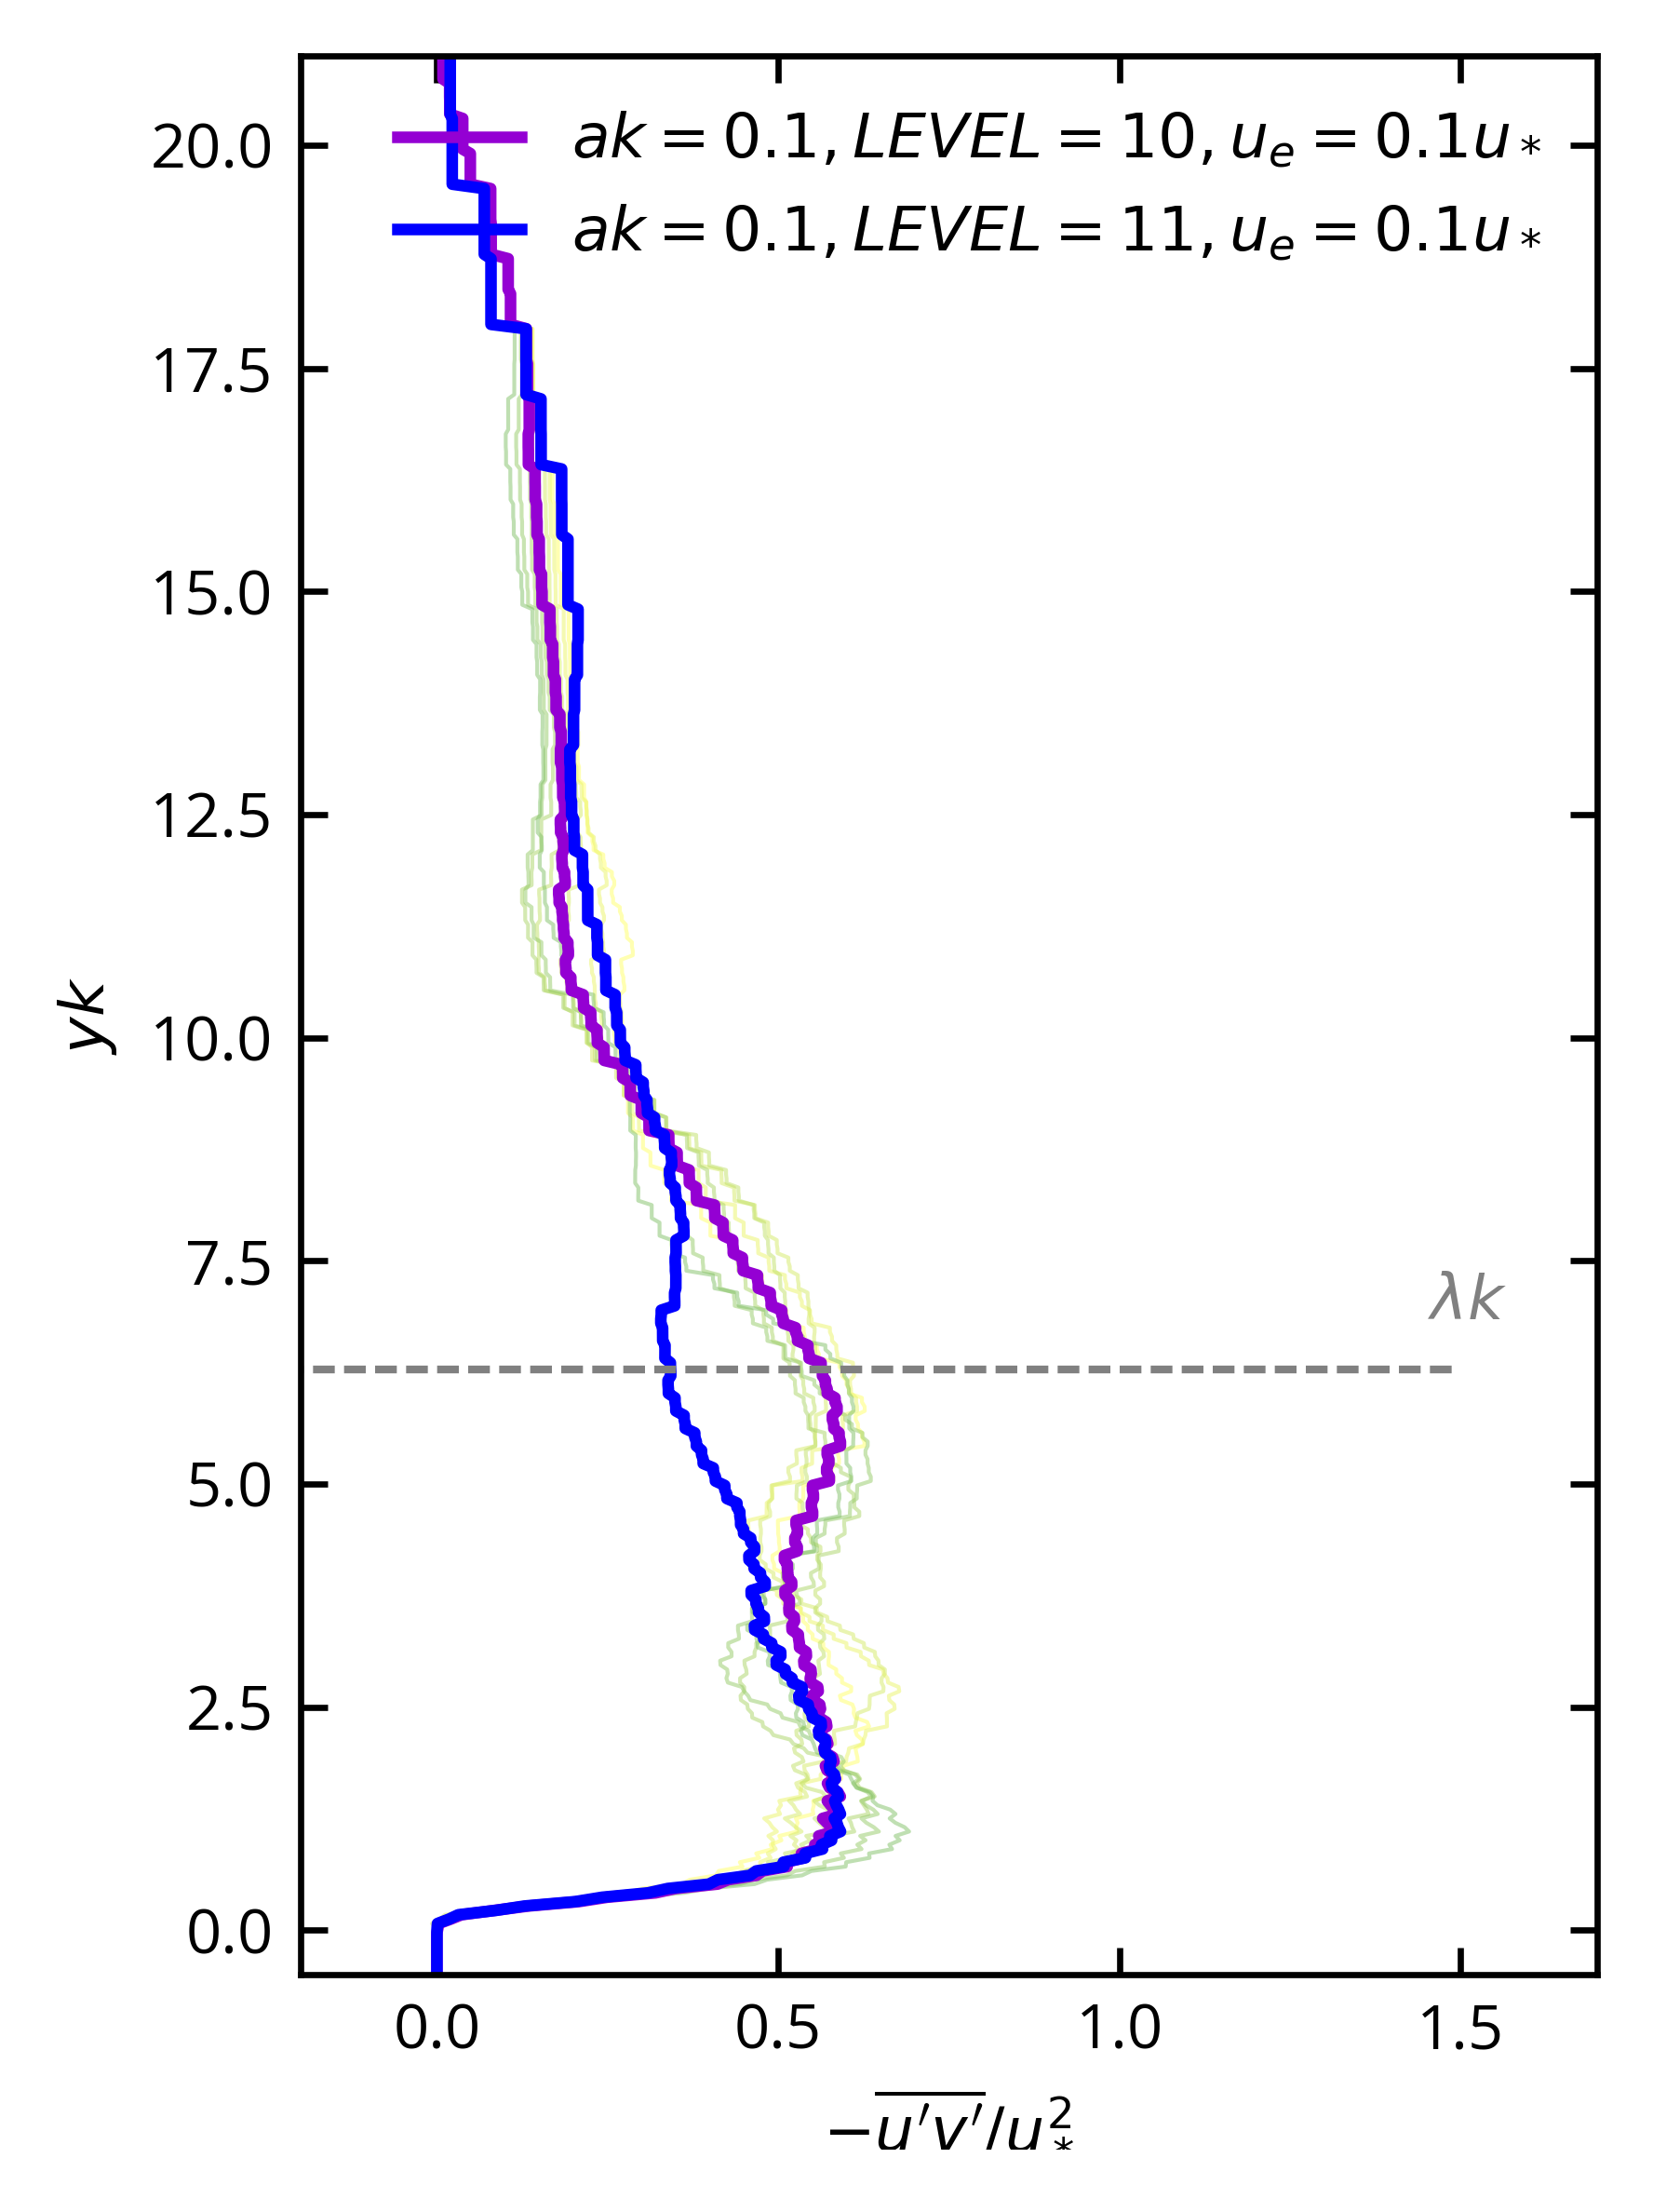

In [34]:
"""Plot 1D Reynolds stress profiles for STATIONARY cases."""
fig = plt.figure(figsize=(3,4)); ax = plt.gca()

"""ak=0.1"""
# case = case_pre2
# nu_a = case.mu2/case.rho2
# re1D = []
# visc = []
# for (i,re2D) in enumerate(case.re_stress):
#     # Reynolds stress
#     re_stress_i = -np.average(re2D, axis=0)
# #     re_stress_i = butter_lowpass_filter(re_stress_i)
#     plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(1-i/4), alpha=0.5, lw=0.5)
#     re1D.append(re_stress_i)
#     ux_i = case.uxmean[i]
# #     ux_i = butter_lowpass_filter(ux_i)
#     viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
# #     plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
# #              color='blue', alpha=0.5, lw=0.5)
#     visc.append(viscous_stress_i)
    
# plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, color='magenta', 
#          label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax))
# # plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='darkviolet')
# # plt.plot(np.average(visc, axis=0)/0.25**2+np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='darkviolet')

"""ak=0"""
case = case_pre4
nu_a = case.mu2/case.rho2
re1D = []
visc = []
for (i,re2D) in enumerate(case.re_stress[:]):
    # Reynolds stress
    re_stress_i = -np.average(re2D*(1-case.f[0]), axis=0)
#     re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(1-i/12), alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    ux_i = case.uxmean[i]
#     ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
#     plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
#              color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)    
    
plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, color='darkviolet', 
        label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax))
# plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='magenta')
# plt.plot(np.average(visc, axis=0)/0.25**2+np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='magenta')

"""ak = 0.2"""
case = case_pre6
re1D = [] # Ensemble of Reynolds stress at different time
visc = [] # Ensemble of viscous shear stress at different time
nu_a = case.mu2/case.rho2
for (i,re2D) in enumerate(case.re_stress):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
#     re_stress_i = butter_lowpass_filter(re_stress_i)
#     plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color='blue', alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    # Viscous stress
    ux_i = case.uxmean[i]
#     ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
#     plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
#              color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)

plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, c='blue',
        label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax))
# plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', c='blue')

"""Plot where the one wavelength height is."""
plt.plot(np.linspace(-0.5,1.5,100), np.ones(100)*2*np.pi, '--', c='gray',lw=1)
ax.text(0.9, 0.35, r'$\lambda k$', ha='center', va='center', color='gray', transform=ax.transAxes)
plt.xlabel('$-\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel(r'$yk$')
plt.legend(loc = "upper right")
plt.ylim([-0.5,21])
plt.xlim([-0.2,1.7])

(-0.2, 1.7)

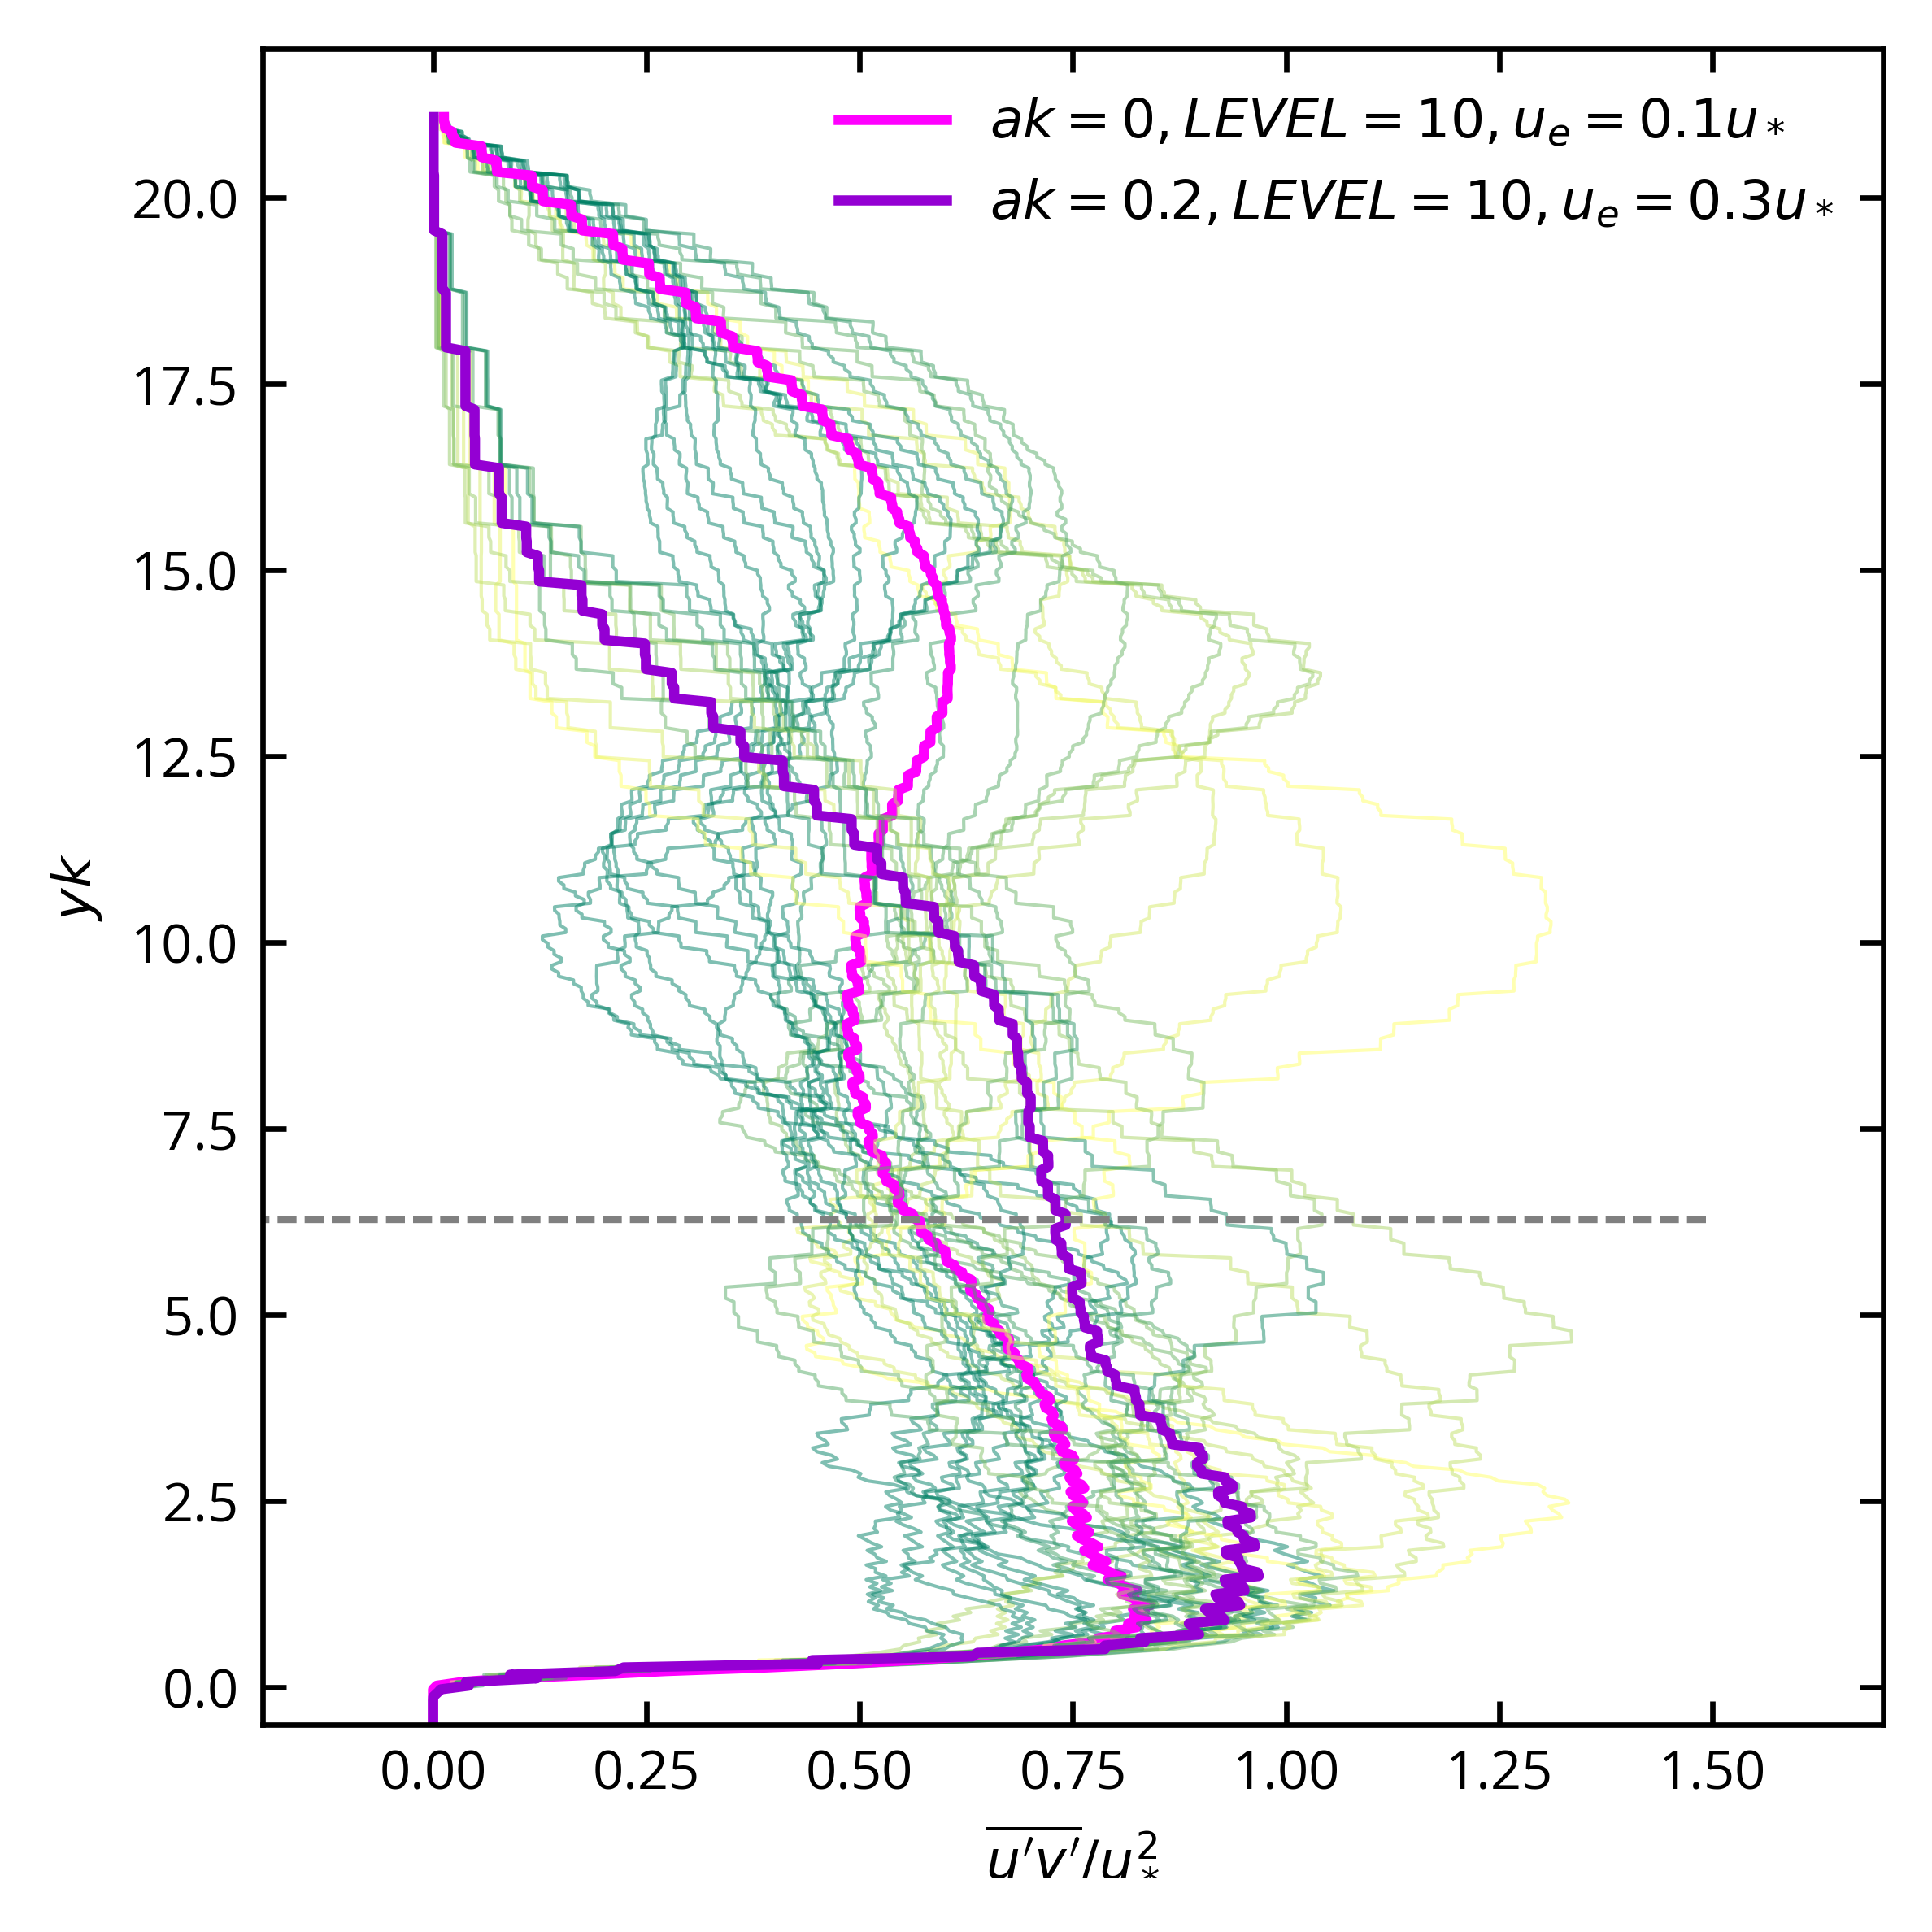

In [238]:
"""ak=0"""
case = case_pre5
re1D = []
visc = []
for (i,re2D) in enumerate(case.re_stress[:]):
    # Reynolds stress
    re_stress_i = -np.average(re2D*(1-case.f[0]), axis=0)
#     re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(1-i/12), alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    ux_i = case.uxmean[i]
#     ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
#     plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
#              color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)    
    
plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, color='magenta', 
        label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax))
# plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='magenta')
# plt.plot(np.average(visc, axis=0)/0.25**2+np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color='magenta')

case = case_pre1
re1D = []
visc = []
for (i,re2D) in enumerate(case.re_stress[:]):
    # Reynolds stress
    re_stress_i = -np.average(re2D*(1-case.f[0]), axis=0)
#     re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(1-i/12), alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    ux_i = case.uxmean[i]
#     ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
#     plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
#              color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)    
    
plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, color='darkviolet', 
        label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax))

"""Plot where the one wavelength height is."""
plt.plot(np.linspace(-0.5,1.5,100), np.ones(100)*2*np.pi, '--', c='gray',lw=1)
ax.text(0.9, 0.35, r'$\lambda k$', ha='center', va='center', color='gray', transform=ax.transAxes)
plt.xlabel('$\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel(r'$yk$')
plt.legend(loc = "upper right")
plt.ylim([-0.5,22])
plt.xlim([-0.2,1.7])

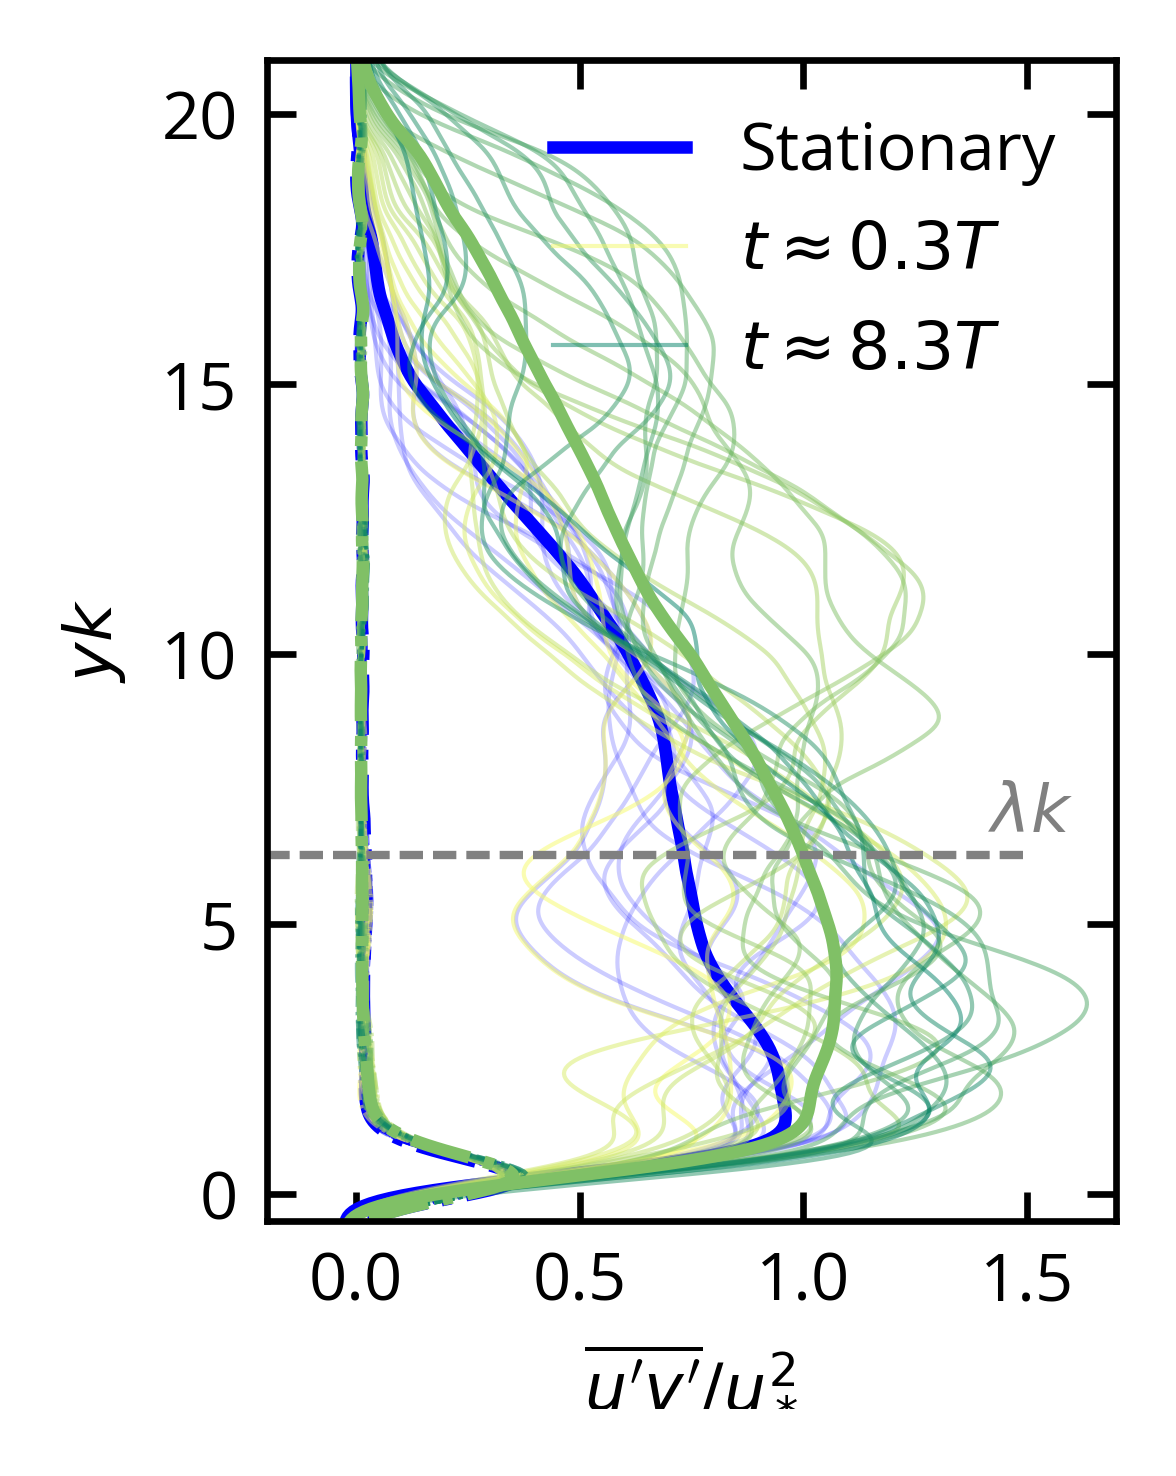

In [29]:
"""Plot 1D Reynolds stress profiles"""
fig = plt.figure(figsize=(2,2.5)); ax = plt.gca()

"""Plot the stationary wave case"""
case = case_pre
re1D = [] # Ensemble of Reynolds stress at different time
visc = [] # Ensemble of viscous shear stress at different time
nu_a = case.mu2/case.rho2
for (i,re2D) in enumerate(case.re_stress_shift):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color='blue', alpha=0.2, lw=0.5)
    re1D.append(re_stress_i)
    # Viscous stress
    ux_i = case.uxmean[i]
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
             color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)

plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, c='blue', label='Stationary')
plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', c='blue')

"""Plot the u*/c = 0.5 wave case"""
case = case1
re1D = []
visc = []
imax = 26
for (i,re2D) in enumerate(case.re_stress_shift[0:imax]):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    if i == 0:
        plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(0.95), 
                 label = r'$t \approx 0.3T$', alpha=0.5, lw=0.5)
    elif i == imax-1:
        plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(0), 
                 label = r'$t \approx 8.3T$', alpha=0.5, lw=0.5)     
    else:
        plt.plot(re_stress_i/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(1-i/imax), alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    ux_i = case.uxmean[i]
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*case.k, '-.', 
             color=plt.cm.get_cmap('summer')(1-i/26), alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)
    
plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*case.k, color=plt.cm.get_cmap('summer')(0.5))
plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*case.k, '-.', color=plt.cm.get_cmap('summer')(0.5))

"""Plot where the one wavelength height is."""
plt.plot(np.linspace(-0.5,1.5,100), np.ones(100)*2*np.pi, '--', c='gray',lw=1)
ax.text(0.9, 0.35, r'$\lambda k$', ha='center', va='center', color='gray', transform=ax.transAxes)
plt.xlabel('$\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel(r'$yk$')
plt.legend()
plt.ylim([-0.5,21])
plt.xlim([-0.2,1.7])
fig.savefig('/home/jiarong/Downloads/ICTAM/Restress1D_g1.pdf')

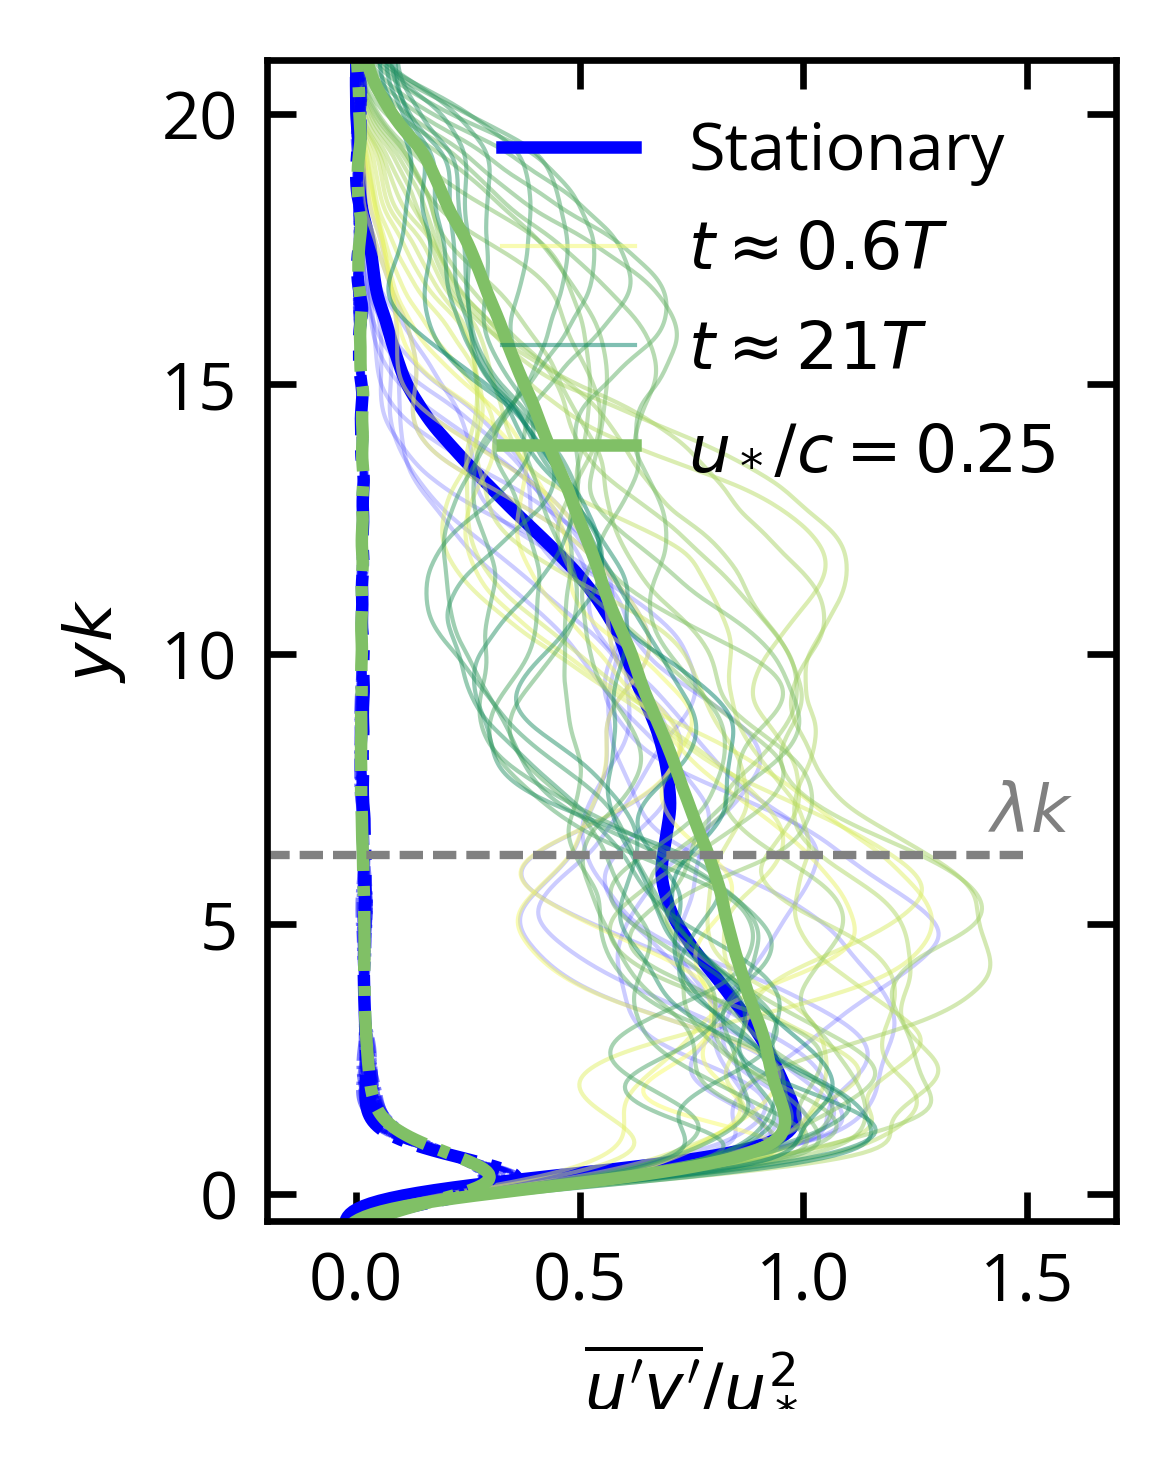

In [275]:
"""Plot 1D Reynolds stress profiles"""
fig = plt.figure(figsize=(2,2.5)); ax = plt.gca()

"""Plot the stationary wave case"""
case = case_pre
re1D = [] # Ensemble of Reynolds stress at different time
visc = [] # Ensemble of viscous shear stress at different time
nu_a = case.mu2/case.rho2
for (i,re2D) in enumerate(case.re_stress_shift):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color='blue', alpha=0.2, lw=0.5)
    re1D.append(re_stress_i)
    # Viscous stress
    ux_i = case.uxmean[i]
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*k, '-.', 
             color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)

plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*k, c='blue', label='Stationary')
plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*k, '-.', c='blue')

"""Plot the u*/c = 0.25 wave case"""
case = case2
re1D = []
visc = []
imax = 32
for (i,re2D) in enumerate(case.re_stress_shift[0:imax]):
    # Reynolds stress
    re_stress_i = -np.average(re2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    if i == 0:
        plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color=plt.cm.get_cmap('summer')(0.95), 
                 label = r'$t \approx 0.6T$', alpha=0.5, lw=0.5)
    elif i == imax-1:
        plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color=plt.cm.get_cmap('summer')(0), 
                 label = r'$t \approx 21T$', alpha=0.5, lw=0.5)     
    else:
        plt.plot(re_stress_i/0.25**2, (case.yarray-1)*k, color=plt.cm.get_cmap('summer')(1-i/imax), alpha=0.5, lw=0.5)
    re1D.append(re_stress_i)
    ux_i = case.uxmean[i]
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(case.yarray[1]-case.yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (case.yarray-1)*k, '-.', 
             color='blue', alpha=0.5, lw=0.5)
    visc.append(viscous_stress_i)
    
plt.plot(np.average(re1D, axis=0)/0.25**2, (case.yarray-1)*k, color=plt.cm.get_cmap('summer')(0.5), label=r'$u_*/c = 0.25$')
plt.plot(np.average(visc, axis=0)/0.25**2, (case.yarray-1)*k, '-.', color=plt.cm.get_cmap('summer')(0.5))

"""Plot where the one wavelength height is."""
plt.plot(np.linspace(-0.5,1.5,100), np.ones(100)*2*np.pi, '--', c='gray',lw=1)
ax.text(0.9, 0.35, r'$\lambda k$', ha='center', va='center', color='gray', transform=ax.transAxes)
plt.xlabel('$\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel(r'$yk$')
plt.legend()
plt.ylim([-0.5,21])
plt.xlim([-0.2,1.7])
# fig.savefig('/home/jiarong/Downloads/ICTAM/Restress1D_g4.pdf')

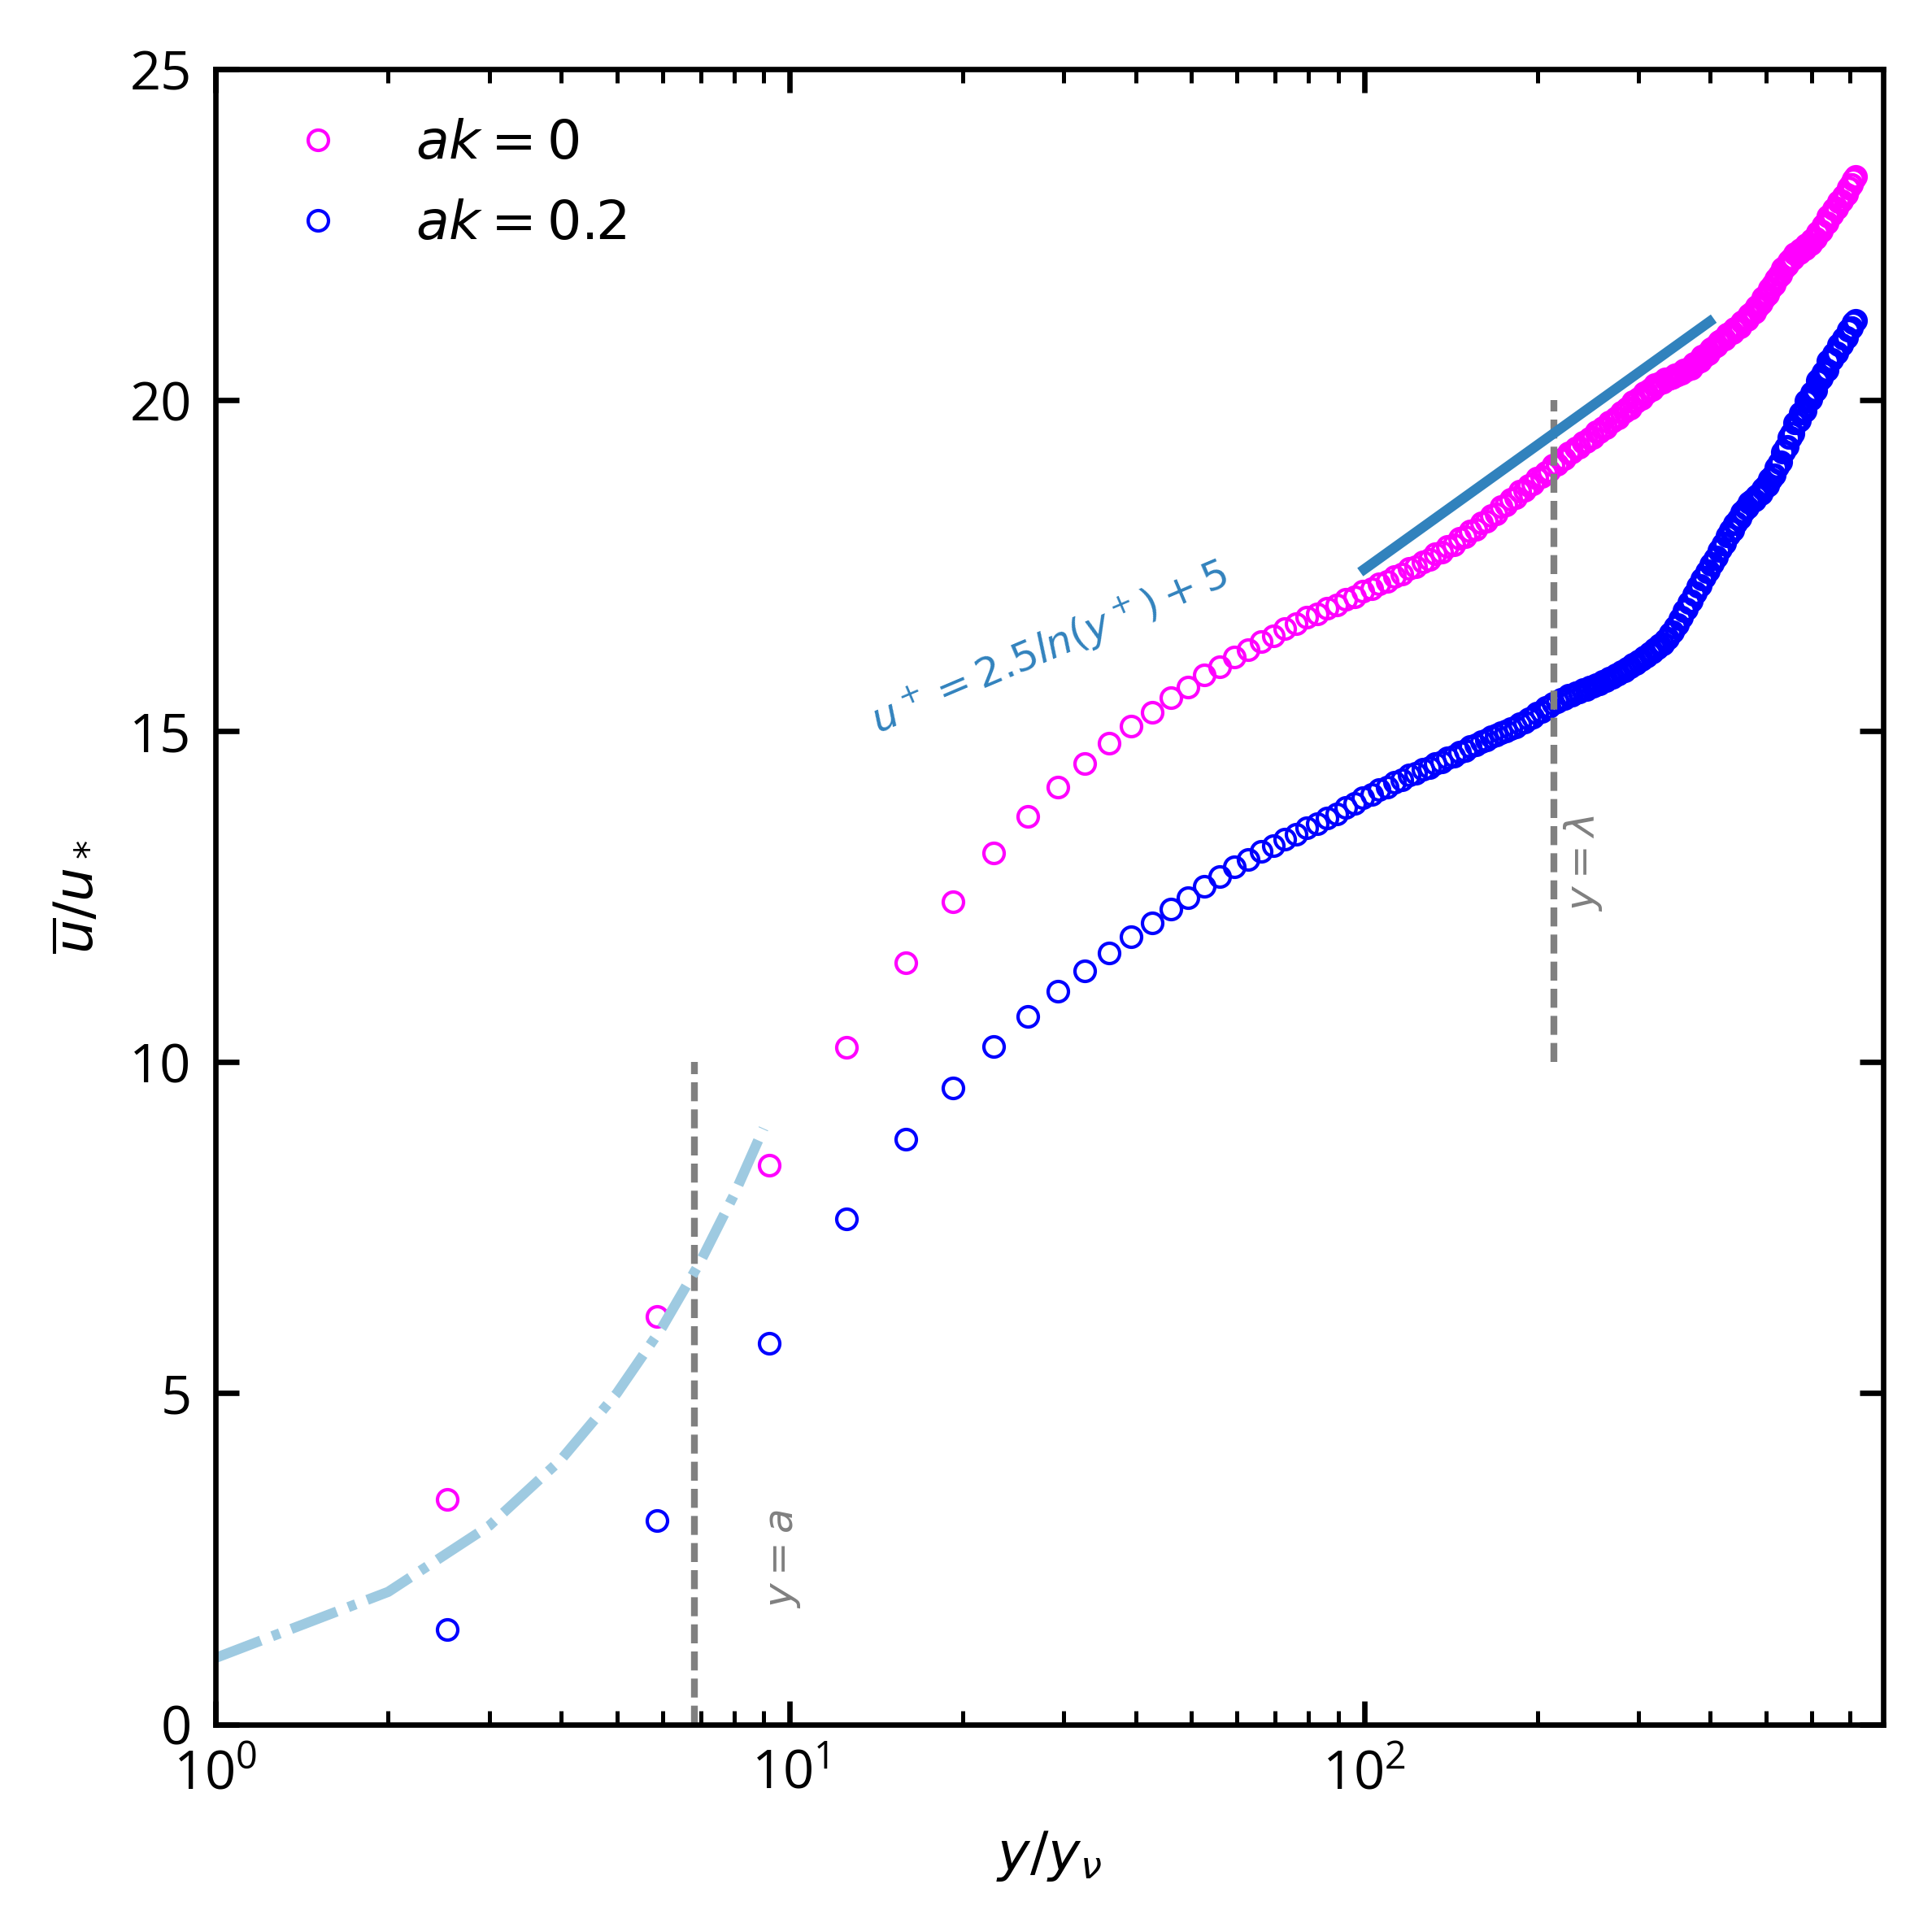

In [199]:
"""Plot the average water profile for the STATIONARY wave cases."""

fig = plt.figure(figsize=[4,4]); ax = plt.gca()

"""The stationary wave case"""

case = case_pre5
ytau = (2*np.pi-1)/case.Retau

for i in range(0,20):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#     plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
#              color=plt.cm.get_cmap('summer')(1-i/10))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g$' %(case.ak), color='magenta') 


# case = case_pre4
# ytau = (2*np.pi-1)/case.Retau
# case.ustar = (0.25**2*(2*np.pi-1)/(2*np.pi-1-0.2/4))**0.5
# for i in range(0,10):
#     case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#     plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
#              color=plt.cm.get_cmap('summer')(1-i/10))
# plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
#          marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
#          label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='darkviolet') 

case = case_pre7
for i in range(0,5):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#     plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
#              color=plt.cm.get_cmap('summer')(1-i/12))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean[5:], axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g$' %(case.ak), color='blue') 

# case = case_pre6
# ytau = (2*np.pi-1)/case.Retau
# for i in range(0,4):
#     case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#     plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
#              color=plt.cm.get_cmap('summer')(1-i/10))
# plt.plot((case.yarray[29:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[29:-1:2]/case.ustar, 
#          marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
#          label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='blue') 

plt.plot(np.ones(100)*(0.2/4)/ytau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/ytau, np.linspace(10,20,100), '--', c='gray',lw=1)
ax.text(0.34, 0.1, r'$y=a$', ha='center', va='center', rotation=90., fontsize=6, 
        c='gray', transform=ax.transAxes)
ax.text(0.82, 0.52, r'$y=\lambda$', ha='center', va='center', rotation=90., fontsize=6, 
        c='gray', transform=ax.transAxes)


y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
y = np.arange(100,400)
plt.plot(y, 1/0.37*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
# plt.plot(y, 1/0.41*np.log(y)+6, color=plt.get_cmap('tab20c')(0))
# ax.text(0.1, 0.15, r'$u^+=y^+$', ha='center', va='center', rotation=15., fontsize=6, 
#         color=plt.get_cmap('tab20c')(2), transform=ax.transAxes)
ax.text(0.5, 0.65, r'$u^+=2.5ln(y^+)+5$', ha='center', va='center', rotation=23, fontsize=6,
        color=plt.get_cmap('tab20c')(0), transform=ax.transAxes)
plt.xscale('log')
plt.ylim([0, 25])
plt.xlim([1, 800])
plt.ylabel(r'$\overline{u}/u_*$') 
plt.xlabel(r'$y/y_{\nu}$') 
plt.legend(loc='upper left')
# fig.savefig('/home/jiarong/Downloads/ICTAM/loglaw_g1.pdf')

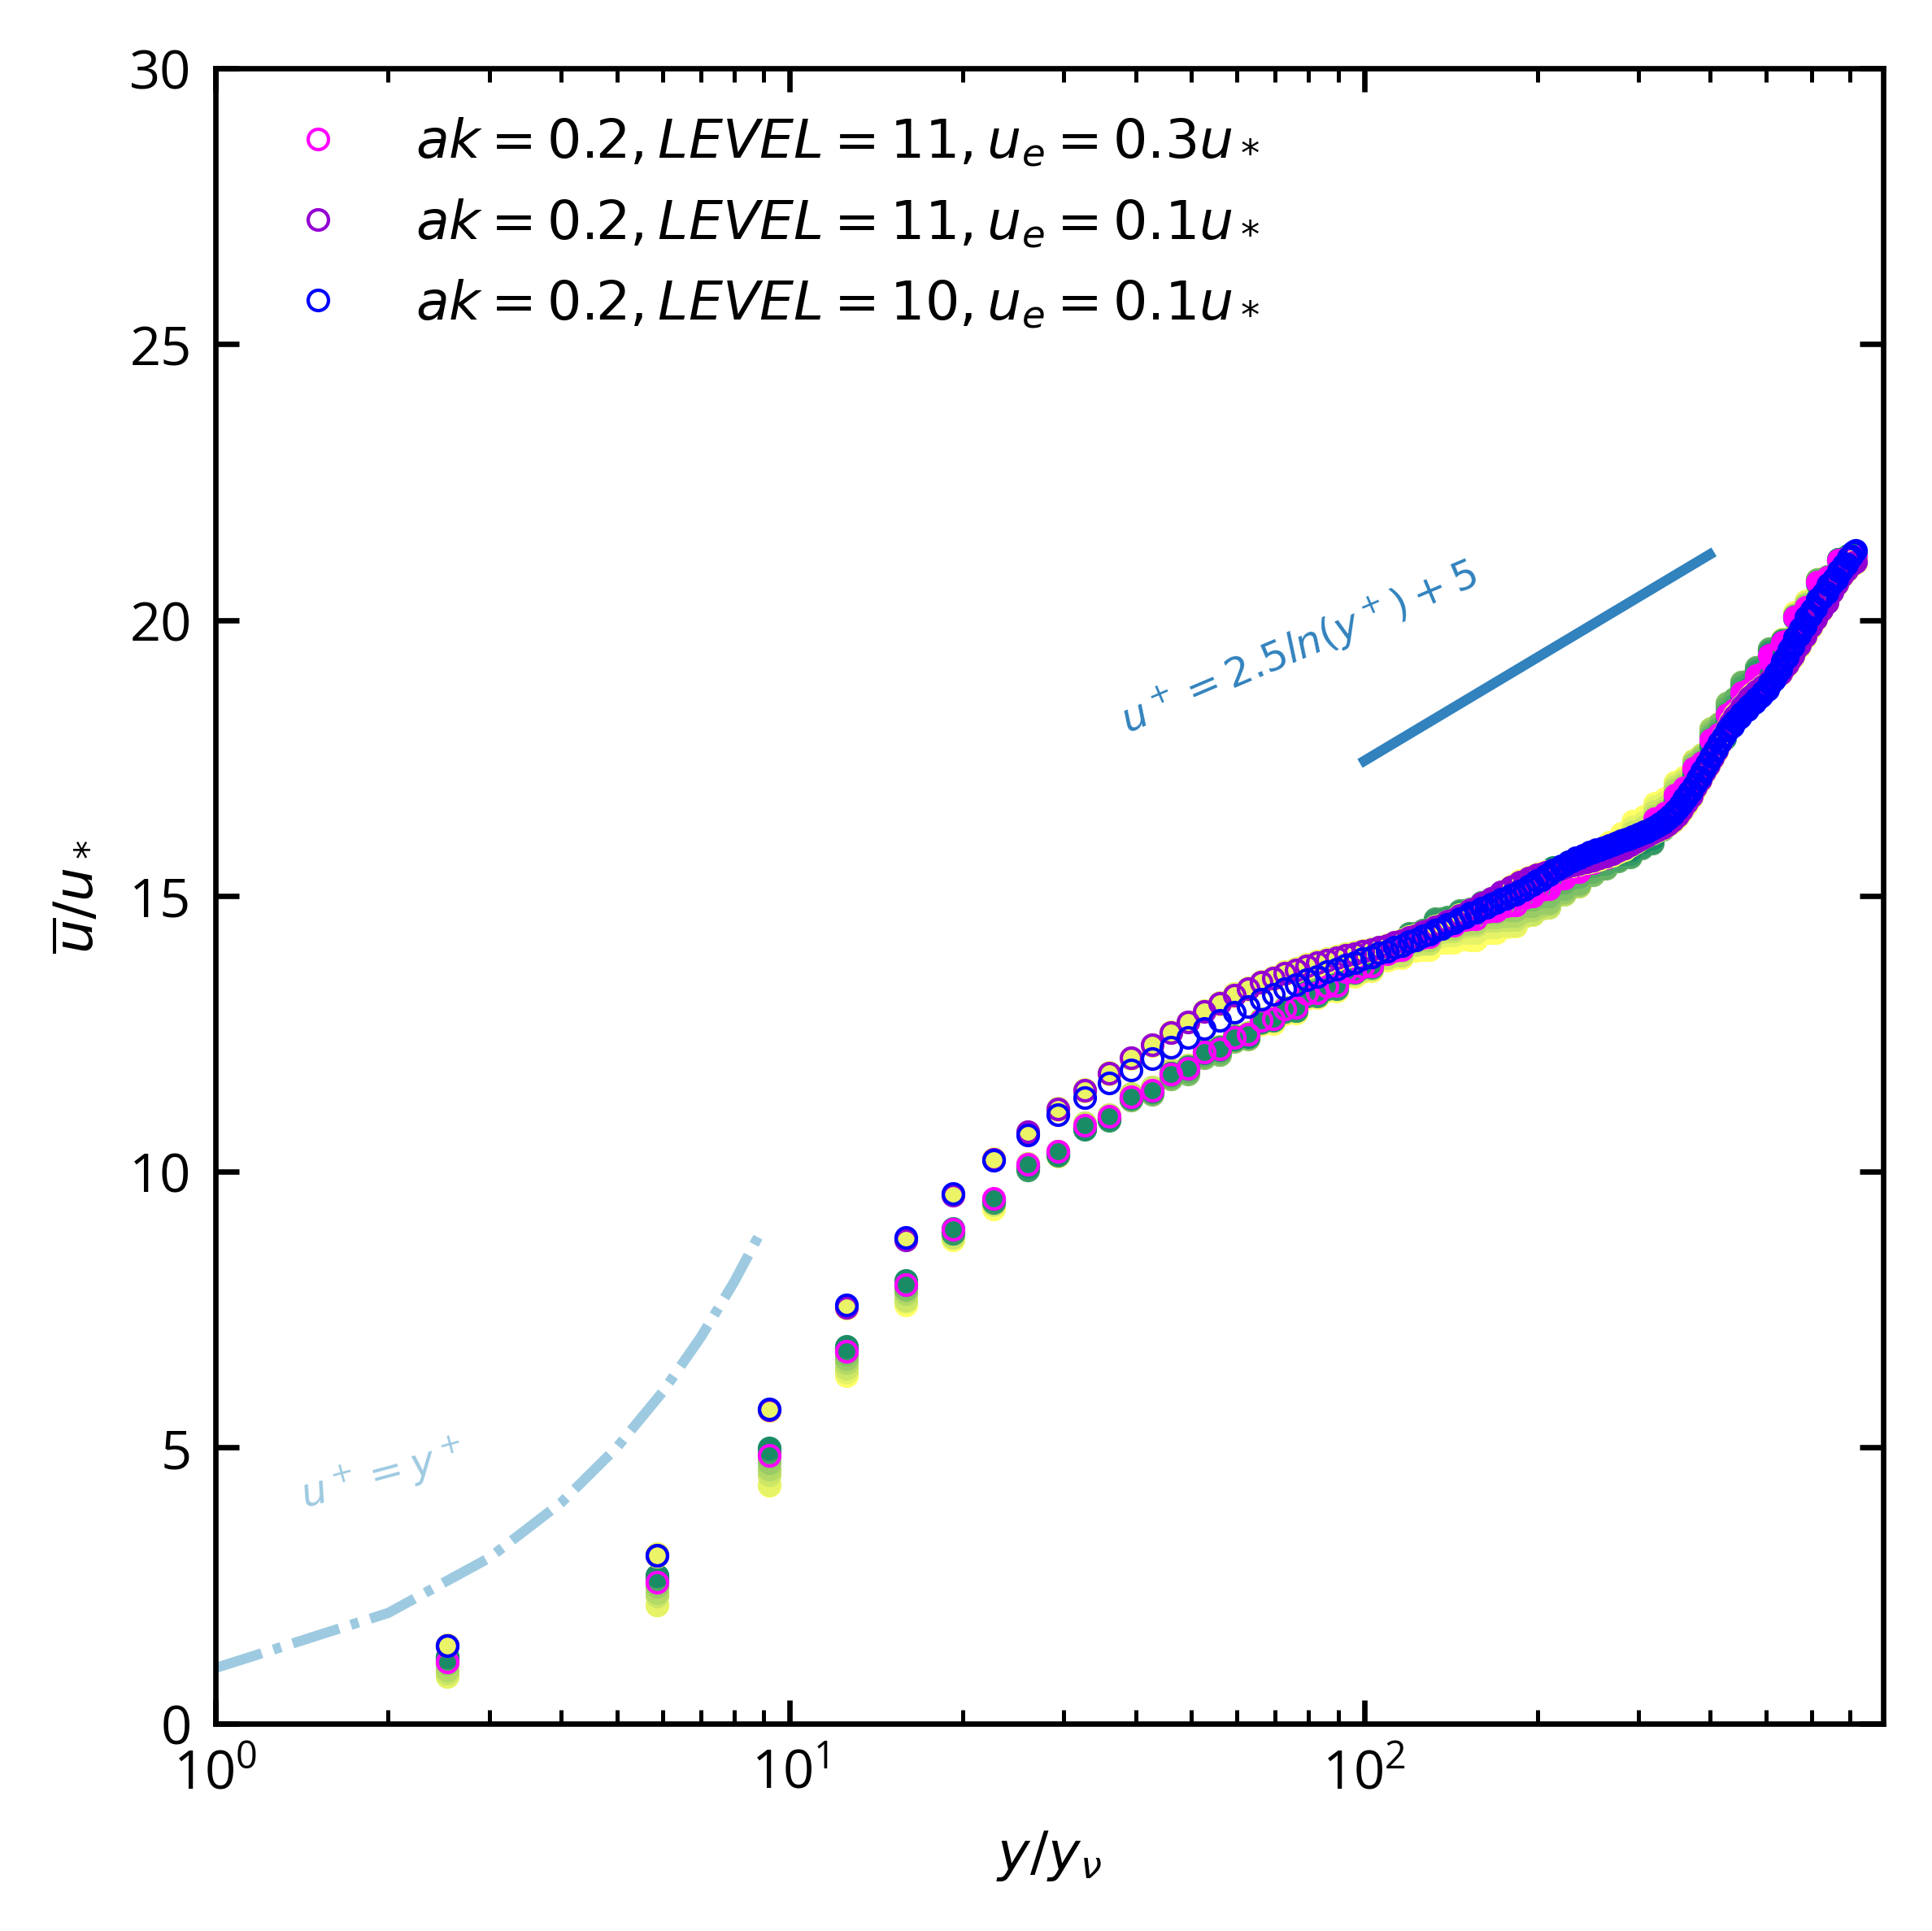

In [19]:
"""Plot the average water profile for the STATIONARY wave cases."""

fig = plt.figure(figsize=[4,4]); ax = plt.gca()

"""The stationary wave case"""

case = case_pre8
ytau = (2*np.pi-1)/case.Retau
for i in range(0,10):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
             color=plt.cm.get_cmap('summer')(1-i/10))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='magenta') 

case = case_pre9
for i in range(0,2):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
             color=plt.cm.get_cmap('summer')(1-i/12))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean[:], axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='darkviolet') 

case = case_pre7
ytau = (2*np.pi-1)/case.Retau
for i in range(0,4):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#     plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
#              color=plt.cm.get_cmap('summer')(1-i/10))
plt.plot((case.yarray[29:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[29:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='blue') 


y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
y = np.arange(100,400)
plt.plot(y, 1/0.37*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
# plt.plot(y, 1/0.41*np.log(y)+6, color=plt.get_cmap('tab20c')(0))
ax.text(0.1, 0.15, r'$u^+=y^+$', ha='center', va='center', rotation=15., fontsize=6, 
        color=plt.get_cmap('tab20c')(2), transform=ax.transAxes)
ax.text(0.65, 0.65, r'$u^+=2.5ln(y^+)+5$', ha='center', va='center', rotation=23, fontsize=6,
        color=plt.get_cmap('tab20c')(0), transform=ax.transAxes)
plt.xscale('log')
plt.ylim([0, 30])
plt.xlim([1, 800])
plt.ylabel(r'$\overline{u}/u_*$') 
plt.xlabel(r'$y/y_{\nu}$') 
plt.legend(loc='upper left')
# fig.savefig('/home/jiarong/Downloads/ICTAM/loglaw_g1.pdf')

AttributeError: 'Case' object has no attribute 'uxmean'

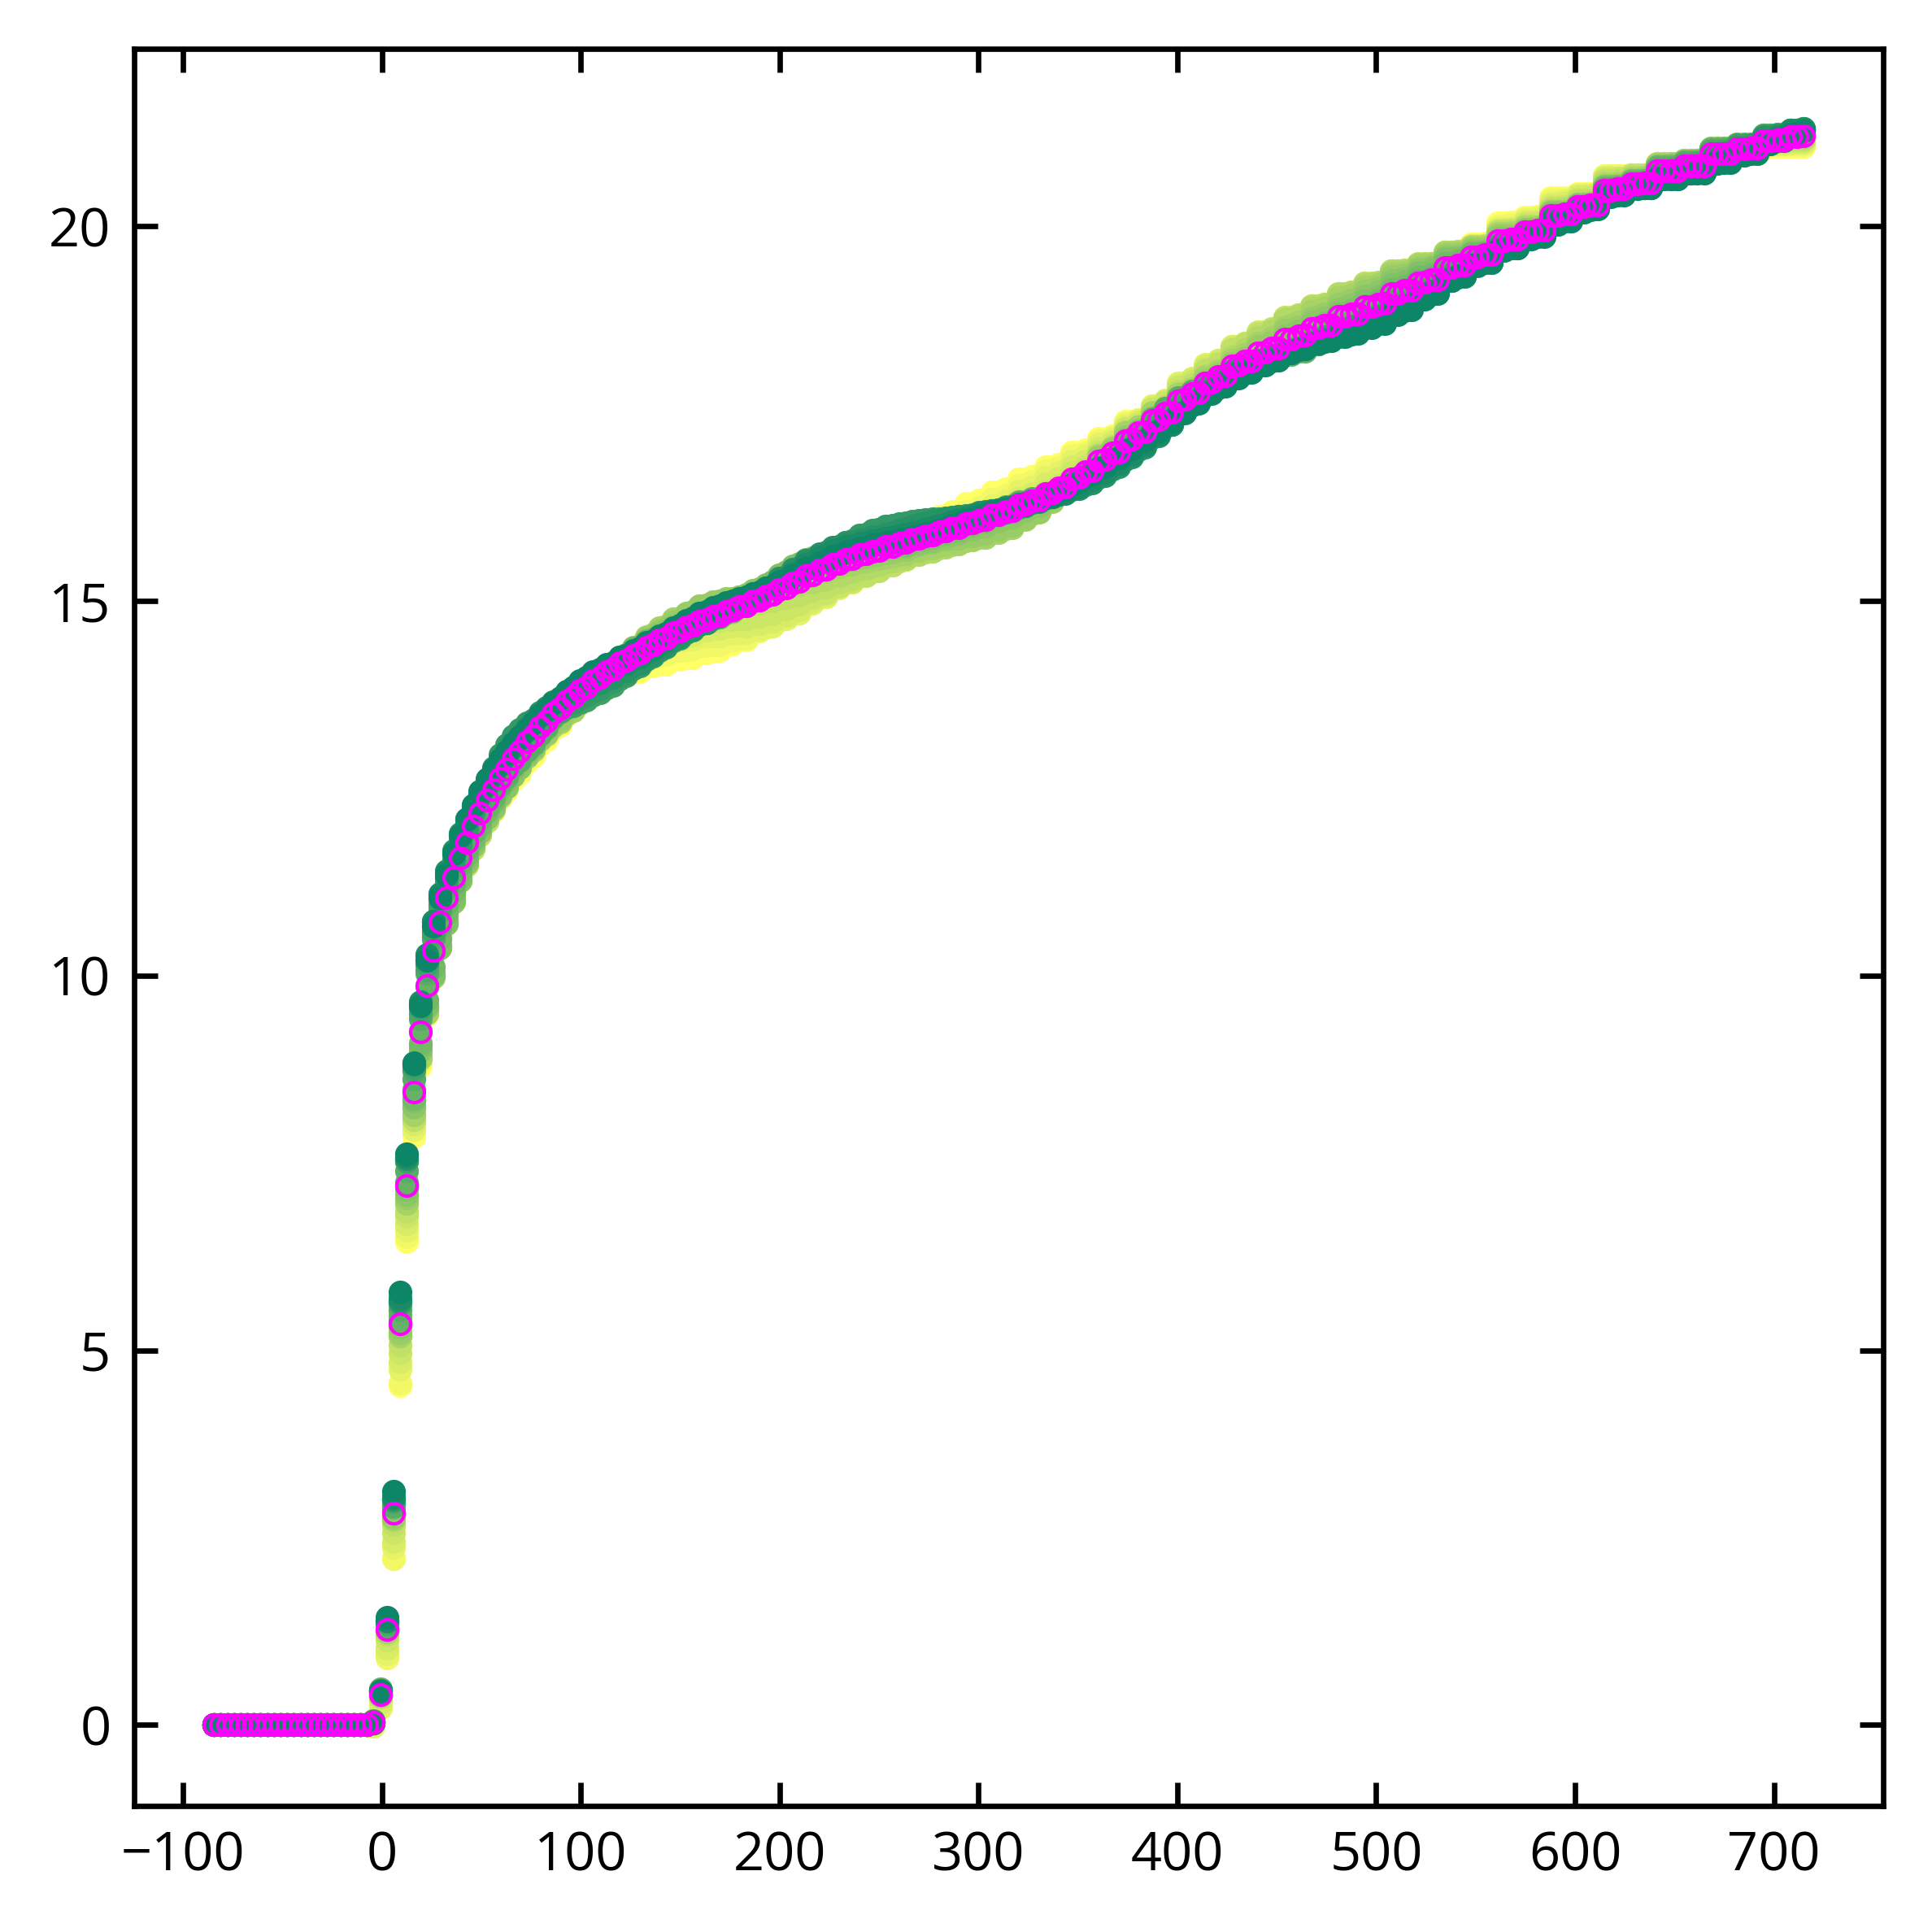

In [163]:
"""Plot the average water profile for the STATIONARY wave cases."""

fig = plt.figure(figsize=[4,4]); ax = plt.gca()

"""The stationary wave case"""

case = case_pre7
ytau = (2*np.pi-1)/case.Retau
for i in range(0,20):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
             color=plt.cm.get_cmap('summer')(1-i/20))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='magenta') 

case = case_pre2
for i in range(0,15):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
             color=plt.cm.get_cmap('summer')(1-i/15))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean[5:], axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='darkviolet') 

case = case_pre5
ytau = (2*np.pi-1)/case.Retau
for i in range(0,20):
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', 
             color=plt.cm.get_cmap('summer')(1-i/10))
plt.plot((case.yarray[29:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[29:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$ak=%g, LEVEL=%g, u_e=%gu_*$' %(case.ak,case.LEVEL,case.emax), color='blue') 

y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
y = np.arange(100,400)
plt.plot(y, 1/0.37*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
# plt.plot(y, 1/0.41*np.log(y)+6, color=plt.get_cmap('tab20c')(0))
ax.text(0.1, 0.15, r'$u^+=y^+$', ha='center', va='center', rotation=15., fontsize=6, 
        color=plt.get_cmap('tab20c')(2), transform=ax.transAxes)
ax.text(0.65, 0.65, r'$u^+=2.5ln(y^+)+5$', ha='center', va='center', rotation=23, fontsize=6,
        color=plt.get_cmap('tab20c')(0), transform=ax.transAxes)
plt.xscale('log')
plt.ylim([0, 30])
plt.xlim([1, 800])
plt.ylabel(r'$\overline{u}/u_*$') 
plt.xlabel(r'$y/y_{\nu}$') 
plt.legend(loc='upper left')
# fig.savefig('/home/jiarong/Downloads/ICTAM/loglaw_g1.pdf')

No handles with labels found to put in legend.


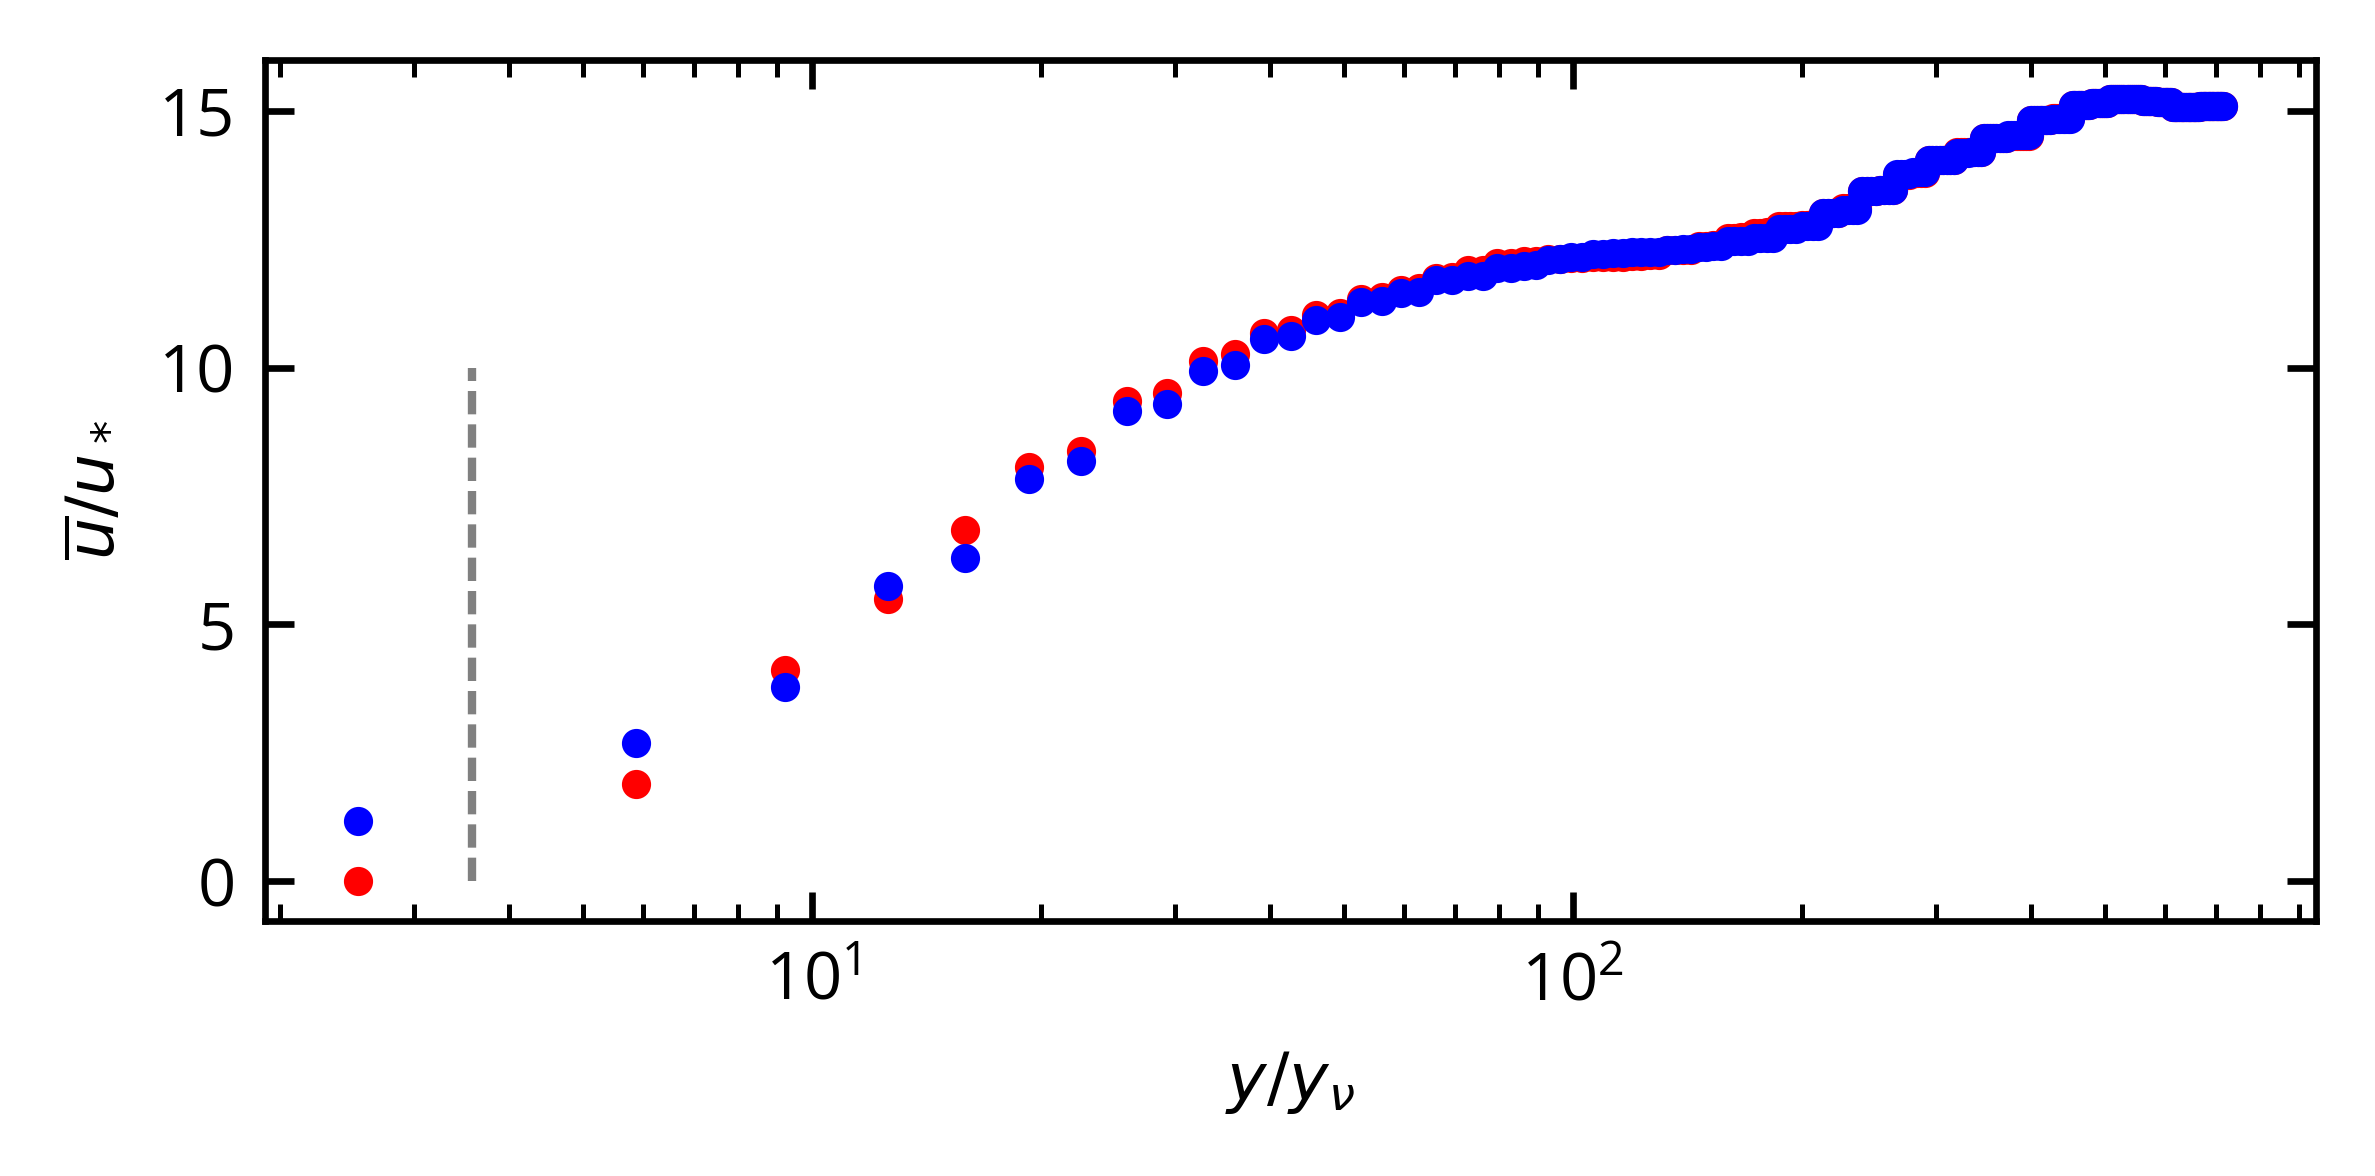

In [130]:
"""Plot mean above crest and trough separately."""
plt.figure(figsize=[4,2])
case = case_pre2

"""Loop over different time"""
for ti in range(9,10):
    ux1Dc = [] # Crest mean profile
    ux1Dt = [] # Trough mean profile
    etac = 0
    etat = 0
    """Put the crest and trough together, respectively"""
    for i in range (0, int(case.k)):
        indexc = case.shift_index[ti] + i*int(case.N/case.k)
        indext = indexc + int(case.N/case.k/2)
        # If it exceeds N, loop back
        if indexc >= case.N:
            indexc = indexc - case.N
        if indext >= case.N:
            indext = indext - case.N
        ux1Dc.append((case.ux[ti]*(1-case.f[ti]))[indexc])
        ux1Dt.append((case.ux[ti]*(1-case.f[ti]))[indext])
        etac += case.eta[ti][indexc]
        etat += case.eta[ti][indext]
    """Average the crest and trough interface elevation
    And a simple coordinate transform y - eta(x) """
    etac = etac/int(case.k)
    etat = etat/int(case.k)
    yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2

    plt.plot(((yarray[27:-1:2])-1)/ytau, np.average(ux1Dc, axis=0)[27:-1:2]/case.ustar, '.', 
             color='r')
    plt.plot(((yarray[27:-1:2])-1)/ytau, np.average(ux1Dt, axis=0)[27:-1:2]/case.ustar, '.', 
             color='b')
#     plt.plot((yarrayc[21:-1:2])/ytau, np.average(ux1Dc, axis=0)[21:-1:2]/case.ustar, '.', 
#              color=plt.cm.get_cmap('summer')(1-ti/10))
#     plt.plot((yarrayt[21:-1:2])/ytau, np.average(ux1Dt, axis=0)[21:-1:2]/case.ustar, 'x', 
#              color=plt.cm.get_cmap('summer')(1-ti/10))

plt.plot(np.ones(100)*(etac-1)/ytau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(etat-1)/ytau, np.linspace(0,10,100), '--', c='gray',lw=1)

plt.xscale('log'); 
plt.ylabel(r'$\overline{u}/u_*$'); 
plt.xlabel(r'$y/y_{\nu}$'); 
plt.legend()
# plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
#          marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
#          label = 'ak=%g' %case.ak, color='darkviolet') 
# field_shift['value'] = np.roll(field['value'], -idx, axis=1)


No handles with labels found to put in legend.


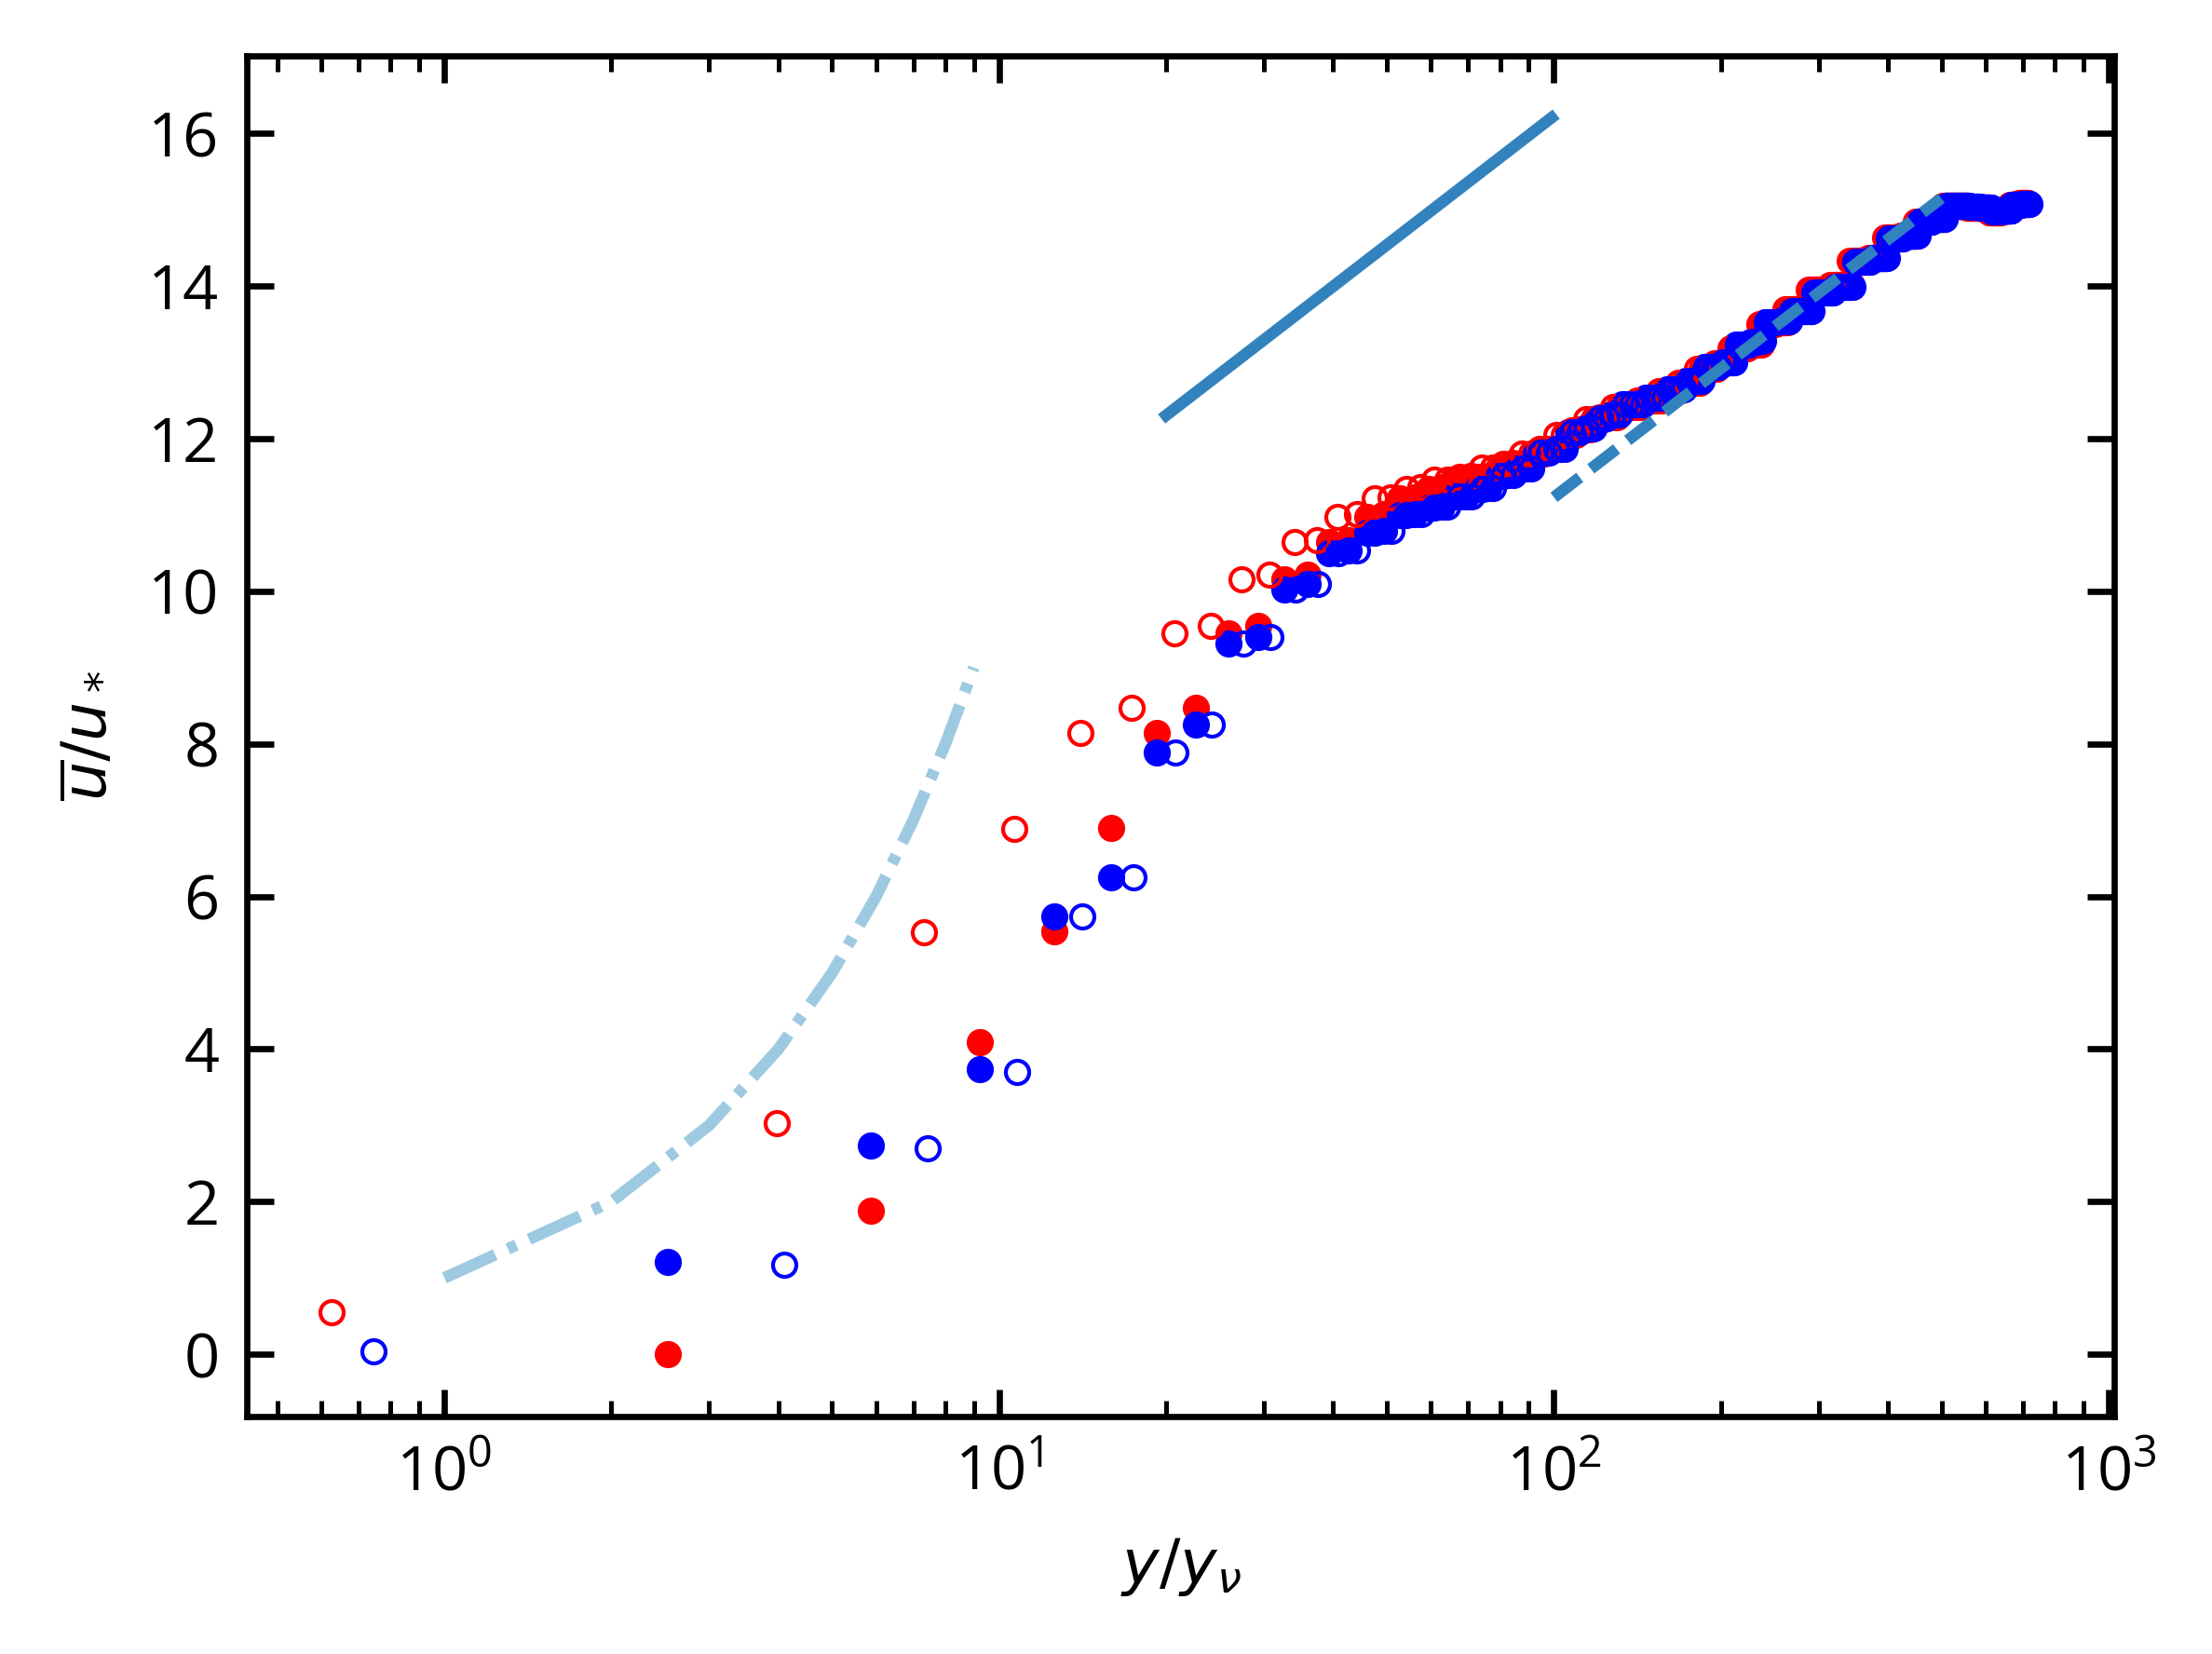

In [160]:
"""Plot mean above crest and trough separately."""
plt.figure(figsize=[4,3])
case = case_pre2

"""Loop over different time"""
for ti in range(0,1):
    ux1Dc = [] # Crest mean profile
    ux1Dt = [] # Trough mean profile
    etac = 0
    etat = 0
    """Put the crest and trough together, respectively"""
    for i in range (0, int(case.k)):
        indexc = case.shift_index[ti] + i*int(case.N/case.k)
        indext = indexc + int(case.N/case.k/2)
        # If it exceeds N, loop back
        if indexc >= case.N:
            indexc = indexc - case.N
        if indext >= case.N:
            indext = indext - case.N
        ux1Dc.append((case.ux[ti]*(1-case.f[ti]))[indexc])
        ux1Dt.append((case.ux[ti]*(1-case.f[ti]))[indext])
        etac += case.eta[ti][indexc]
        etat += case.eta[ti][indext]
    """Average the crest and trough interface elevation
    And a simple coordinate transform y - eta(x) """
    etac = etac/int(case.k)
    etat = etat/int(case.k)
    yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2
    yarrayc = yarray - etac 
    yarrayt = yarray - etat 
    
    plt.plot(((yarray[27:-1:2])-1)/ytau, np.average(ux1Dc, axis=0)[27:-1:2]/case.ustar, '.', 
             color='r')
    plt.plot(((yarray[27:-1:2])-1)/ytau, np.average(ux1Dt, axis=0)[27:-1:2]/case.ustar, '.', 
             color='b')

    plt.plot((yarrayc[0:-1:2])/ytau, np.average(ux1Dc, axis=0)[0:-1:2]/case.ustar,
             marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0, color='r')
    plt.plot((yarrayt[0:-1:2])/ytau, np.average(ux1Dt, axis=0)[0:-1:2]/case.ustar, 
             marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0, color='b')

y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))

ratio = 0.5
y = np.arange(100,500)
plt.plot(y, 1/0.41*np.log(y), '--', color=plt.get_cmap('tab20c')(0))
y = np.arange(20,100)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
ax.text(0.1, 0.15, r'$u^+=y^+$', ha='center', va='center', rotation=15., fontsize=6, 
        color=plt.get_cmap('tab20c')(2), transform=ax.transAxes)
ax.text(0.5, 0.65, r'$u^+=2.5ln(y^+)+5$', ha='center', va='center', rotation=23, fontsize=6,
        color=plt.get_cmap('tab20c')(0), transform=ax.transAxes)
    
plt.xscale('log'); 
plt.ylabel(r'$\overline{u}/u_*$'); 
plt.xlabel(r'$y/y_{\nu}$'); 
plt.legend()
# plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
#          marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
#          label = 'ak=%g' %case.ak, color='darkviolet') 
# field_shift['value'] = np.roll(field['value'], -idx, axis=1)


In [123]:
etac

1.0262423144531265

<ipython-input-58-4c3bd2b177b4>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range (0, np.int(case.k)):
<ipython-input-58-4c3bd2b177b4>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

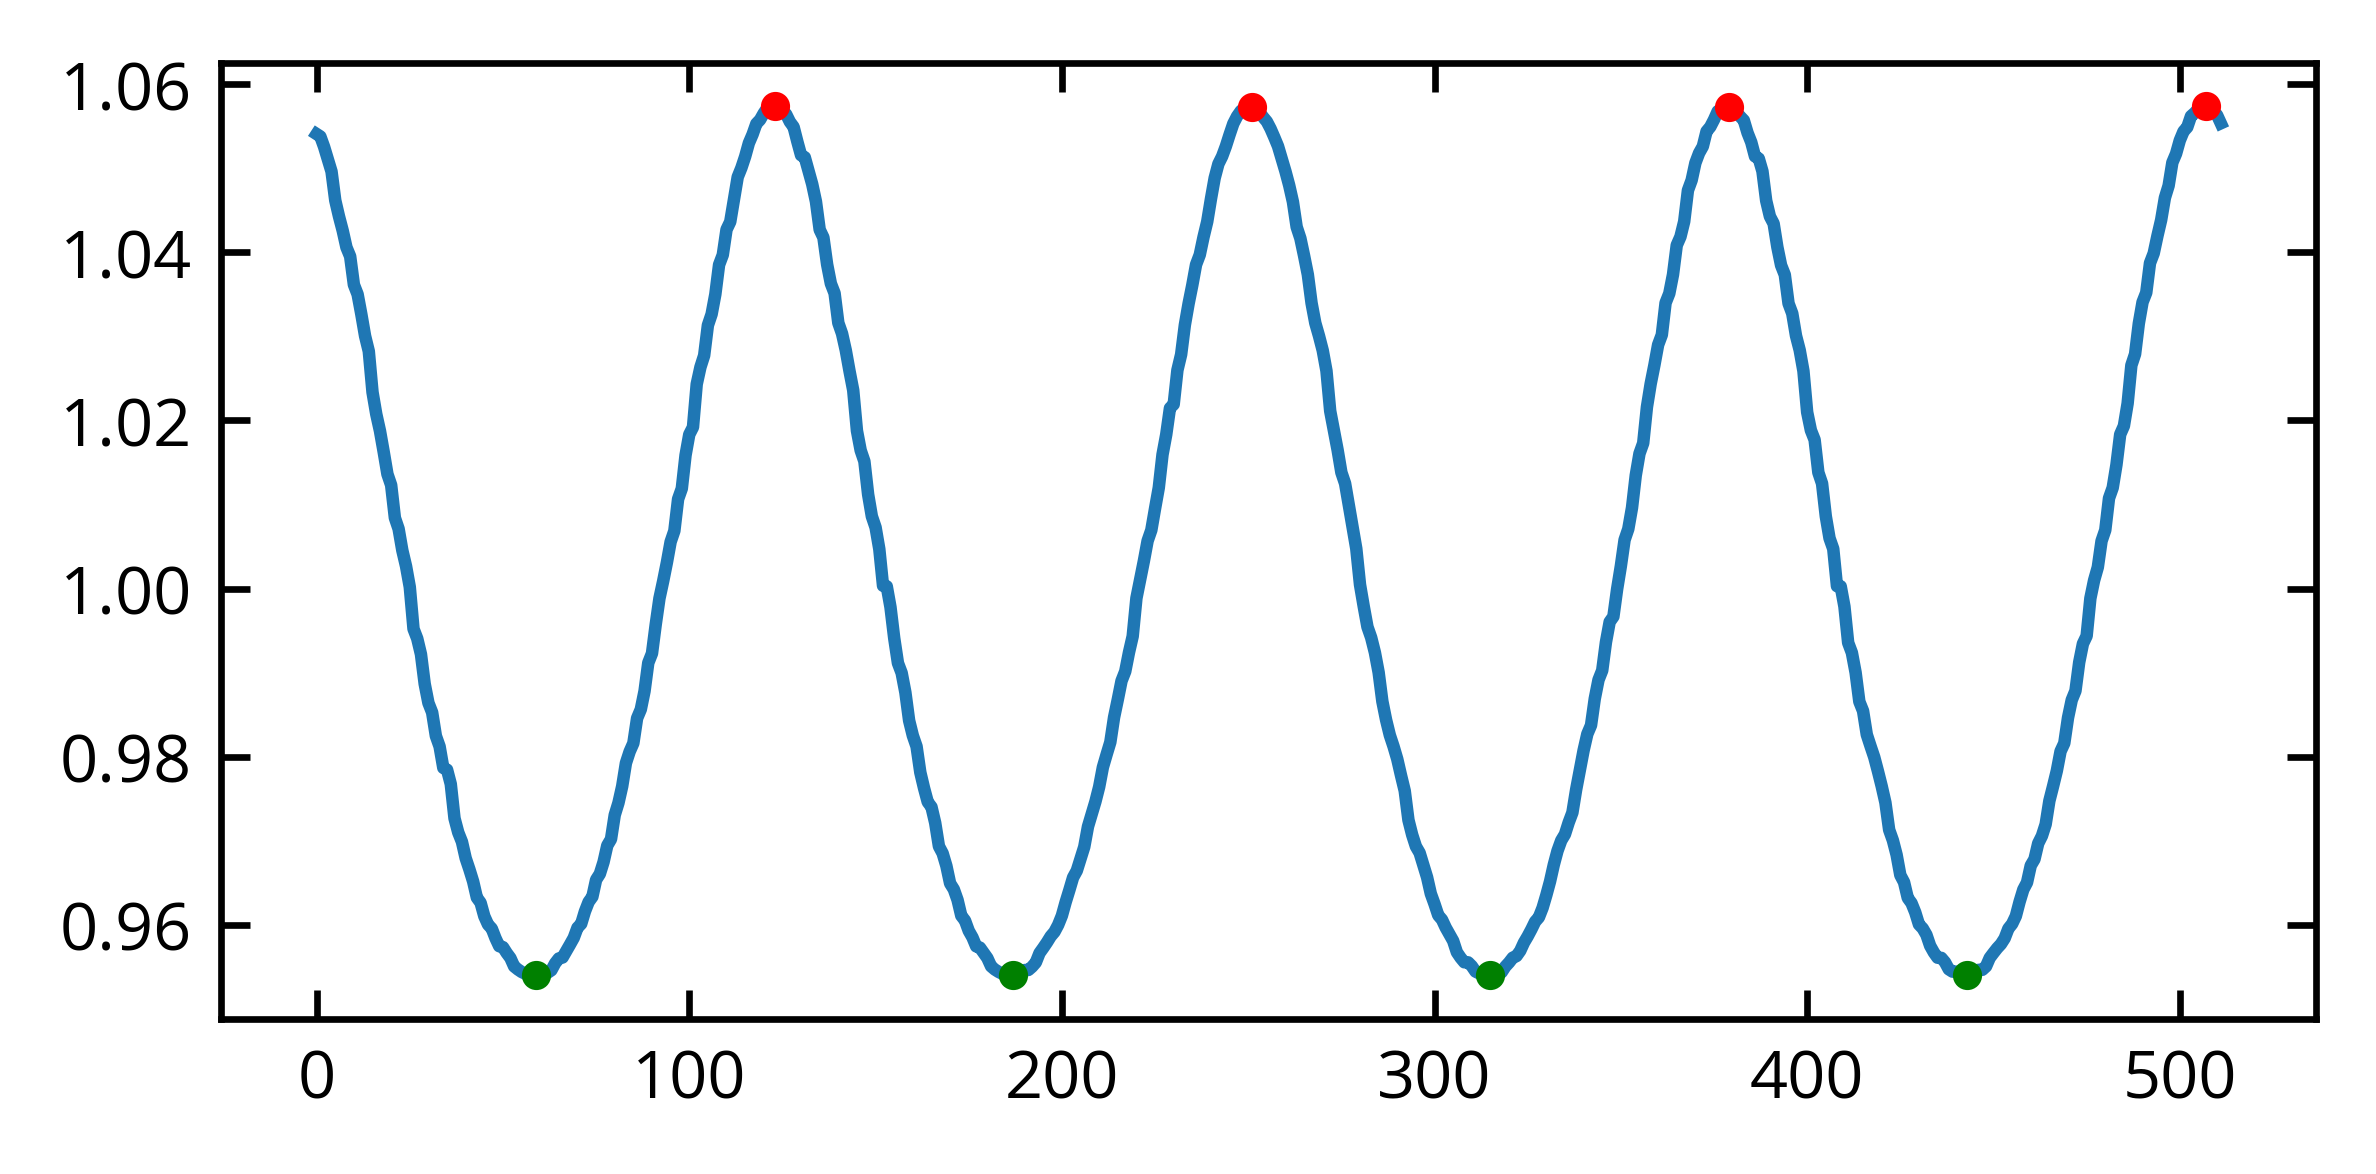

In [58]:
t = 5
plt.figure(figsize=[4,2])
case = case1
plt.plot(case.eta[t])
"""Note: only work if k is an integer."""
for i in range (0, np.int(case.k)):
    indexc = case.shift_index[t] + i*np.int(case.N/case.k)
    indext = indexc + np.int(case.N/case.k/2)
    # If it exceeds N, loop back
    if indexc > case.N:
        indexc = indexc - case.N
    if indext > case.N:
        indext = indext - case.N
    plt.plot(indexc, case.eta[t][indexc], '.', c = 'red')
    plt.plot(indext, case.eta[t][indext], '.', c = 'green')

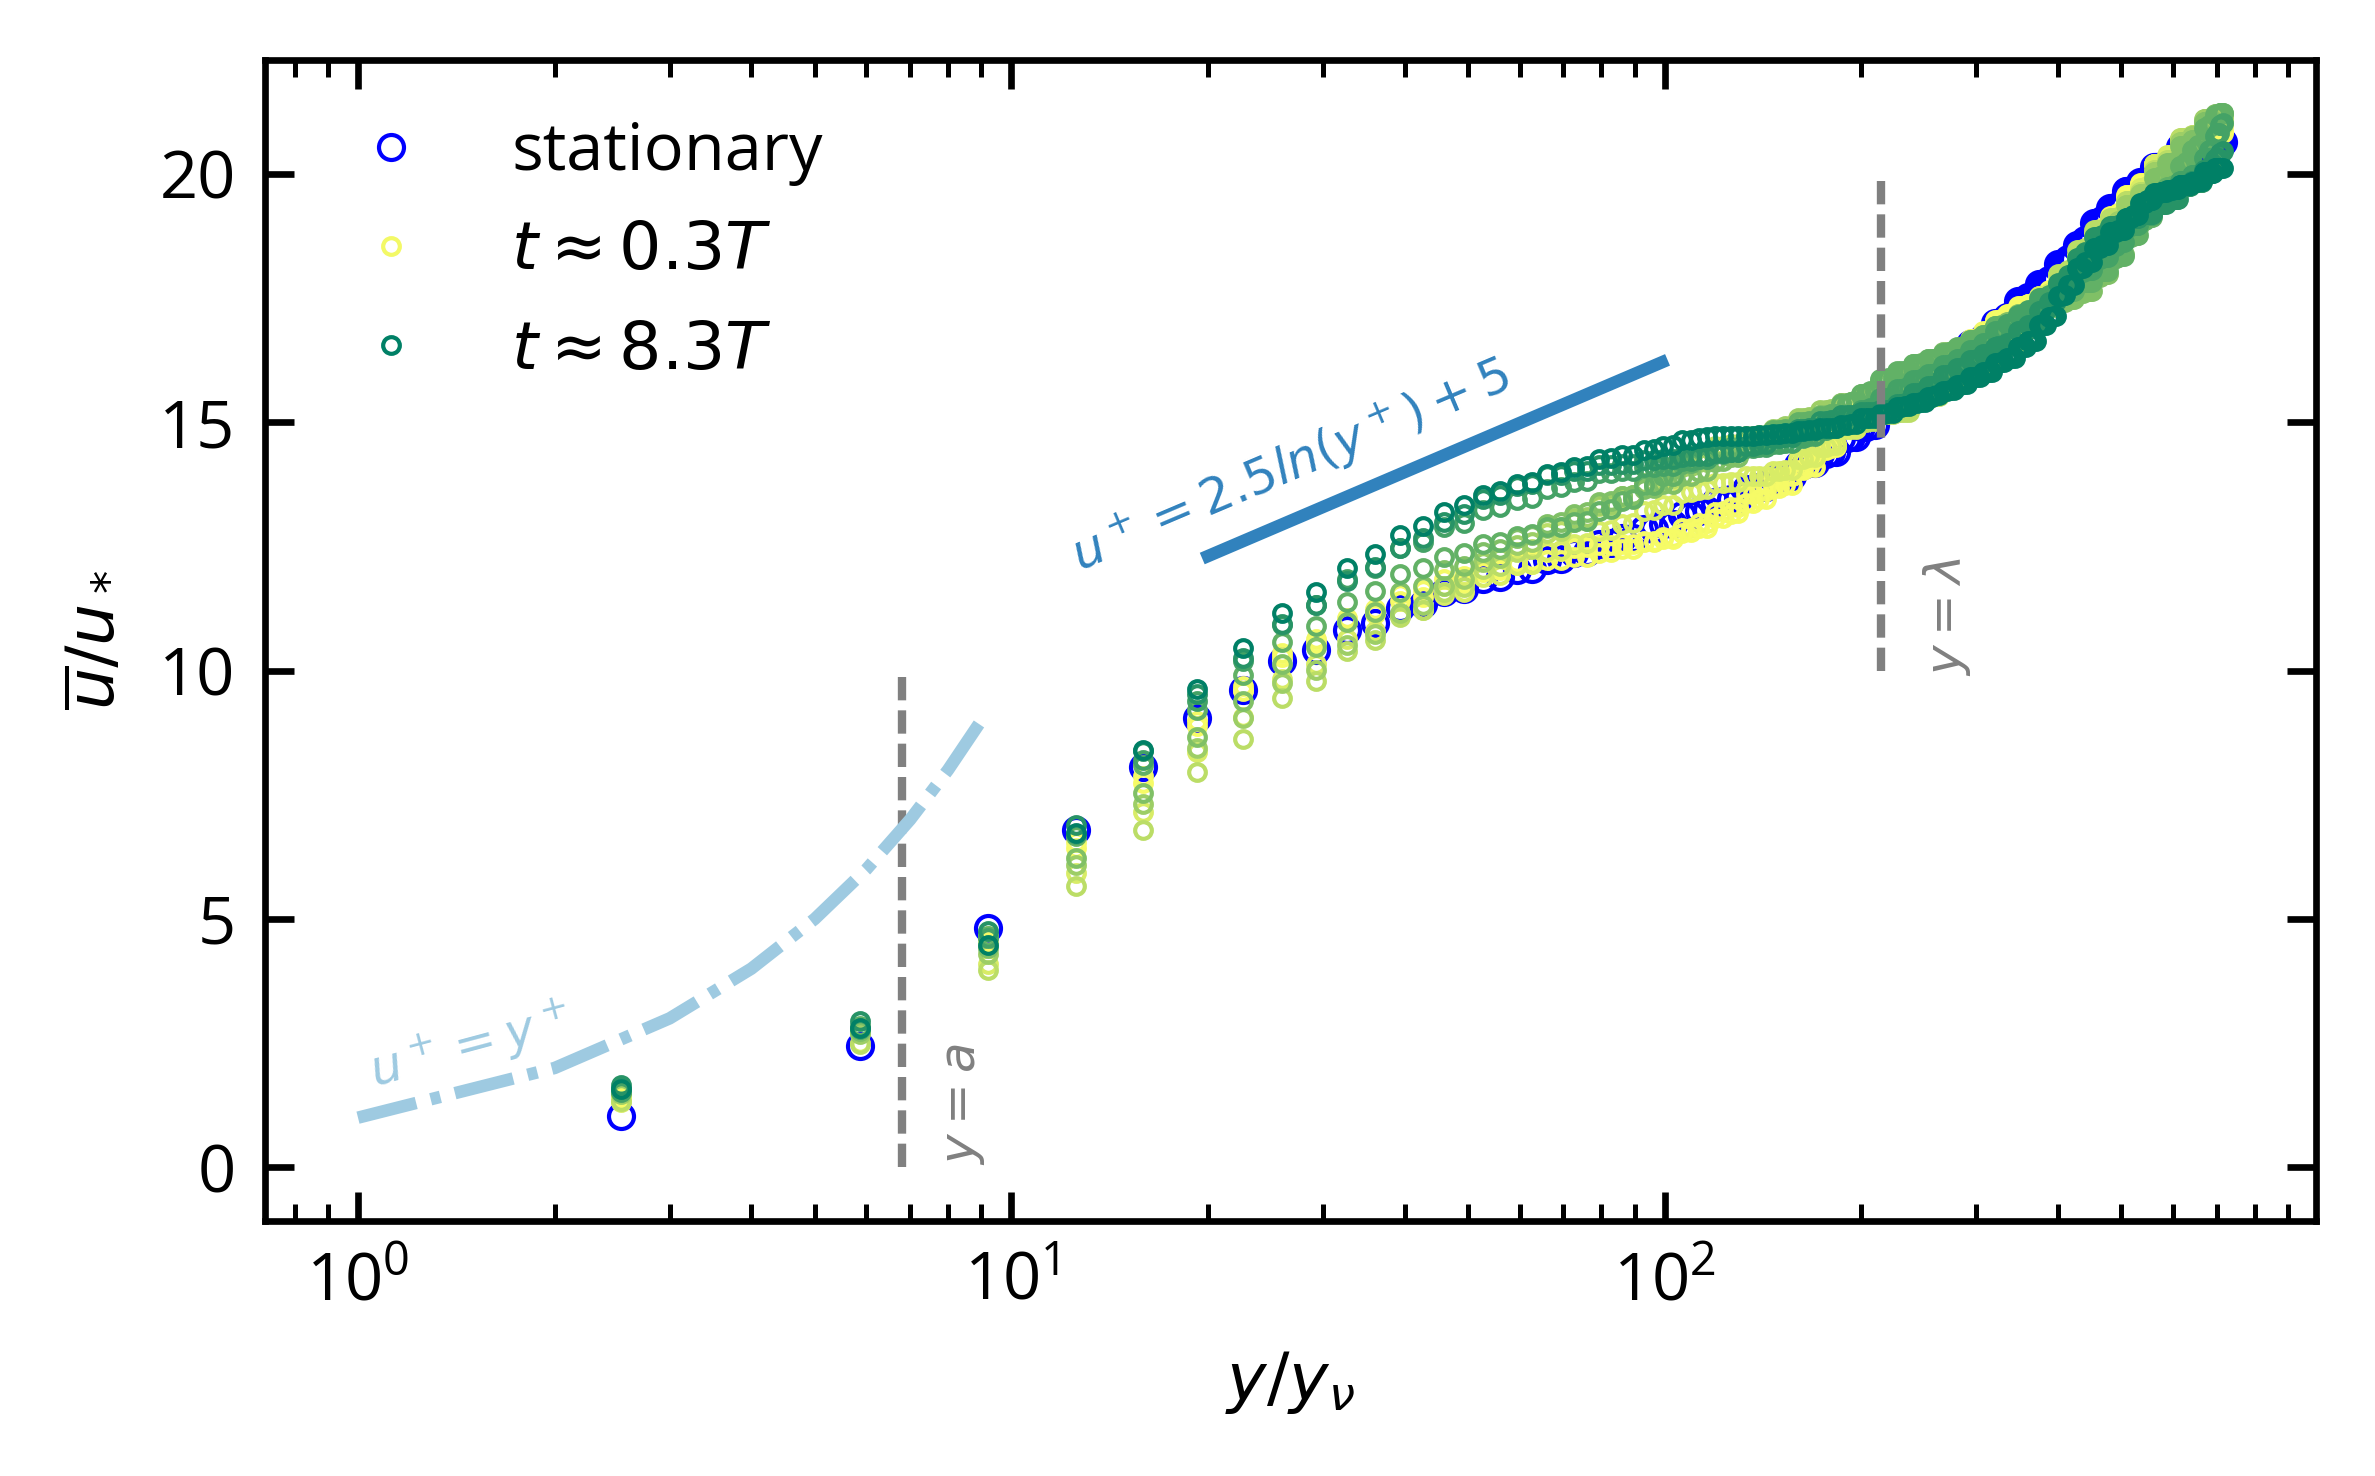

In [268]:
"""Plot the average water profile"""
ytau = (2*np.pi-1)/case.Retau
fig = plt.figure(figsize=[4,2.5]); ax = plt.gca()

"""The stationary wave case"""
case = case_pre
#for i in range(0,8):
#    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', color=plt.cm.get_cmap('summer')(1-i/8))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = 'stationary', color='blue') 

"""u*/c = 0.5 case"""
case = case1
imax = 26
plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[0][31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=2, linewidth=0,
         color=plt.cm.get_cmap('summer')(0.95), label=r'$t \approx 0.3T$')
for i in range(1, imax-1, 3):
    t = i + 0
    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[t][31:-1:2]/case.ustar, 
             marker = 'o', mfc='none', markeredgewidth=0.5, markersize=2, linewidth=0,
             color=plt.cm.get_cmap('summer')(1-i/imax))
plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[imax][31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=2, linewidth=0,
         color=plt.cm.get_cmap('summer')(0), label=r'$t \approx 8.3T$')
# plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
#          marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
#          label = r'$u_*/c=0.5$', color='darkviolet') 


"""Mark where the waves are"""
plt.plot(np.ones(100)*(0.2/4)/ytau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/ytau, np.linspace(10,20,100), '--', c='gray',lw=1)
ax.text(0.34, 0.1, r'$y=a$', ha='center', va='center', rotation=90., fontsize=6, 
        c='gray', transform=ax.transAxes)
ax.text(0.82, 0.52, r'$y=\lambda$', ha='center', va='center', rotation=90., fontsize=6, 
        c='gray', transform=ax.transAxes)

y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
y = np.arange(20,100)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
ax.text(0.1, 0.15, r'$u^+=y^+$', ha='center', va='center', rotation=15., fontsize=6, 
        color=plt.get_cmap('tab20c')(2), transform=ax.transAxes)
ax.text(0.5, 0.65, r'$u^+=2.5ln(y^+)+5$', ha='center', va='center', rotation=23, fontsize=6,
        color=plt.get_cmap('tab20c')(0), transform=ax.transAxes)
plt.xscale('log'); plt.ylabel(r'$\overline{u}/u_*$'); 
plt.xlabel(r'$y/y_{\nu}$'); 
plt.legend()
fig.savefig('/home/jiarong/Downloads/ICTAM/loglaw_g1.pdf')

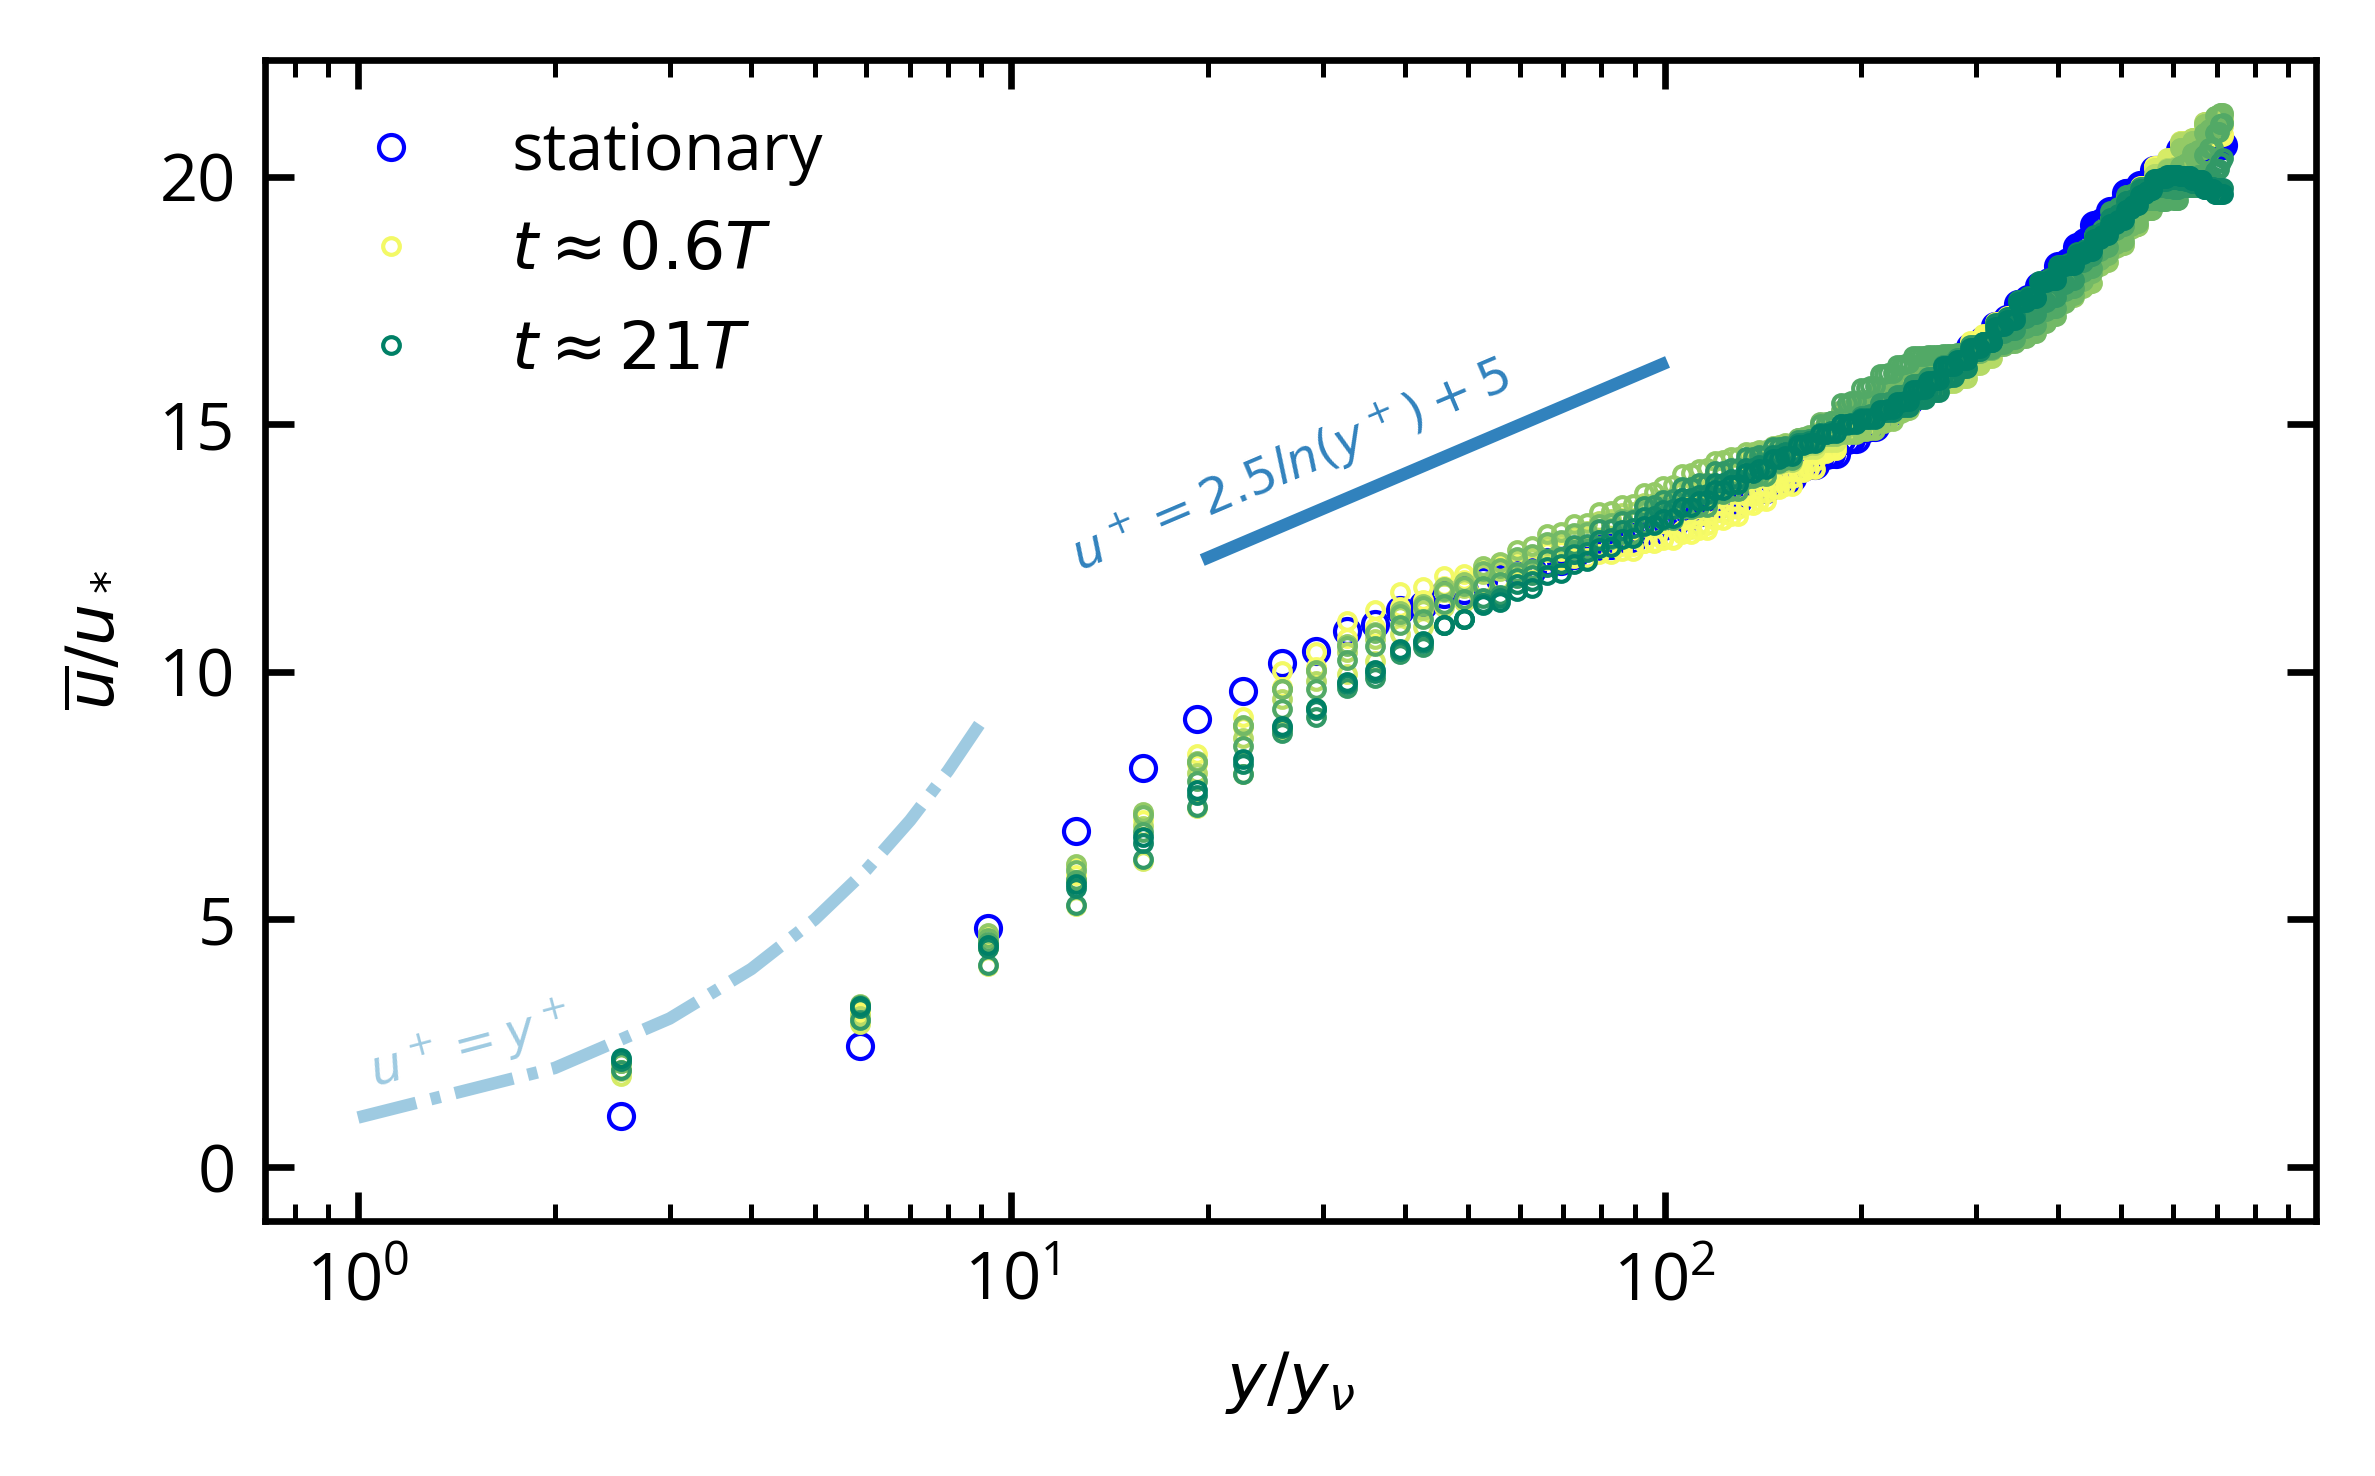

In [264]:
"""Plot the average water profile"""
ytau = (2*np.pi-1)/case.Retau
fig = plt.figure(figsize=[4,2.5]); ax = plt.gca()

"""The stationary wave case"""
case = case_pre
#for i in range(0,8):
#    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', color=plt.cm.get_cmap('summer')(1-i/8))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = 'stationary', color='blue') 

"""u*/c = 0.25 case"""
case = case2
imax = 31
plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[0][31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=2, linewidth=0,
         color=plt.cm.get_cmap('summer')(0.95), label=r'$t \approx 0.6T$')
for i in range(1,imax-1,4):
#    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, 
             marker = 'o', mfc='none', markeredgewidth=0.5, markersize=2, linewidth=0,
             color=plt.cm.get_cmap('summer')(1-i/imax))
plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[imax][31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=2, linewidth=0,
         color=plt.cm.get_cmap('summer')(0), label=r'$t \approx 21T$')
# plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
#          marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
#          label = r'$u_*/c=0.25$', color='magenta')   

y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
y = np.arange(20,100)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
ax.text(0.1, 0.15, r'$u^+=y^+$', ha='center', va='center', rotation=15., fontsize=6, 
        color=plt.get_cmap('tab20c')(2), transform=ax.transAxes)
ax.text(0.5, 0.65, r'$u^+=2.5ln(y^+)+5$', ha='center', va='center', rotation=23, fontsize=6,
        color=plt.get_cmap('tab20c')(0), transform=ax.transAxes)

plt.xscale('log'); plt.ylabel(r'$\overline{u}/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend()
fig.savefig('/home/jiarong/Downloads/ICTAM/loglaw_g4.pdf')

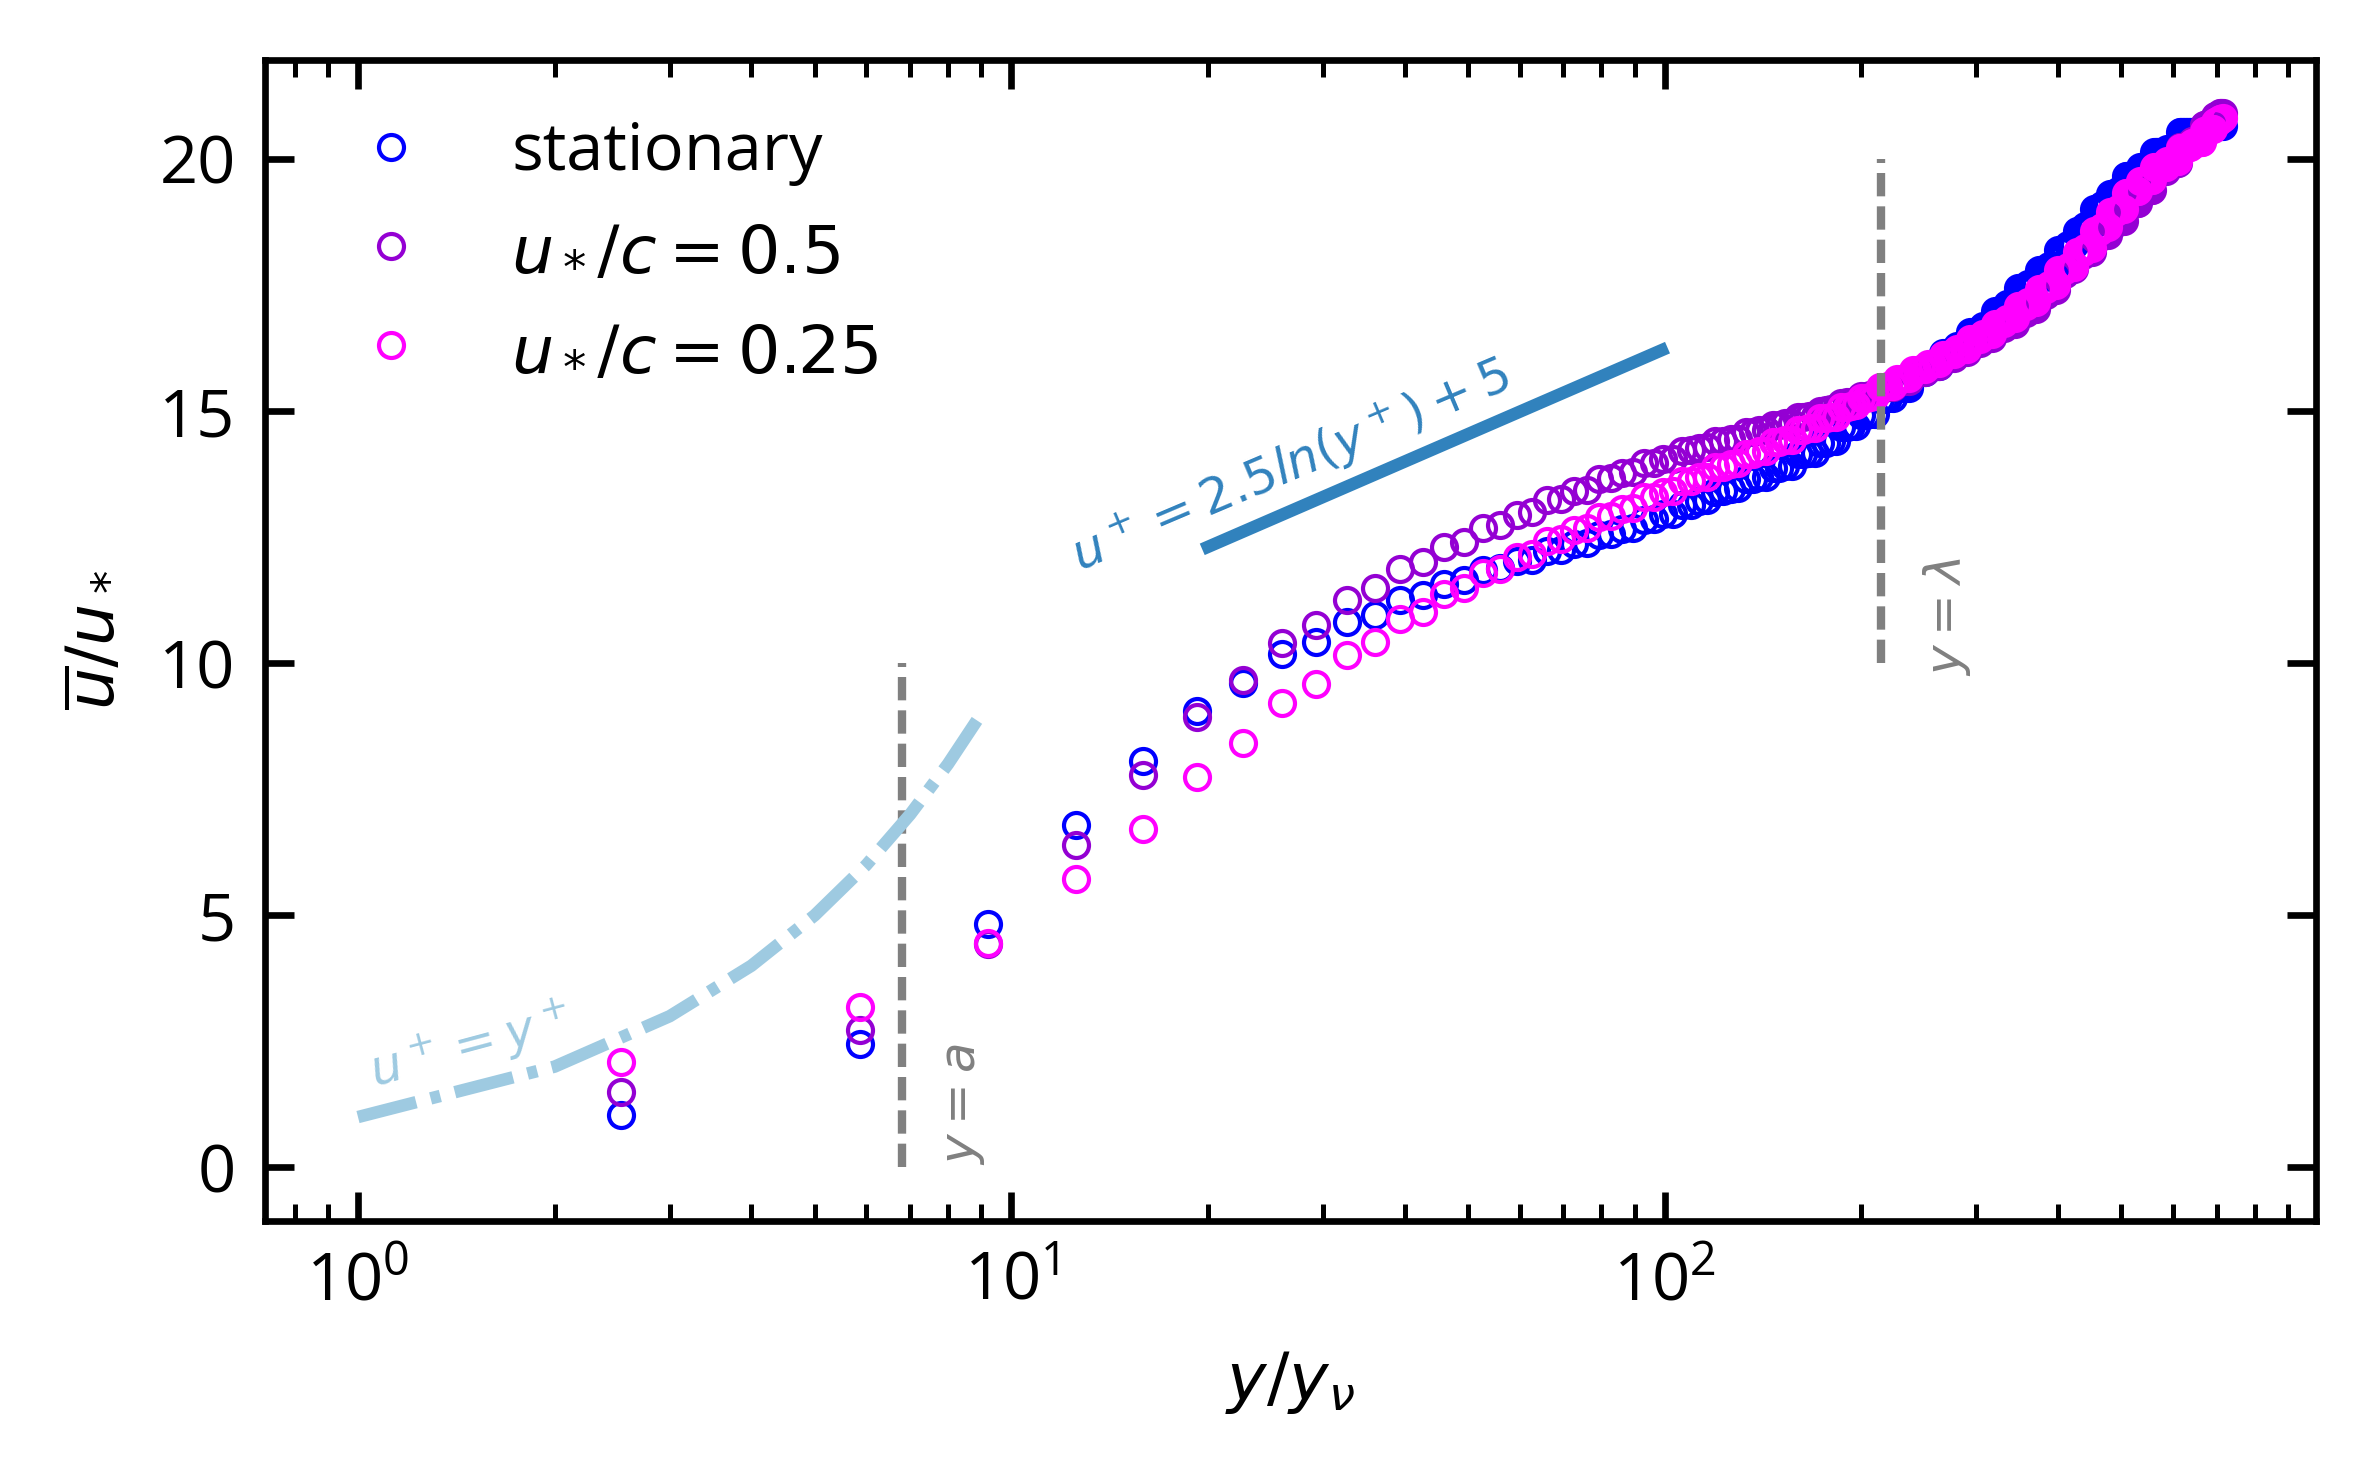

In [265]:
"""Plot the average water profile"""
ytau = (2*np.pi-1)/case.Retau
fig = plt.figure(figsize=[4,2.5]); ax = plt.gca()

"""The stationary wave case"""
case = case_pre
#for i in range(0,8):
#    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', color=plt.cm.get_cmap('summer')(1-i/8))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean, axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = 'stationary', color='blue') 

"""u*/c = 0.5 case"""
case = case1
#for i in range(0,8):
#    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', color=plt.cm.get_cmap('summer')(1-i/8))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean[5:], axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$u_*/c=0.5$', color='darkviolet')    

"""u*/c = 0.25 case"""
case = case2
#for i in range(0,8):
#    case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
#    plt.plot((case.yarray[31:-1:2]-1)/ytau, case.uxmean[i][31:-1:2]/case.ustar, '.', color=plt.cm.get_cmap('summer')(1-i/8))
plt.plot((case.yarray[31:-1:2]-1)/ytau, np.average(case.uxmean[5:], axis=0)[31:-1:2]/case.ustar, 
         marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3, linewidth=0,
         label = r'$u_*/c=0.25$', color='magenta')   

"""Mark where the waves are"""
plt.plot(np.ones(100)*(0.2/4)/ytau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/ytau, np.linspace(10,20,100), '--', c='gray',lw=1)
ax.text(0.34, 0.1, r'$y=a$', ha='center', va='center', rotation=90., fontsize=6, 
        c='gray', transform=ax.transAxes)
ax.text(0.82, 0.52, r'$y=\lambda$', ha='center', va='center', rotation=90., fontsize=6, 
        c='gray', transform=ax.transAxes)

# ux_ensemble_aver = np.average(ux_shift[15:20], axis=(0,1))
# re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
# plt.plot((case.yarray[31:-1:2]-1)/ytau, ux_ensemble_aver[31:-1:2]/case.ustar, '.', 
#          label = 'moving wave', color='red')
y = np.arange(20,100)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
ax.text(0.1, 0.15, r'$u^+=y^+$', ha='center', va='center', rotation=15., fontsize=6, 
        color=plt.get_cmap('tab20c')(2), transform=ax.transAxes)
ax.text(0.5, 0.65, r'$u^+=2.5ln(y^+)+5$', ha='center', va='center', rotation=23, fontsize=6,
        color=plt.get_cmap('tab20c')(0), transform=ax.transAxes)
plt.xscale('log'); plt.ylabel(r'$\overline{u}/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend()
fig.savefig('/home/jiarong/Downloads/ICTAM/loglaw_comparison.pdf')

In [ ]:
"""Transformed coordinate"""
from scipy.interpolate import interp1d
def water_profile(u_water, eta, L0):
    '''
        u_water: a 2D velocity slice, axis0 in x, axis1 in y (denote here as z)
        eta: a 1D velocity slice;
        L0: domain size.
    '''
    u_water_1D_nointerp = np.average(u_water, axis=0)
    
    # Interpolate by simply taking difference
    u_water_interp = np.zeros(u_water.shape)
    for i in range(u_water.shape[0]):
        zmax = L0; zmin = 0.
        zgrid = np.linspace(zmin, zmax, 512, endpoint=False) + (zmax-zmin)/512/2
        z1 = np.linspace(-L0/2,L0/2,512) + eta[i]
        f = interp1d(zgrid, u_water[i,:], fill_value='extrapolate', kind='quadratic')
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_interp_1D = np.average(u_water_interp, axis=0)
    phase_aver_interp = u_water_interp - np.tile(u_water_interp_1D, (NGRID, 1))
    
    # Interpolate back to Cartisan coord to plot
    phase_aver_cart = np.zeros(phase_aver_interp.shape)
    for i in range(u_water.shape[0]):
        zmax = L0/2.; zmin = - L0/2.
        zgrid = np.linspace(zmin, zmax, 512)
        z = np.linspace(-L0/2,L0/2,512) + eta[i]
        g = interp1d(z, phase_aver_interp[i,:], fill_value='extrapolate',  kind='quadratic')
        ugrid = g(zgrid)
        phase_aver_cart[i] = ugrid
    return u_water, u_water_interp, phase_aver_cart, phase_aver_interp, u_water_interp_1D

In [ ]:
"""Phase averaging"""